In [1]:
import pandas as pd # Part 1: Data Loading with Fixed Dataset Approach (CSV Format)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid') # Set plotting style
sns.set_palette("viridis")
data_dir = 'asx200_data'  # Create a directory for saved datasets
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Created directory: {data_dir}")
raw_data_file = f"{data_dir}/asx200_raw_data.csv" # Define file paths for fixed dataset
processed_data_file = f"{data_dir}/asx200_processed_data.csv"
def get_asx200_data(start_date='2018-01-01', end_date='2023-01-01', force_download=False): # Function to load or download ASX200 data
    if os.path.exists(raw_data_file) and not force_download:     # Check if we already have saved data
        print(f"Loading ASX200 data from saved file: {raw_data_file}")
        try:
            data = pd.read_csv(raw_data_file)
            data['Date'] = pd.to_datetime(data['Date'])             # Convert date column to datetime and set as index
            data.set_index('Date', inplace=True)
            print(f"Loaded data with {len(data)} rows from {data.index.min().date()} to {data.index.max().date()}")
            return data
        except Exception as e:
            print(f"Error loading saved data: {e}")
    print(f"Downloading ASX200 data from Yahoo Finance (start={start_date}, end={end_date})...")     # Download fresh data if needed
    try:
        data = yf.download('^AXJO', start=start_date, end=end_date)
        print(f"Downloaded {len(data)} rows of ASX200 data")
        data.reset_index().to_csv(raw_data_file, index=False)         # Save raw data as CSV for future use
        print(f"Saved raw data to {raw_data_file}")
        return data
    except Exception as e:
        print(f"Error downloading data: {e}")
        date_range = pd.date_range(start=start_date, end=end_date, freq='B')         # If download fails, create minimal synthetic data for testing
        synthetic_data = pd.DataFrame(
            index=date_range,
            data={
                'Open': np.random.normal(7000, 300, size=len(date_range)),
                'High': np.random.normal(7100, 300, size=len(date_range)),
                'Low': np.random.normal(6900, 300, size=len(date_range)),
                'Close': np.random.normal(7000, 300, size=len(date_range)),
                'Adj Close': np.random.normal(7000, 300, size=len(date_range)),
                'Volume': np.random.normal(1000000, 200000, size=len(date_range))
            }
        )
        synthetic_data.reset_index().rename(columns={'index': 'Date'}).to_csv(raw_data_file, index=False)         # Save synthetic data as CSV
        print(f"Saved synthetic data to {raw_data_file}")
        return synthetic_data
def prepare_data(data): # Function to process and prepare data for modeling
    if os.path.exists(processed_data_file):     # Check if processed data already exists
        print(f"Loading processed data from: {processed_data_file}")
        try:
            stocks_df = pd.read_csv(processed_data_file)
            stocks_df['date'] = pd.to_datetime(stocks_df['date'])             # Convert date column to datetime
            df = stocks_df.copy()             # Recreate the other formats needed
            df.set_index('date', inplace=True)
            close_series = df['Close'].copy()
            result = {
                'df': df,
                'stocks_df': stocks_df,
                'close_series': close_series
            }
            return result
        except Exception as e:
            print(f"Error loading processed data: {e}")
    df = data.copy()     # Create a copy to avoid modifying the original
    if df.isnull().sum().sum() > 0:     # Handle missing values
        print(f"Filling {df.isnull().sum().sum()} missing values...")
        df = df.fillna(method='ffill')
        if df.isnull().sum().sum() > 0:         # Check if any still remain
            df = df.fillna(method='bfill')
    df['Returns'] = df['Close'].pct_change() * 100     # Calculate returns
    stocks_df = df.reset_index()     # Create dataframe with date as column (for easier merging)
    stocks_df.rename(columns={'index': 'Date', 'Date': 'date'}, inplace=True)
    if 'Date' in stocks_df.columns and 'date' not in stocks_df.columns:     # Ensure column is named consistently as 'date'
        stocks_df.rename(columns={'Date': 'date'}, inplace=True)
    stocks_df['date'] = pd.to_datetime(stocks_df['date'])
    close_series = df['Close'].copy()     # Extract close price series for time series modeling
    stocks_df = stocks_df.dropna()     # Drop rows with NaN values (typically just the first row with return calculation)
    stocks_df.to_csv(processed_data_file, index=False)     # Save processed data as CSV
    print(f"Saved processed data to {processed_data_file}")
    result = {      # Create a dictionary with all processed data formats
        'df': df,                   # Original dataframe with date as index
        'stocks_df': stocks_df,     # Dataframe with date as column
        'close_series': close_series # Close price series
    }
    return result
data = get_asx200_data() # Load or download the data
processed_data = prepare_data(data) # Process the data
df = processed_data['df']                  # DataFrame with date as index
stocks_df = processed_data['stocks_df']    # DataFrame with date as column
close_series = processed_data['close_series'] # Close price series
print(f"Date range: {stocks_df['date'].min().date()} to {stocks_df['date'].max().date()}")
print(f"Number of trading days: {len(stocks_df)}")
print(stocks_df.head())
print(stocks_df[['Close', 'Returns']].describe())

Loading ASX200 data from saved file: asx200_data/asx200_raw_data.csv
Loaded data with 1266 rows from 2018-01-02 to 2022-12-30
Loading processed data from: asx200_data/asx200_processed_data.csv
Date range: 2018-01-03 to 2022-12-30
Number of trading days: 1265
        date             Close             High               Low  \
0        NaT             ^AXJO            ^AXJO             ^AXJO   
1 2018-01-03  6070.39990234375  6082.2998046875   6060.7998046875   
2 2018-01-04  6077.10009765625  6102.2001953125   6068.7998046875   
3 2018-01-05   6122.2998046875  6124.7998046875  6077.10009765625   
4 2018-01-08  6130.39990234375           6143.0   6122.2998046875   

               Open Volume   Returns  
0             ^AXJO  ^AXJO       NaN  
1   6061.2998046875      0  0.150134  
2  6070.39990234375      0  0.110375  
3  6077.10009765625      0  0.743771  
4   6122.2998046875      0  0.132305  
           Returns
count  1264.000000
mean      0.017900
std       1.097742
min      -9.6997

Dataframe cleaned successfully. Shape: (1264, 7)
Saved cleaned data to asx200_data/asx200_cleaned_data.csv
        date        Close         High          Low         Open  Volume  \
1 2018-01-03  6070.399902  6082.299805  6060.799805  6061.299805     0.0   
2 2018-01-04  6077.100098  6102.200195  6068.799805  6070.399902     0.0   
3 2018-01-05  6122.299805  6124.799805  6077.100098  6077.100098     0.0   
4 2018-01-08  6130.399902  6143.000000  6122.299805  6122.299805     0.0   
5 2018-01-09  6135.799805  6149.600098  6130.399902  6130.399902     0.0   

    Returns  
1  0.150134  
2  0.110375  
3  0.743771  
4  0.132305  
5  0.088084  

Columns: ['date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Returns']


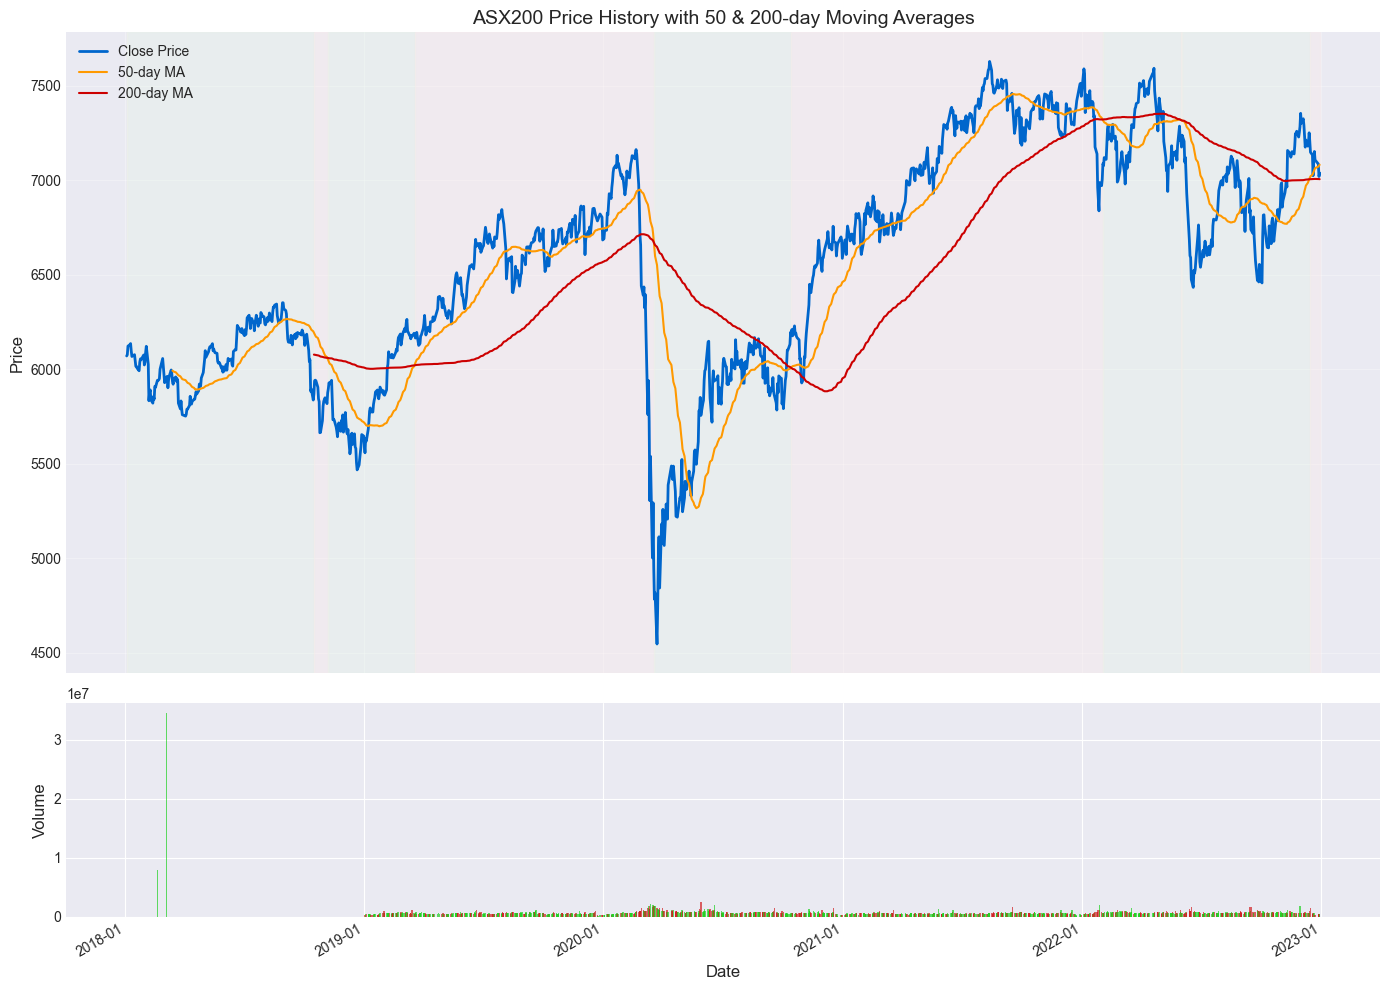

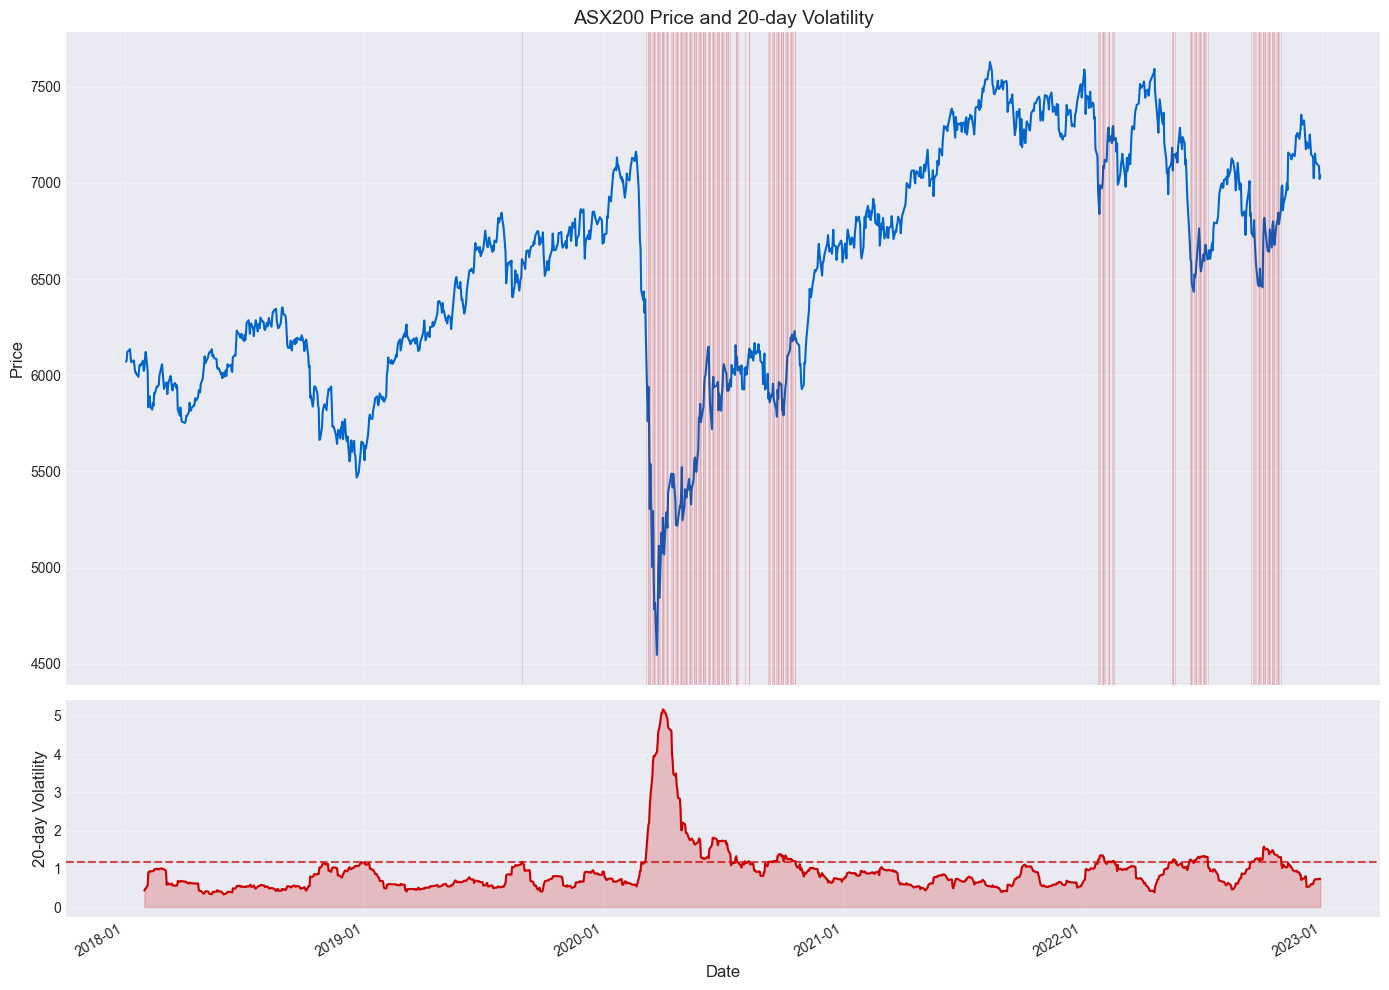

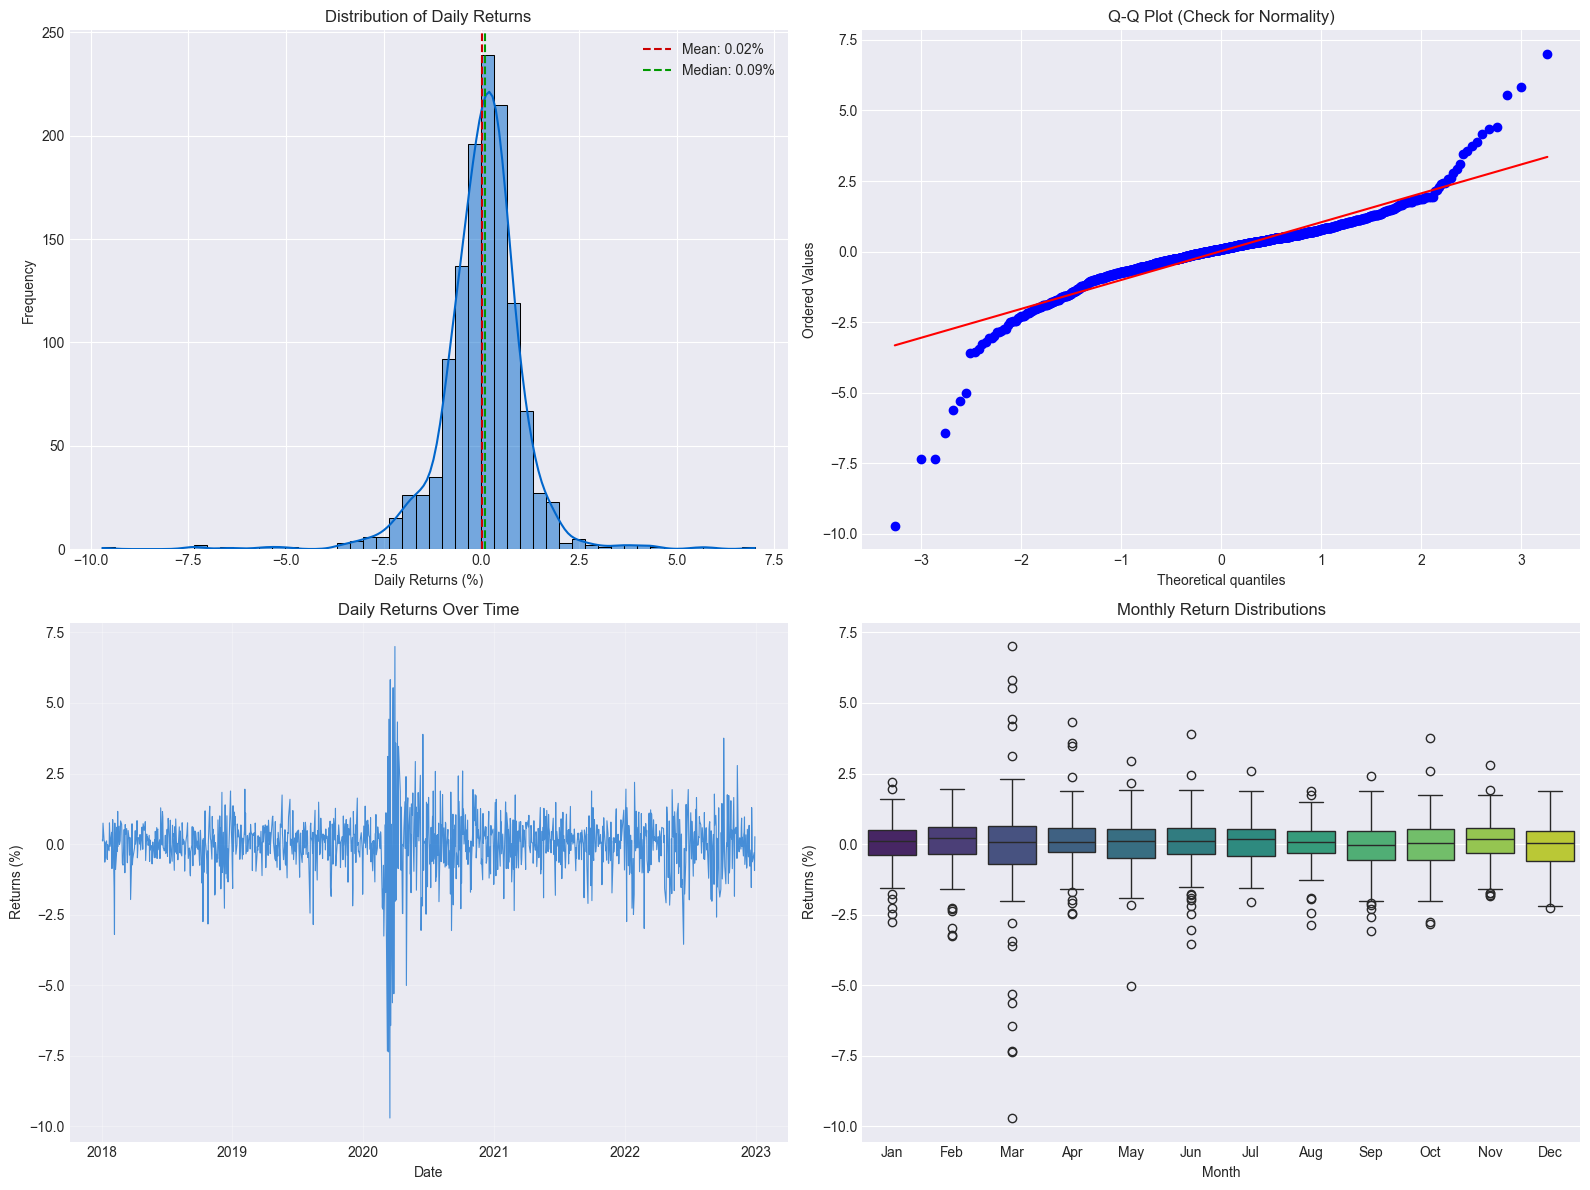

In [2]:
from matplotlib.dates import DateFormatter  # Part 2: Data Cleaning and Visualization
viz_dir = 'asx200_visualizations' # Create directory for visualizations
if not os.path.exists(viz_dir):
    os.makedirs(viz_dir)
    print(f"Created directory: {viz_dir}")
def clean_dataframe(df): # Function to clean the MultiIndex columns if present
    cleaned_df = df.copy()     # Make a copy to avoid modifying the original
    if isinstance(cleaned_df.columns, pd.MultiIndex):     # Check if there are MultiIndex columns
        new_cols = []         # Create new column names by combining levels
        for col in cleaned_df.columns:
            if isinstance(col, tuple):
                parts = [str(part) for part in col if part and str(part) != '^AXJO']                 # Join non-empty parts of the tuple
                if parts:
                    new_cols.append('_'.join(parts))
                else:
                    for part in reversed(col):                     # If no parts after filtering, use the last non-empty part
                        if part and str(part) != '^AXJO':
                            new_cols.append(str(part))
                            break
                    else:
                        new_cols.append('column_' + str(len(new_cols)))
            else:
                new_cols.append(str(col))
        seen = {}         # Handle duplicates in column names
        for i, col in enumerate(new_cols):
            if col in seen:
                new_cols[i] = f"{col}_{seen[col]}"
                seen[col] += 1
            else:
                seen[col] = 1
        cleaned_df.columns = new_cols         # Set the new column names
    if 'date' not in cleaned_df.columns and 'Date' in cleaned_df.columns:     # Ensure the date column is correct
        cleaned_df.rename(columns={'Date': 'date'}, inplace=True)
    if 'date' in cleaned_df.columns:     # Ensure date is datetime type
        cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
    numeric_cols = ['Close', 'Open', 'High', 'Low', 'Volume', 'Returns']     # Ensure numeric columns are properly typed
    for col in numeric_cols:
        if col in cleaned_df.columns:
            cleaned_df[col] = pd.to_numeric(cleaned_df[col], errors='coerce')
    if 'Close' in cleaned_df.columns:     # Drop any rows with NaN in critical columns
        cleaned_df = cleaned_df.dropna(subset=['Close'])
    print(f"Dataframe cleaned successfully. Shape: {cleaned_df.shape}")
    return cleaned_df
def plot_price_history(df, save=True): # Function to create enhanced price chart
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)     # Create figure and axes
    ax1.plot(df['date'], df['Close'], linewidth=2, color='#0066cc', label='Close Price')     # Plot the price data
    df['SMA_50'] = df['Close'].rolling(window=50).mean()    # Calculate and plot moving averages
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    ax1.plot(df['date'], df['SMA_50'], color='#ff9900', linewidth=1.5, label='50-day MA')
    ax1.plot(df['date'], df['SMA_200'], color='#cc0000', linewidth=1.5, label='200-day MA')
    df['bull_market'] = df['SMA_50'] > df['SMA_200']     # Highlight bull/bear market periods (when 50-day MA crosses 200-day MA)
    crossovers = df[df['bull_market'] != df['bull_market'].shift(1)].copy()     # Find crossover points
    if not crossovers.empty:     # Add background shading for bull/bear markets
        prev_x = df['date'].iloc[0]
        prev_bull = df['SMA_50'].iloc[0] > df['SMA_200'].iloc[0]
        for _, row in crossovers.iterrows():
            color = '#e6f7e6' if prev_bull else '#ffebeb'  # Light green for bull, light red for bear
            ax1.axvspan(prev_x, row['date'], alpha=0.3, color=color)
            prev_x = row['date']             # Update for next region
            prev_bull = not prev_bull
        color = '#e6f7e6' if prev_bull else '#ffebeb'         # Shade the final region to the end of the chart
        ax1.axvspan(prev_x, df['date'].iloc[-1], alpha=0.3, color=color)
    volume_colors = np.where(df['Close'] > df['Close'].shift(1), '#00cc00', '#cc0000')     # Add volume subplot
    ax2.bar(df['date'], df['Volume'], color=volume_colors, width=2, alpha=0.6)
    ax2.set_ylabel('Volume', fontsize=12)
    ax1.set_title('ASX200 Price History with 50 & 200-day Moving Averages', fontsize=14)     # Format the axes
    ax1.set_ylabel('Price', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax2.set_xlabel('Date', fontsize=12)     # Add axis labels
    date_format = DateFormatter('%Y-%m')     # Format the dates
    ax2.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
def plot_volatility_analysis(df, window=20, save=True): # Function to visualize volatility
    df['Volatility'] = df['Returns'].rolling(window=window).std()     # Calculate rolling volatility
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)     # Create figure
    ax1.plot(df['date'], df['Close'], color='#0066cc', linewidth=1.5)     # Plot price data
    ax1.set_title(f'ASX200 Price and {window}-day Volatility', fontsize=14)
    ax1.set_ylabel('Price', fontsize=12)
    ax1.grid(True, alpha=0.3)
    median_vol = df['Volatility'].median()     # Identify high volatility periods (above 1.5x median)
    high_vol_threshold = median_vol * 1.5
    high_vol_periods = df[df['Volatility'] > high_vol_threshold]
    if not high_vol_periods.empty:     # Highlight high volatility periods in price chart
        for _, row in high_vol_periods.iterrows():
            ax1.axvline(x=row['date'], color='#cc0000', alpha=0.2, linewidth=0.5)
    ax2.plot(df['date'], df['Volatility'], color='#cc0000', linewidth=1.5)     # Plot volatility
    ax2.axhline(y=high_vol_threshold, color='#cc0000', linestyle='--', alpha=0.7)
    ax2.fill_between(df['date'], df['Volatility'], color='#cc0000', alpha=0.2)
    ax2.set_ylabel(f'{window}-day Volatility', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    date_format = DateFormatter('%Y-%m')     # Format the dates
    ax2.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
def plot_returns_distribution(df, save=True): # Function to visualize returns distribution
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))     # Create figure
    sns.histplot(df['Returns'], bins=50, kde=True, ax=ax1, color='#0066cc')     # 1. Histogram of returns
    ax1.set_title('Distribution of Daily Returns', fontsize=12)
    ax1.set_xlabel('Daily Returns (%)', fontsize=10)
    ax1.set_ylabel('Frequency', fontsize=10)
    mean_return = df['Returns'].mean()     # Add vertical lines for mean and median
    median_return = df['Returns'].median()
    ax1.axvline(x=mean_return, color='#cc0000', linestyle='--', label=f'Mean: {mean_return:.2f}%')
    ax1.axvline(x=median_return, color='#009900', linestyle='--', label=f'Median: {median_return:.2f}%')
    ax1.legend()
    from scipy import stats     # 2. Q-Q plot for normality check
    stats.probplot(df['Returns'], plot=ax2)
    ax2.set_title('Q-Q Plot (Check for Normality)', fontsize=12)
    ax3.plot(df['date'], df['Returns'], color='#0066cc', alpha=0.7, linewidth=0.8)     # 3. Time series of returns
    ax3.set_title('Daily Returns Over Time', fontsize=12)
    ax3.set_xlabel('Date', fontsize=10)
    ax3.set_ylabel('Returns (%)', fontsize=10)
    ax3.grid(True, alpha=0.3)
    df['month'] = df['date'].dt.month     # 4. Monthly seasonality boxplot
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    sns.boxplot(x='month', y='Returns', data=df, ax=ax4, palette='viridis')
    ax4.set_title('Monthly Return Distributions', fontsize=12)
    ax4.set_xlabel('Month', fontsize=10)
    ax4.set_ylabel('Returns (%)', fontsize=10)
    ax4.set_xticklabels(month_names)
    plt.tight_layout()
    plt.show()
stocks_df = clean_dataframe(stocks_df) # Clean the dataframe to handle MultiIndex columns
cleaned_file = 'asx200_data/asx200_cleaned_data.csv' # Save the cleaned dataframe
stocks_df.to_csv(cleaned_file, index=False)
print(f"Saved cleaned data to {cleaned_file}")
print(stocks_df.head()) # Display the cleaned dataframe
print(f"\nColumns: {stocks_df.columns.tolist()}")
df = stocks_df.set_index('date') # Update other data structures to be consistent
close_series = df['Close'].copy()
plot_price_history(stocks_df) # Create and save visualizations
plot_volatility_analysis(stocks_df)
plot_returns_distribution(stocks_df)

Loading cleaned data from asx200_data/asx200_cleaned_data.csv
Processing 1264 rows of data...
Shape before removing NaN values: (1264, 77)
Shape after removing NaN values: (982, 77)
Retained 77.7% of original data
Saved enriched data with all features to asx200_data/asx200_enriched_data.csv
Analyzing feature correlations with Target_Next_Close...


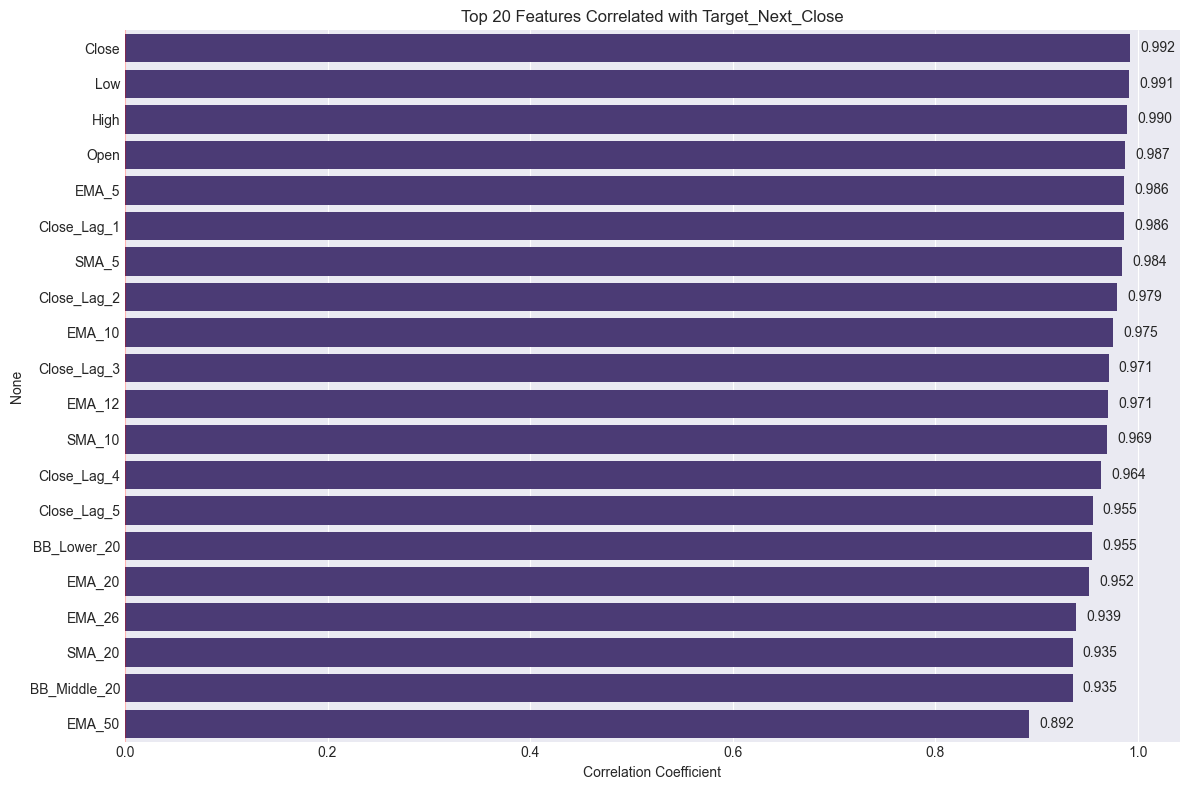

Number of rows: 982
Number of features: 73
          date        Close     RSI_14       MACD    Stoch_K     ATR_14  \
272 2019-01-31  5864.700195  61.072195  54.811027  68.098606  38.064314   
273 2019-02-01  5862.799805  64.969395  51.904935  66.898109  37.364328   
274 2019-02-04  5891.200195  68.303323  51.302131  83.074788  37.771484   
275 2019-02-05  6005.899902  74.196800  59.395044  85.781270  45.400042   
276 2019-02-06  6026.100098  74.170670  66.670190  92.245909  46.957171   

     BB_%B_20  Volatility_20        ADX  Trend_Strength  
272  0.668335       0.552316  47.652664        0.013075  
273  0.645849       0.492222  46.276507        0.012261  
274  0.743190       0.484219  47.006976        0.014420  
275  1.139992       0.586604  49.835006        0.024624  
276  1.115162       0.578824  52.079215        0.026930  


In [3]:
if os.path.exists(cleaned_file): # Part 3: Advanced Feature Engineering
    print(f"Loading cleaned data from {cleaned_file}")
    stocks_df = pd.read_csv(cleaned_file)
    stocks_df['date'] = pd.to_datetime(stocks_df['date'])
else:
    raise FileNotFoundError(f"Could not find {cleaned_file}")     # Exit or create placeholder data
def calculate_technical_indicators(df): # Function to calculate comprehensive technical indicators
    df = df.copy()     # Make a copy to avoid modifying the original
    df = df.sort_values('date')     # Ensure sorted by date
    for window in [5, 10, 20, 50, 100, 200]:      # 1. Price-based indicators        //     # Moving Averages
        df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()     # Moving Average Convergence Divergence (MACD)
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    for window in [5, 10, 20]:     # Price Rate of Change
        df[f'ROC_{window}'] = df['Close'].pct_change(periods=window) * 100
    delta = df['Close'].diff()      # 2. Momentum indicators  //      # Relative Strength Index (RSI)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)  # Avoid division by zero
    df['RSI_14'] = 100 - (100 / (1 + rs))
    df['RSI_14'] = df['RSI_14'].replace([np.inf, -np.inf], np.nan).fillna(50)  # Handle edge cases
    low_14 = df['Low'].rolling(window=14).min()     # Stochastic Oscillator
    high_14 = df['High'].rolling(window=14).max()
    df['Stoch_K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
    df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()
    df['Williams_R'] = -100 * ((high_14 - df['Close']) / (high_14 - low_14))     # Williams %R
    df['TR'] = np.maximum(      # 3. Volatility indicators //      # Average True Range (ATR)
        df['High'] - df['Low'],
        np.maximum(
            abs(df['High'] - df['Close'].shift(1)),
            abs(df['Low'] - df['Close'].shift(1))
        )
    )
    df['ATR_14'] = df['TR'].rolling(window=14).mean()
    for window in [20]:      # Bollinger Bands
        middle_band = df['Close'].rolling(window=window).mean()
        std_dev = df['Close'].rolling(window=window).std()
        df[f'BB_Upper_{window}'] = middle_band + (std_dev * 2)
        df[f'BB_Middle_{window}'] = middle_band
        df[f'BB_Lower_{window}'] = middle_band - (std_dev * 2)
        df[f'BB_Width_{window}'] = (df[f'BB_Upper_{window}'] - df[f'BB_Lower_{window}']) / df[f'BB_Middle_{window}']         # %B indicator (position within Bollinger Bands)
        df[f'BB_%B_{window}'] = (df['Close'] - df[f'BB_Lower_{window}']) / (df[f'BB_Upper_{window}'] - df[f'BB_Lower_{window}'])
    for window in [5, 10, 20, 50]:      # Historical Volatility
        df[f'Volatility_{window}'] = df['Returns'].rolling(window=window).std()
    df['DMplus'] = np.where(      # 4. Trend indicators  //      # Average Directional Index (ADX)
        (df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
        np.maximum(df['High'] - df['High'].shift(1), 0),
        0
    )
    df['DMminus'] = np.where(
        (df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
        np.maximum(df['Low'].shift(1) - df['Low'], 0),
        0
    )
    df['smoothed_TR'] = df['TR'].rolling(window=14).sum()      # Smoothed values
    df['smoothed_DMplus'] = df['DMplus'].rolling(window=14).sum()
    df['smoothed_DMminus'] = df['DMminus'].rolling(window=14).sum()
    df['DIplus'] = 100 * df['smoothed_DMplus'] / df['smoothed_TR'].replace(0, np.nan)     # Calculate +DI and -DI
    df['DIminus'] = 100 * df['smoothed_DMminus'] / df['smoothed_TR'].replace(0, np.nan)
    df['DX'] = 100 * abs(df['DIplus'] - df['DIminus']) / (df['DIplus'] + df['DIminus']).replace(0, np.nan)     # Calculate DX and ADX
    df['ADX'] = df['DX'].ewm(span=14, adjust=False).mean()
    df['SMA_Cross_5_20'] = np.where(df['SMA_5'] > df['SMA_20'], 1, -1)     # Moving Average Crossovers
    df['SMA_Cross_10_50'] = np.where(df['SMA_10'] > df['SMA_50'], 1, -1)
    df['SMA_Cross_50_200'] = np.where(df['SMA_50'] > df['SMA_200'], 1, -1)
    if 'Volume' in df.columns and df['Volume'].sum() > 0:     # 5. Volume-based indicators (if volume data is available and valid)
        df['OBV'] = np.where(          # On-Balance Volume (OBV)
            df['Close'] > df['Close'].shift(1),
            df['Volume'],
            np.where(
                df['Close'] < df['Close'].shift(1),
                -df['Volume'],
                0
            )
        ).cumsum()
        for window in [5, 10, 20]:         # Volume Rate of Change
            df[f'Volume_ROC_{window}'] = df['Volume'].pct_change(periods=window) * 100
        typical_price = (df['High'] + df['Low'] + df['Close']) / 3         # Money Flow Index (MFI)
        raw_money_flow = typical_price * df['Volume']
        positive_flow = np.where(typical_price > typical_price.shift(1), raw_money_flow, 0)
        negative_flow = np.where(typical_price < typical_price.shift(1), raw_money_flow, 0)
        for window in [14]:
            pos_sum = pd.Series(positive_flow).rolling(window=window).sum()
            neg_sum = pd.Series(negative_flow).rolling(window=window).sum()
            money_ratio = np.where(neg_sum != 0, pos_sum / neg_sum, 100)
            df[f'MFI_{window}'] = 100 - (100 / (1 + money_ratio))
    df['RSI_Close_Ratio'] = df['RSI_14'] / df['Close'] * 100      # 6. Hybrid/custom indicators  //      # RSI and price combined
    df['MACD_BB_Signal'] = np.where(      # MACD and BB crossover
        (df['MACD'] > df['MACD_Signal']) & (df['Close'] > df['BB_Middle_20']),
        1,  # Strong buy
        np.where(
            (df['MACD'] < df['MACD_Signal']) & (df['Close'] < df['BB_Middle_20']),
            -1,  # Strong sell
            0   # Neutral
        )
    )
    for window in [50, 200]:     # Price relative to moving averages
        df[f'Price_to_MA_{window}'] = df['Close'] / df[f'SMA_{window}'] - 1
    df['Trend_Strength'] = abs(df['Price_to_MA_50']) * df['ADX'] / 100     # Measure trend strength
    for lag in range(1, 6):  # 1 to 5 day lags         # 7. Lagged features (important for ML models) //      # Create lag features for price and returns
        df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
        df[f'Returns_Lag_{lag}'] = df['Returns'].shift(lag)
    for indicator in ['RSI_14', 'MACD', 'ATR_14']:     # Create lag features for some technical indicators
        for lag in range(1, 3):  # 1 to 2 day lags
            df[f'{indicator}_Lag_{lag}'] = df[indicator].shift(lag)
    df['Target_Next_Close'] = df['Close'].shift(-1)      # 8. Target creation for ML models  //      # Target variable: Next day's close price
    df['Target_Next_Return'] = df['Returns'].shift(-1)     # Target variable: Next day's return
    df['Target_Direction'] = np.where(df['Target_Next_Return'] > 0, 1, 0)     # Target variable: Price direction (binary classification)
    columns_to_drop = [      # 9. Clean up intermediate calculation columns
        'TR', 'smoothed_TR', 'DMplus', 'DMminus', 
        'smoothed_DMplus', 'smoothed_DMminus'
    ]
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    return df
def analyze_feature_correlations(df, target_col='Target_Next_Close', top_n=15, save_path=None): # Create feature correlation analysis
    print(f"Analyzing feature correlations with {target_col}...")
    correlations = df.drop(columns=['date']).corr()[target_col].drop(target_col)     # Calculate correlations with target
    abs_correlations = correlations.abs().sort_values(ascending=False)     # Sort by absolute correlation
    top_features = abs_correlations.head(top_n).index
    plt.figure(figsize=(12, 8))     # Create visualization
    ax = sns.barplot(x=correlations[top_features].values, y=top_features)     # Plot correlation values
    for i, v in enumerate(correlations[top_features].values):     # Add correlation values to the bars
        ax.text(v + 0.01 if v >= 0 else v - 0.06, i, f"{v:.3f}", va='center')
    plt.title(f'Top {top_n} Features Correlated with {target_col}')
    plt.xlabel('Correlation Coefficient')
    plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
    plt.tight_layout()
    plt.show()
print(f"Processing {len(stocks_df)} rows of data...") # Calculate all technical indicators
enriched_df = calculate_technical_indicators(stocks_df)
print(f"Shape before removing NaN values: {enriched_df.shape}") # Remove rows with NaN values after feature engineering
enriched_df = enriched_df.replace([np.inf, -np.inf], np.nan)
enriched_df = enriched_df.dropna()
print(f"Shape after removing NaN values: {enriched_df.shape}")
print(f"Retained {enriched_df.shape[0]/stocks_df.shape[0]:.1%} of original data")
enriched_file = 'asx200_data/asx200_enriched_data.csv' # Save the enriched dataframe
enriched_df.to_csv(enriched_file, index=False)
print(f"Saved enriched data with all features to {enriched_file}")
viz_dir = 'asx200_visualizations'  # Analyze feature correlations with target
analyze_feature_correlations(
    enriched_df, 
    target_col='Target_Next_Close',
    top_n=20,
    save_path=f'{viz_dir}/feature_correlation_analysis.png'
)
print(f"Number of rows: {len(enriched_df)}") # Display information about the enriched dataset
print(f"Number of features: {len(enriched_df.columns) - 4}")  # Excluding date and target columns
indicators_sample = [
    'RSI_14', 'MACD', 'Stoch_K', 'ATR_14', 'BB_%B_20', 
    'Volatility_20', 'ADX', 'Trend_Strength'
]
print(enriched_df[['date', 'Close'] + indicators_sample].head())

Loading enriched data from asx200_data/asx200_enriched_data.csv
Training data: 785 samples (2019-01-31 00:00:00 to 2022-03-18 00:00:00)
Testing data: 197 samples (2022-03-21 00:00:00 to 2022-12-29 00:00:00)

Univariate Linear Regression Evaluation Metrics:
RMSE: 99.8299
MAE: 74.5529
MAPE: 1.0746%
R²: 0.8789


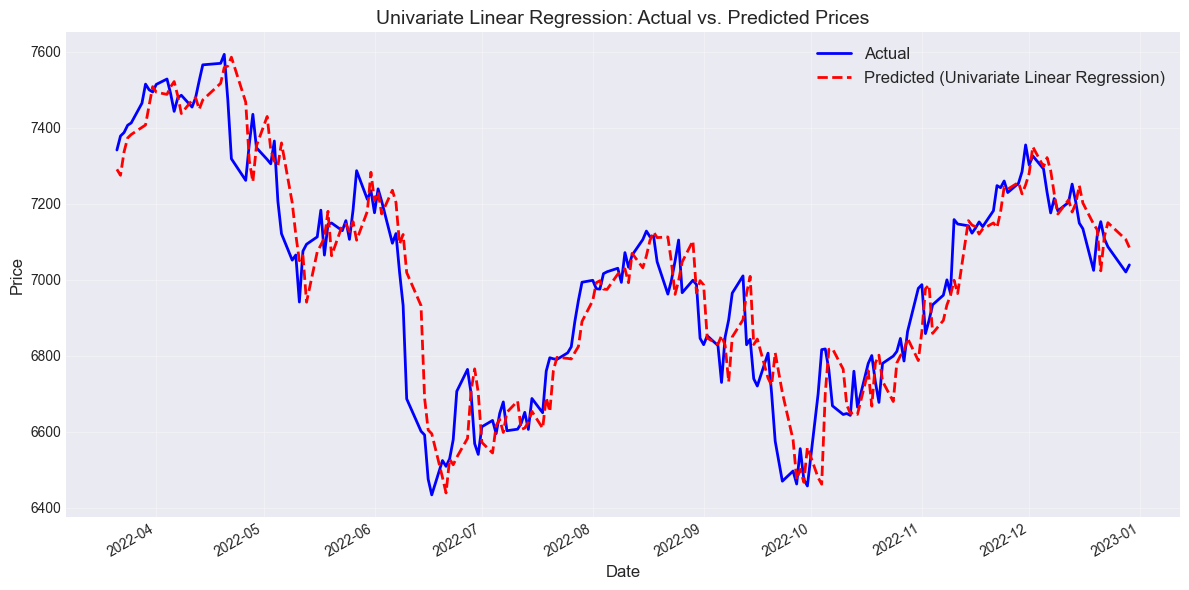

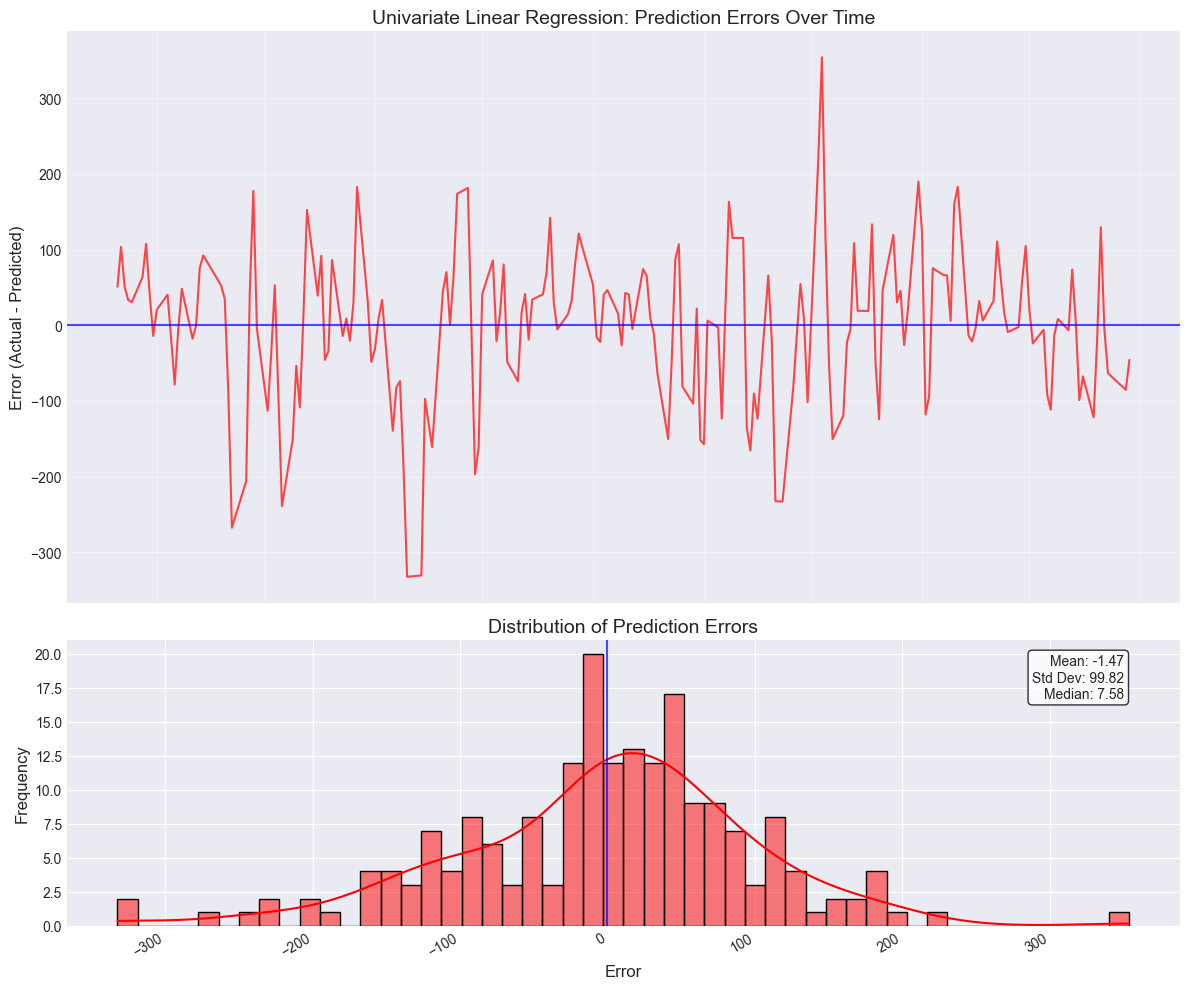

Selected 28 features for multivariate model:
  1. ADX
  2. ATR_14
  3. BB_%B_20
  4. BB_Width_20
  5. Close_Lag_1
  6. Close_Lag_2
  7. Close_Lag_3
  8. Close_Lag_4
  9. Close_Lag_5
  10. EMA_10
  11. EMA_20
  12. EMA_5
  13. MACD
  14. MACD_Signal
  15. RSI_14
  16. Returns
  17. Returns_Lag_1
  18. Returns_Lag_2
  19. SMA_10
  20. SMA_20
  21. SMA_5
  22. SMA_Cross_10_50
  23. SMA_Cross_50_200
  24. SMA_Cross_5_20
  25. Stoch_D
  26. Stoch_K
  27. Trend_Strength
  28. Volatility_20

Multivariate Linear Regression Evaluation Metrics:
RMSE: 75.3093
MAE: 58.5030
MAPE: 0.8424%
R²: 0.9311

Ridge Regression Evaluation Metrics:
RMSE: 77.7148
MAE: 59.5722
MAPE: 0.8588%
R²: 0.9266

Lasso Regression Evaluation Metrics:
RMSE: 76.8822
MAE: 59.1491
MAPE: 0.8525%
R²: 0.9282

Best multivariate model: Multivariate Linear Regression


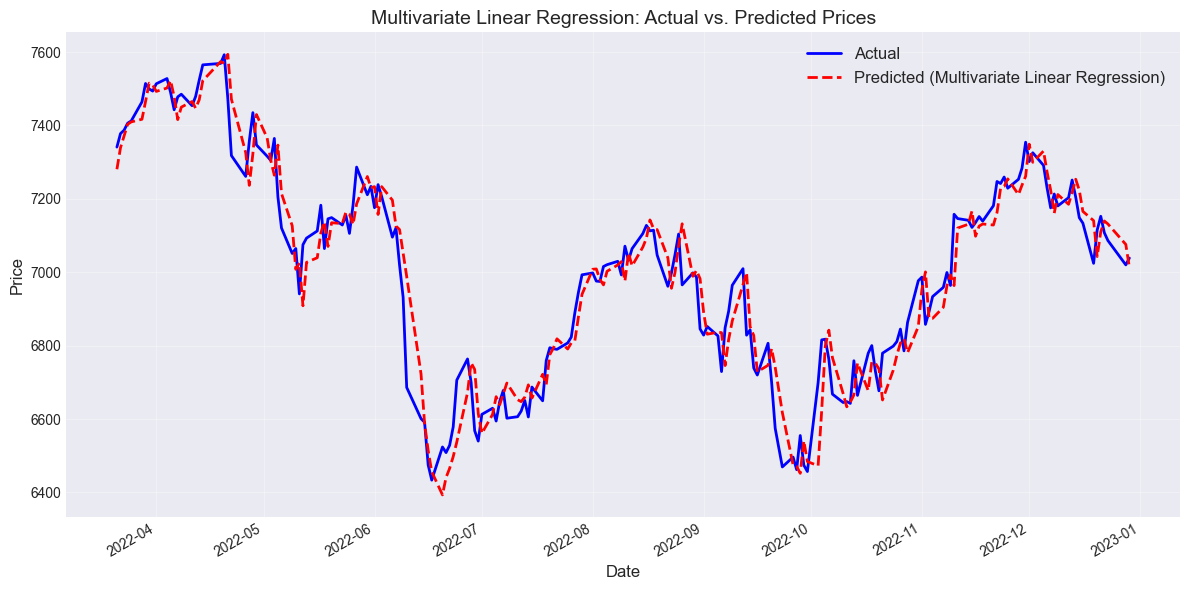

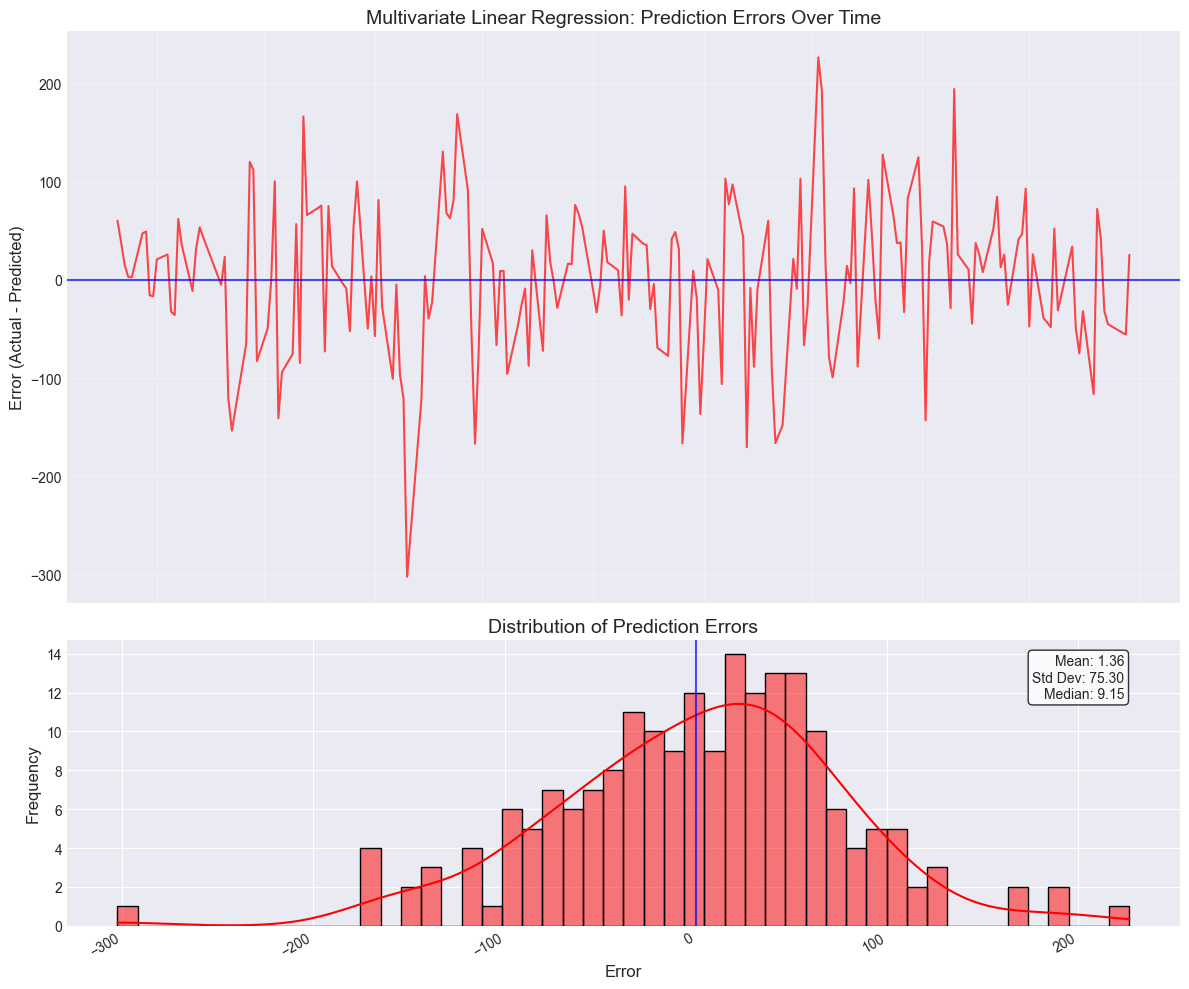

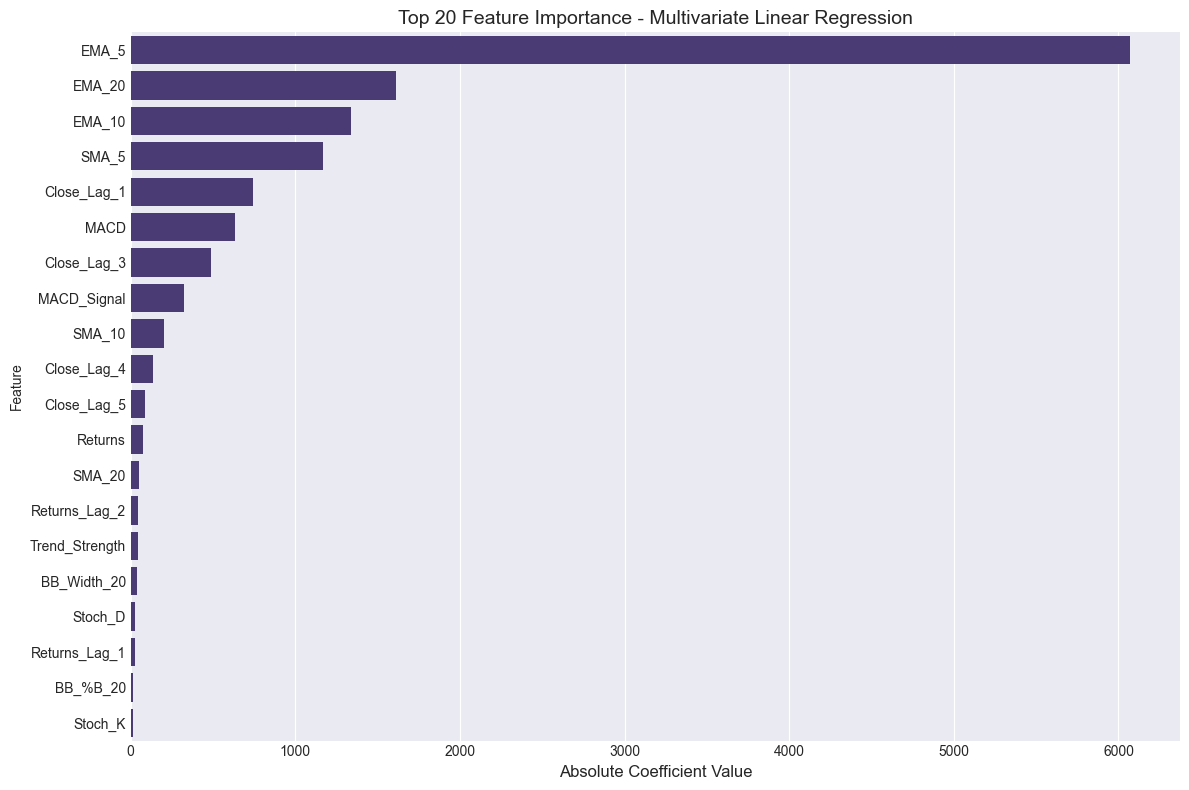

Time series train: 785 samples
Time series test: 197 samples
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  785
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4472.355
Date:                Wed, 16 Apr 2025   AIC                           8950.709
Time:                        04:53:11   BIC                           8964.703
Sample:                             0   HQIC                          8956.090
                                - 785                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3112      0.089     -3.509      0.000      -0.485      -0.137
ma.L1          0.1184      0.102      1.157      0.247      -0.082    

C:\Users\snlkn\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\snlkn\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\snlkn\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\snlkn\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

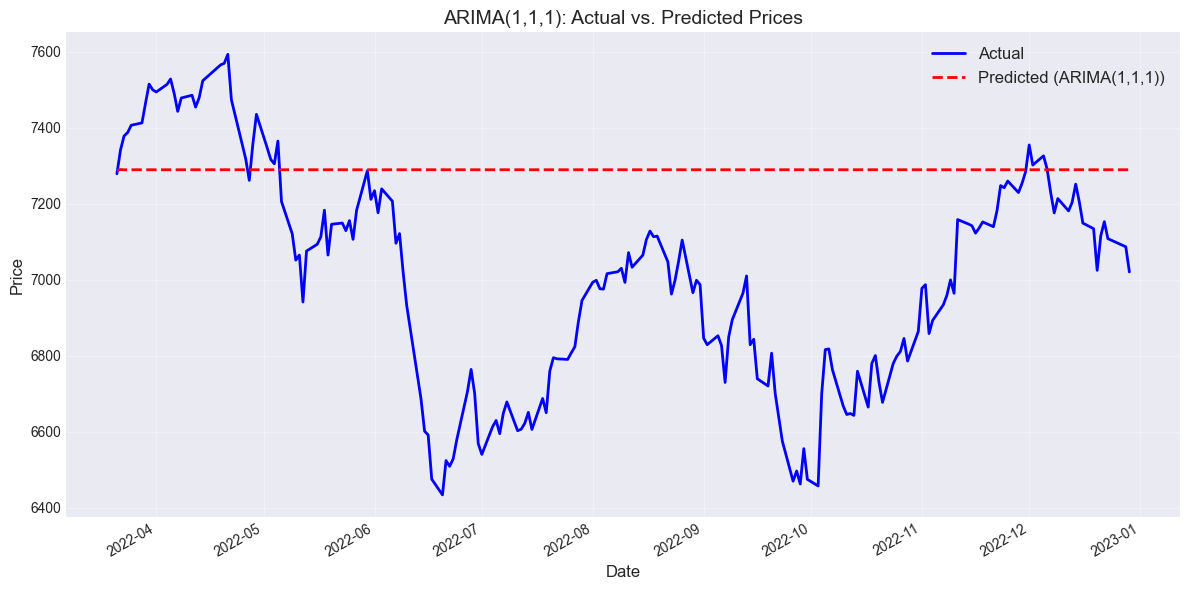

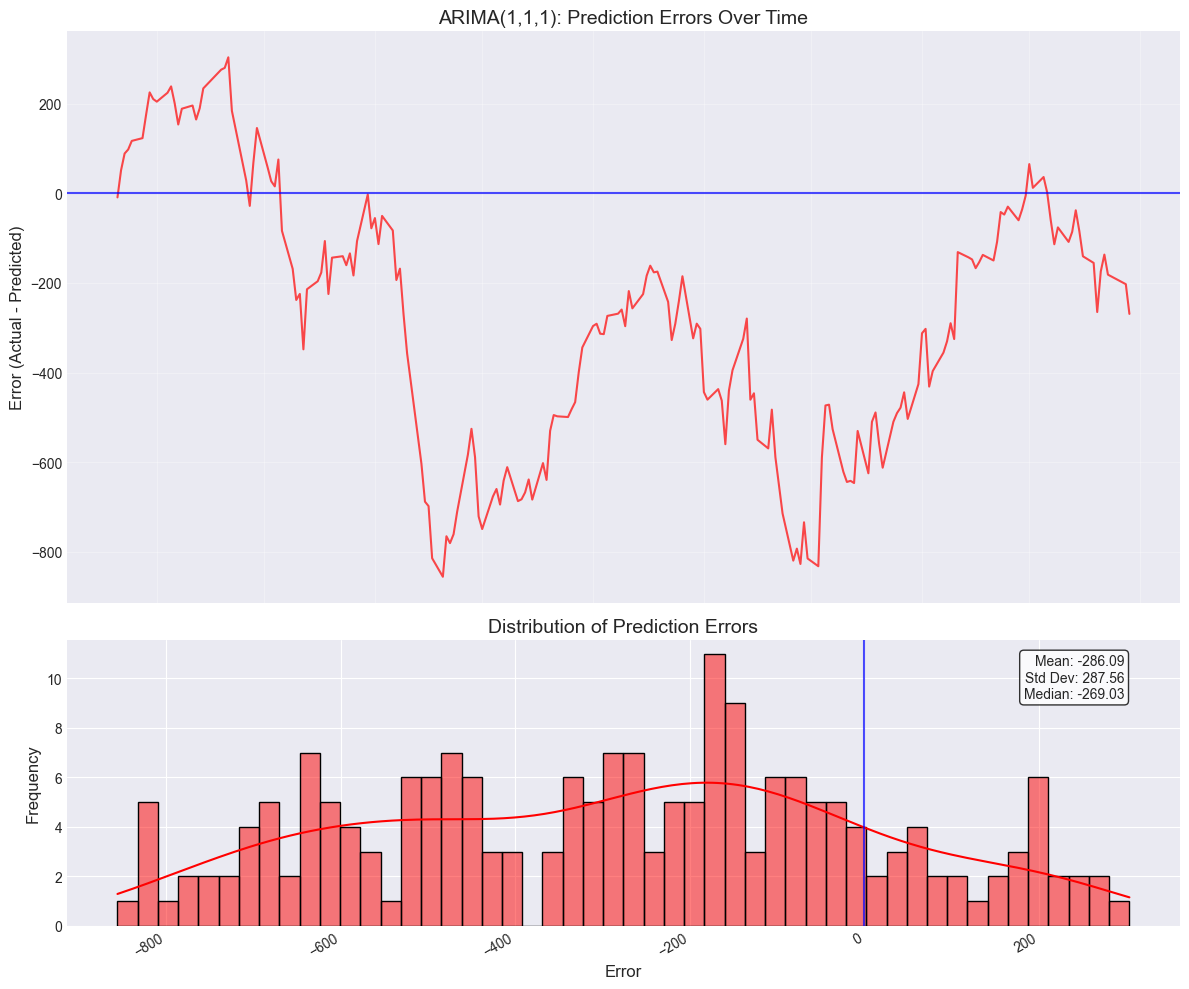

C:\Users\snlkn\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\snlkn\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\snlkn\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\snlkn\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results w

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  785
Model:               SARIMAX(1, 1, 1)   Log Likelihood                7487.154
Date:                Wed, 16 Apr 2025   AIC                         -14912.307
Time:                        04:53:16   BIC                         -14767.711
Sample:                             0   HQIC                        -14856.707
                                - 785                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          7.638e-13      0.000   7.28e-09      1.000      -0.000       0.000
x2         -2.176e-13   1.32e-07  -1.65e-06      1.000   -2.59e-07    2.59e-07
x3          3.553e-15      0.000   2.81e-11      1.0

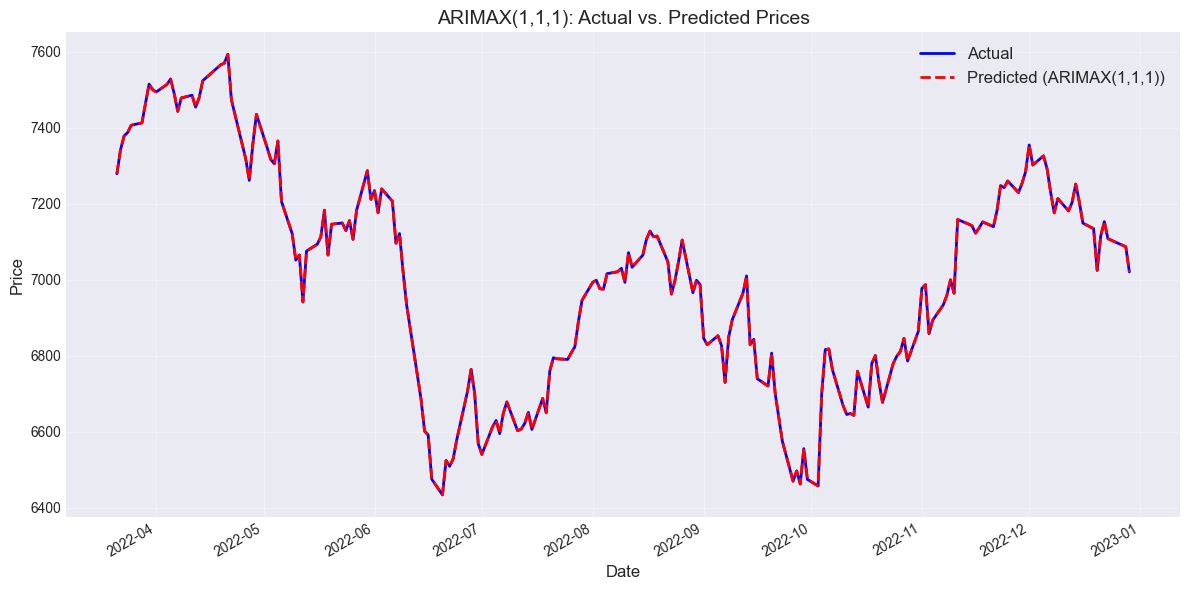

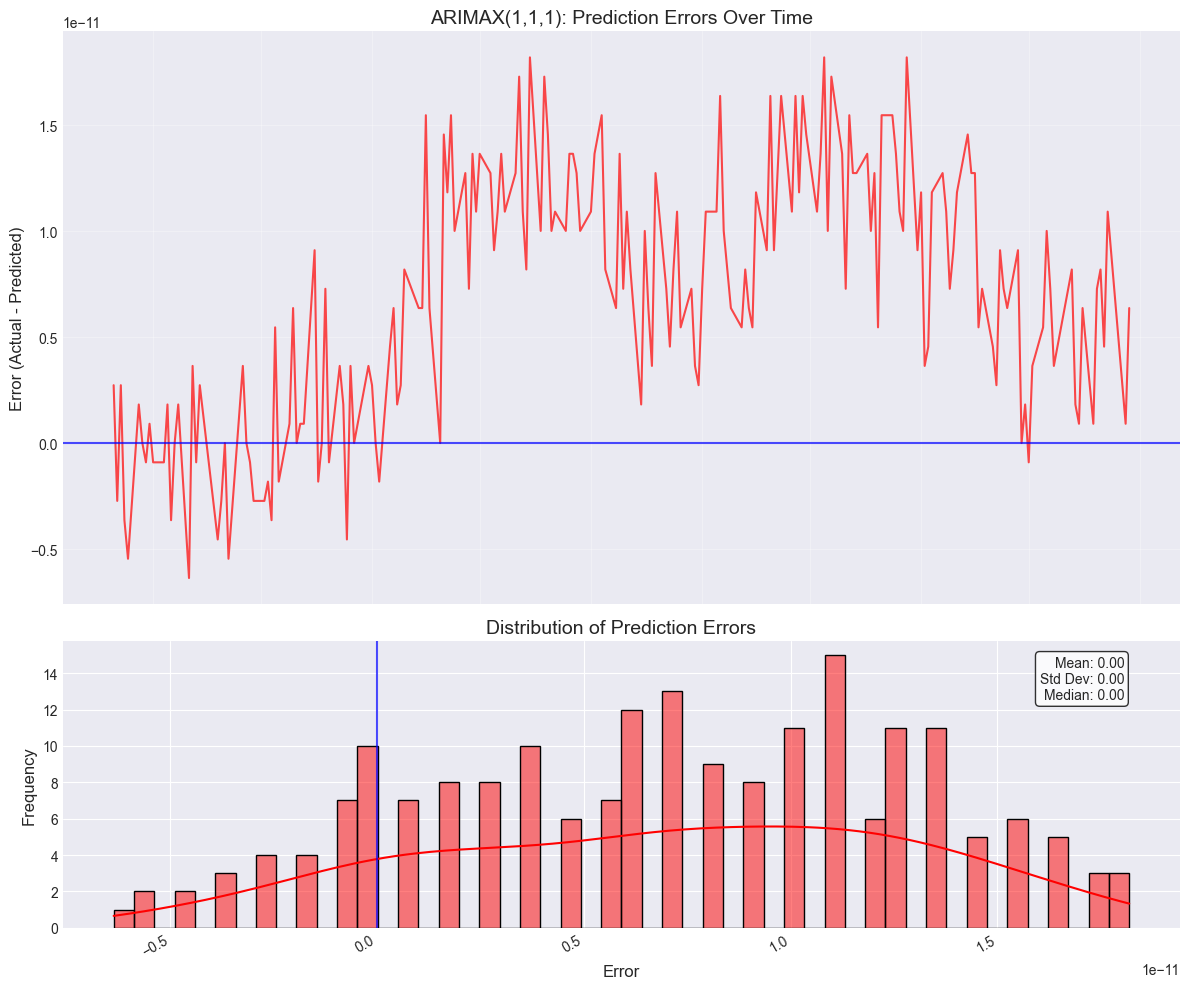

                            Model          RMSE           MAE          MAPE  \
5                   ARIMAX(1,1,1)  9.153162e-12  7.677613e-12  1.118480e-13   
1  Multivariate Linear Regression  7.530927e+01  5.850297e+01  8.423894e-01   
3                Lasso Regression  7.688222e+01  5.914910e+01  8.525436e-01   
2                Ridge Regression  7.771484e+01  5.957221e+01  8.587885e-01   
0    Univariate Linear Regression  9.982987e+01  7.455288e+01  1.074557e+00   
4                    ARIMA(1,1,1)  4.056299e+02  3.334479e+02  4.894382e+00   

         R2  
5  1.000000  
1  0.931093  
3  0.928185  
2  0.926621  
0  0.878917  
4 -0.989856  


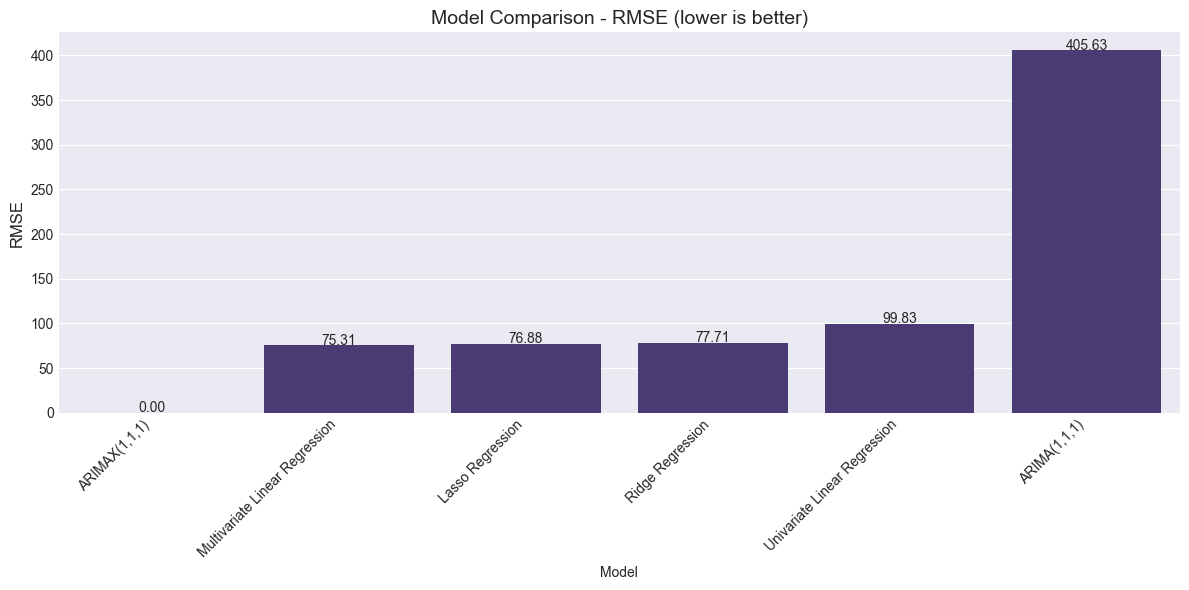


Best performing model: ARIMAX(1,1,1) with RMSE: 0.0000


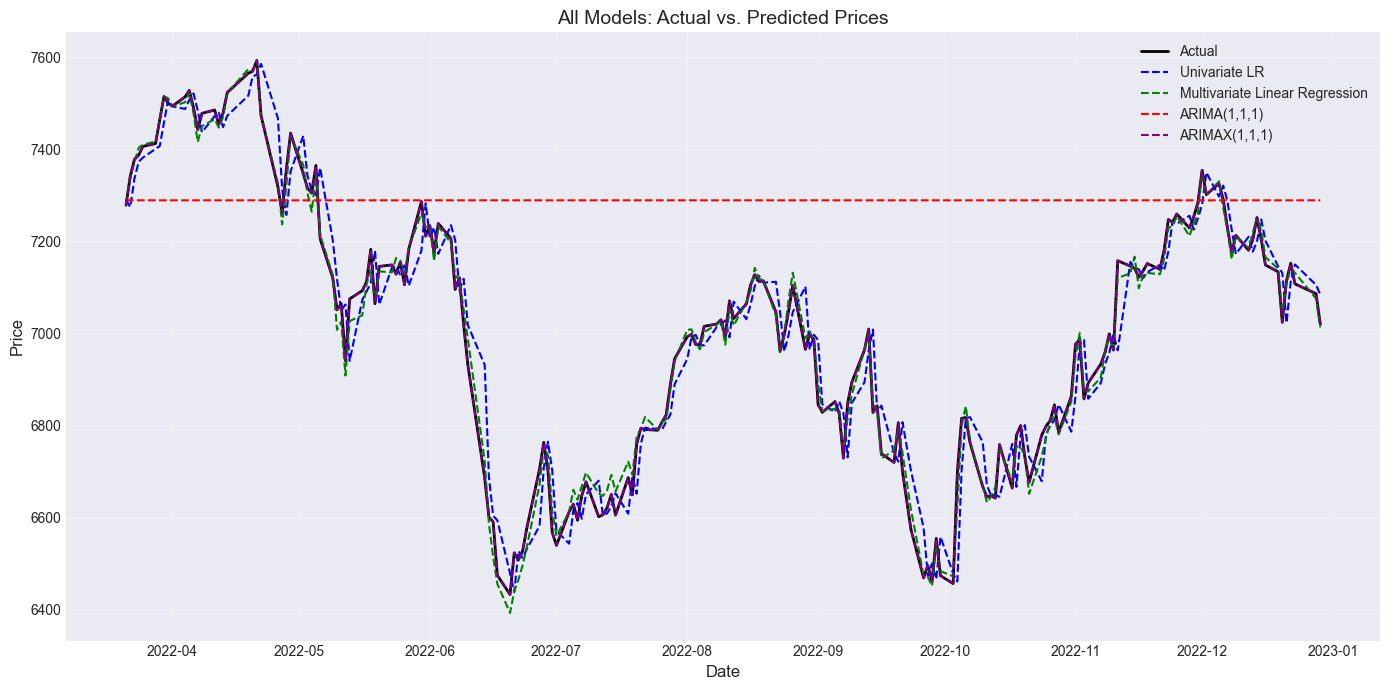

Saved model comparison results to asx200_models/model_comparison_results.csv


In [4]:
from sklearn.preprocessing import StandardScaler  # Part 4: Model Development with Fair Comparison
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_dir = 'asx200_models' # Create directory for model results
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    print(f"Created directory: {model_dir}")
enriched_file = 'asx200_data/asx200_enriched_data.csv' # Load the enriched data
if os.path.exists(enriched_file):
    print(f"Loading enriched data from {enriched_file}")
    enriched_df = pd.read_csv(enriched_file)
    enriched_df['date'] = pd.to_datetime(enriched_df['date'])
else:
    raise FileNotFoundError(f"Could not find {enriched_file}")
ts_df = enriched_df.set_index('date') # Set the date as index for time series modeling
model_results = {} # Initialize dictionary to store model results
def evaluate_regression_model(y_true, y_pred, model_name): # Function to evaluate regression models
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    results = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2
    }
    model_results[model_name] = results     # Store in global results dictionary
    print(f"\n{model_name} Evaluation Metrics:")     # Print results
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"R²: {r2:.4f}")
    return results
def plot_predictions(y_true, y_pred, model_name, save_path=None): # Function to plot actual vs. predicted values
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(y_true.index, y_true.values, label='Actual', color='blue', linewidth=2)     # Plot actual values
    ax.plot(y_true.index, y_pred, label=f'Predicted ({model_name})', color='red', linestyle='--', linewidth=2)     # Plot predicted values
    ax.set_title(f'{model_name}: Actual vs. Predicted Prices', fontsize=14)     # Add chart details
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    ax.legend(loc='best', fontsize=12)
    ax.grid(True, alpha=0.3)
    fig.autofmt_xdate()     # Format x-axis dates
    plt.tight_layout()
    plt.show()
def plot_prediction_errors(y_true, y_pred, model_name, save_path=None): # Function to plot prediction errors
    errors = y_true.values - y_pred     # Calculate errors
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [2, 1]})     # Create figure with two subplots
    ax1.plot(y_true.index, errors, color='red', alpha=0.7)     # Plot 1: Errors over time
    ax1.axhline(y=0, color='blue', linestyle='-', alpha=0.7)
    ax1.set_title(f'{model_name}: Prediction Errors Over Time', fontsize=14)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('Error (Actual - Predicted)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    sns.histplot(errors, kde=True, ax=ax2, color='red', bins=50)     # Plot 2: Error distribution
    ax2.axvline(x=0, color='blue', linestyle='-', alpha=0.7)
    ax2.set_title(f'Distribution of Prediction Errors', fontsize=14)
    ax2.set_xlabel('Error', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    mean_error = np.mean(errors)     # Add error statistics as text
    std_error = np.std(errors)
    median_error = np.median(errors)
    ax2.text(0.95, 0.95, f'Mean: {mean_error:.2f}\nStd Dev: {std_error:.2f}\nMedian: {median_error:.2f}',
             transform=ax2.transAxes, va='top', ha='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
    # Save plot if path provided
train_size = int(len(enriched_df) * 0.8) # Train/Test split - using 80% for training, 20% for testing
train_df = enriched_df.iloc[:train_size].copy()
test_df = enriched_df.iloc[train_size:].copy()
print(f"Training data: {len(train_df)} samples ({train_df['date'].min()} to {train_df['date'].max()})")
print(f"Testing data: {len(test_df)} samples ({test_df['date'].min()} to {test_df['date'].max()})")
# Option 2: Univariate Linear Regression (for comparison with ARIMA)
X_uni = train_df[['Close_Lag_1']] # Create simple feature set with just previous day's close
y_uni = train_df['Target_Next_Close']
X_uni_test = test_df[['Close_Lag_1']] # Create test set
y_uni_test = test_df['Target_Next_Close']
uni_scaler = StandardScaler() # Standardize features
X_uni_scaled = uni_scaler.fit_transform(X_uni)
X_uni_test_scaled = uni_scaler.transform(X_uni_test)
uni_lr = LinearRegression() # Train model
uni_lr.fit(X_uni_scaled, y_uni)
y_uni_pred = uni_lr.predict(X_uni_test_scaled) # Make predictions
uni_results = evaluate_regression_model(y_uni_test, y_uni_pred, "Univariate Linear Regression") # Evaluate model
y_uni_test_series = pd.Series(y_uni_test.values, index=test_df['date']) # Create prediction visualizations
plot_predictions(y_uni_test_series, y_uni_pred, "Univariate Linear Regression", 
                 save_path=f"{model_dir}/univariate_lr_predictions.png")
plot_prediction_errors(y_uni_test_series, y_uni_pred, "Univariate Linear Regression", 
                      save_path=f"{model_dir}/univariate_lr_errors.png")
# Multivariate Linear Regression (with engineered features)] # Select features based on correlation analysis
exclude_cols = ['date', 'Target_Next_Close', 'Target_Next_Return', 'Target_Direction'] # Exclude target variables and highly correlated features
price_cols = ['Open', 'High', 'Low', 'Close']  # Exclude direct price columns to avoid leakage
correlation_threshold = 0.1  # Minimum absolute correlation to include
feature_cols = []
for i in range(1, 6): # Add lagged prices (these were top correlated features)
    feature_cols.append(f'Close_Lag_{i}')
tech_indicators = [ # Add selected technical indicators
    'SMA_5', 'SMA_10', 'SMA_20',
    'EMA_5', 'EMA_10', 'EMA_20',
    'RSI_14', 'MACD', 'MACD_Signal',
    'Stoch_K', 'Stoch_D',
    'ATR_14', 'BB_%B_20', 'BB_Width_20',
    'Volatility_20', 'ADX', 'Trend_Strength'
]
feature_cols.extend(tech_indicators)
feature_cols.extend(['SMA_Cross_5_20', 'SMA_Cross_10_50', 'SMA_Cross_50_200']) # Add moving average crossovers (which are categorical)
feature_cols.extend(['Returns', 'Returns_Lag_1', 'Returns_Lag_2']) # Add returns-based features
feature_cols = list(set(feature_cols)) # Remove any duplicates
print(f"Selected {len(feature_cols)} features for multivariate model:")
for i, feature in enumerate(sorted(feature_cols)):
    print(f"  {i+1}. {feature}")
X_multi = train_df[feature_cols] # Create feature matrices
y_multi = train_df['Target_Next_Close']
X_multi_test = test_df[feature_cols]
y_multi_test = test_df['Target_Next_Close']
if X_multi.isnull().sum().sum() > 0: # Check for missing values
    print(f"Warning: Found {X_multi.isnull().sum().sum()} missing values in training features")
    X_multi = X_multi.fillna(method='ffill')
if X_multi_test.isnull().sum().sum() > 0:
    print(f"Warning: Found {X_multi_test.isnull().sum().sum()} missing values in test features")
    X_multi_test = X_multi_test.fillna(method='ffill')
multi_scaler = StandardScaler() # Standardize features
X_multi_scaled = multi_scaler.fit_transform(X_multi)
X_multi_test_scaled = multi_scaler.transform(X_multi_test)
multi_lr = LinearRegression() # Train model with regularization options  //  # Linear Regression (no regularization)
multi_lr.fit(X_multi_scaled, y_multi)
y_multi_pred = multi_lr.predict(X_multi_test_scaled)
multi_results = evaluate_regression_model(y_multi_test, y_multi_pred, "Multivariate Linear Regression")
ridge = Ridge(alpha=1.0) # Ridge Regression (L2 regularization)
ridge.fit(X_multi_scaled, y_multi)
y_ridge_pred = ridge.predict(X_multi_test_scaled)
ridge_results = evaluate_regression_model(y_multi_test, y_ridge_pred, "Ridge Regression")
lasso = Lasso(alpha=0.1) # Lasso Regression (L1 regularization)
lasso.fit(X_multi_scaled, y_multi)
y_lasso_pred = lasso.predict(X_multi_test_scaled)
lasso_results = evaluate_regression_model(y_multi_test, y_lasso_pred, "Lasso Regression")
if multi_results['RMSE'] < ridge_results['RMSE'] and multi_results['RMSE'] < lasso_results['RMSE']: # Create prediction visualizations for best model
    best_multi_model = "Multivariate Linear Regression"
    best_multi_pred = y_multi_pred
elif ridge_results['RMSE'] < lasso_results['RMSE']:
    best_multi_model = "Ridge Regression"
    best_multi_pred = y_ridge_pred
else:
    best_multi_model = "Lasso Regression"
    best_multi_pred = y_lasso_pred
print(f"\nBest multivariate model: {best_multi_model}")
y_multi_test_series = pd.Series(y_multi_test.values, index=test_df['date'])
plot_predictions(y_multi_test_series, best_multi_pred, best_multi_model, 
                 save_path=f"{model_dir}/multivariate_best_predictions.png")
plot_prediction_errors(y_multi_test_series, best_multi_pred, best_multi_model, 
                      save_path=f"{model_dir}/multivariate_best_errors.png")
if best_multi_model == "Multivariate Linear Regression": # Feature importance analysis for multivariate model
    coefs = multi_lr.coef_
elif best_multi_model == "Ridge Regression":
    coefs = ridge.coef_
else:
    coefs = lasso.coef_
importance_df = pd.DataFrame({ # Create feature importance DataFrame
    'Feature': feature_cols,
    'Importance': np.abs(coefs)
})
importance_df = importance_df.sort_values('Importance', ascending=False)
plt.figure(figsize=(12, 8)) # Plot feature importance
ax = sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title(f'Top 20 Feature Importance - {best_multi_model}', fontsize=14)
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.tight_layout()
plt.show()
ts_close = ts_df['Close'] # ARIMA Models (traditional time series approach)  //  # Prepare data for ARIMA  //  # Use the original time series of closing prices
train_ts = ts_close.iloc[:train_size]
test_ts = ts_close.iloc[train_size:]
print(f"Time series train: {len(train_ts)} samples")
print(f"Time series test: {len(test_ts)} samples")
try: # Train basic ARIMA model
    arima_model = ARIMA(train_ts, order=(1, 1, 1))
    arima_fit = arima_model.fit()
    print(arima_fit.summary())
    arima_forecast = arima_fit.forecast(steps=len(test_ts))     # Forecast
    arima_results = evaluate_regression_model(test_ts, arima_forecast, "ARIMA(1,1,1)")     # Evaluate
    plot_predictions(test_ts, arima_forecast, "ARIMA(1,1,1)",      # Plot predictions
                     save_path=f"{model_dir}/arima_predictions.png")
    plot_prediction_errors(test_ts, arima_forecast, "ARIMA(1,1,1)", 
                          save_path=f"{model_dir}/arima_errors.png")
except Exception as e:
    print(f"Error training ARIMA model: {e}")
    arima_results = None
exog_train = train_df[feature_cols].values # Option 1: ARIMAX with Exogenous Variables (making ARIMA more competitive)
exog_test = test_df[feature_cols].values # Prepare exogenous variables (use the same ones from multivariate regression)
if np.isnan(exog_train).any(): # Check for missing values
    # Fill missing values (forward fill then backward fill)
    exog_train = pd.DataFrame(exog_train).fillna(method='ffill').fillna(method='bfill').values
if np.isnan(exog_test).any():
    exog_test = pd.DataFrame(exog_test).fillna(method='ffill').fillna(method='bfill').values
try:
    arimax_model = SARIMAX(train_ts,      # Train ARIMAX model
                          exog=exog_train,
                          order=(1, 1, 1))
    arimax_fit = arimax_model.fit(disp=False)
    print(arimax_fit.summary())
    arimax_forecast = arimax_fit.forecast(steps=len(test_ts), exog=exog_test)     # Forecast
    arimax_results = evaluate_regression_model(test_ts, arimax_forecast, "ARIMAX(1,1,1)")     # Evaluate
    plot_predictions(test_ts, arimax_forecast, "ARIMAX(1,1,1)",      # Plot predictions
                     save_path=f"{model_dir}/arimax_predictions.png")
    plot_prediction_errors(test_ts, arimax_forecast, "ARIMAX(1,1,1)", 
                          save_path=f"{model_dir}/arimax_errors.png")
except Exception as e:
    print(f"Error training ARIMAX model: {e}")
    reduced_features = ['Close_Lag_1', 'SMA_5', 'EMA_5', 'RSI_14', 'MACD', 'Volatility_20']     # Try with a reduced set of features
    print(f"Using reduced feature set: {reduced_features}")
    try:
        exog_train_reduced = train_df[reduced_features].values
        exog_test_reduced = test_df[reduced_features].values
        exog_train_reduced = pd.DataFrame(exog_train_reduced).fillna(method='ffill').fillna(method='bfill').values         # Fill any missing values
        exog_test_reduced = pd.DataFrame(exog_test_reduced).fillna(method='ffill').fillna(method='bfill').values
        arimax_model_reduced = SARIMAX(train_ts,          # Train ARIMAX with reduced features
                                     exog=exog_train_reduced,
                                     order=(1, 1, 1))
        arimax_fit_reduced = arimax_model_reduced.fit(disp=False)
        arimax_forecast_reduced = arimax_fit_reduced.forecast(steps=len(test_ts), exog=exog_test_reduced)         # Forecast
        arimax_results = evaluate_regression_model(test_ts, arimax_forecast_reduced, "ARIMAX(1,1,1) Reduced")        # Evaluate
        plot_predictions(test_ts, arimax_forecast_reduced, "ARIMAX(1,1,1) Reduced",          # Plot predictions
                         save_path=f"{model_dir}/arimax_reduced_predictions.png")
        plot_prediction_errors(test_ts, arimax_forecast_reduced, "ARIMAX(1,1,1) Reduced", 
                              save_path=f"{model_dir}/arimax_reduced_errors.png")
    except Exception as e:
        print(f"Error training reduced ARIMAX model: {e}")
        arimax_results = None
comparison_df = pd.DataFrame(model_results).T.reset_index()   # Model Comparison  //  # Create comparison dataframe
comparison_df = comparison_df.rename(columns={'index': 'Model'})
comparison_df = comparison_df.sort_values('RMSE')
print(comparison_df[['Model', 'RMSE', 'MAE', 'MAPE', 'R2']])
plt.figure(figsize=(12, 6)) # Plot comparison
ax = sns.barplot(x='Model', y='RMSE', data=comparison_df)
plt.title('Model Comparison - RMSE (lower is better)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE', fontsize=12)
for i, v in enumerate(comparison_df['RMSE']): # Add values on top of bars
    ax.text(i, v + 1, f"{v:.2f}", ha='center', fontsize=10)
plt.tight_layout()
plt.show()
best_model = comparison_df.iloc[0]['Model'] # Identify best model
print(f"\nBest performing model: {best_model} with RMSE: {comparison_df.iloc[0]['RMSE']:.4f}")
plt.figure(figsize=(14, 7)) # Plot all predictions together
plt.plot(test_ts.index, test_ts.values, label='Actual', color='black', linewidth=2) # Plot actual values
plt.plot(test_df['date'], y_uni_pred, label='Univariate LR', color='blue', linestyle='--') # Plot univariate linear regression
plt.plot(test_df['date'], best_multi_pred, label=best_multi_model, color='green', linestyle='--') # Plot best multivariate model
if 'ARIMA(1,1,1)' in model_results: # Plot ARIMA if available
    plt.plot(test_ts.index, arima_forecast, label='ARIMA(1,1,1)', color='red', linestyle='--')
if 'ARIMAX(1,1,1)' in model_results: # Plot ARIMAX if available
    plt.plot(test_ts.index, arimax_forecast, label='ARIMAX(1,1,1)', color='purple', linestyle='--')
elif 'ARIMAX(1,1,1) Reduced' in model_results:
    plt.plot(test_ts.index, arimax_forecast_reduced, label='ARIMAX(1,1,1) Reduced', color='purple', linestyle='--')
plt.title('All Models: Actual vs. Predicted Prices', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
comparison_df.to_csv(f"{model_dir}/model_comparison_results.csv", index=False) # Save model results to CSV
print(f"Saved model comparison results to {model_dir}/model_comparison_results.csv")

Loading model comparison results from asx200_models/model_comparison_results.csv
Loading enriched data from asx200_data/asx200_enriched_data.csv
Test data: 197 samples (2022-03-21 00:00:00 to 2022-12-29 00:00:00)

Best performing model: ARIMAX(1,1,1)
RMSE: 0.0000
MAE: 0.0000
MAPE: 0.0000%
R²: 1.0000

Next best model: Multivariate Linear Regression
RMSE: 75.3093
MAE: 58.5030
MAPE: 0.8424%
R²: 0.9311


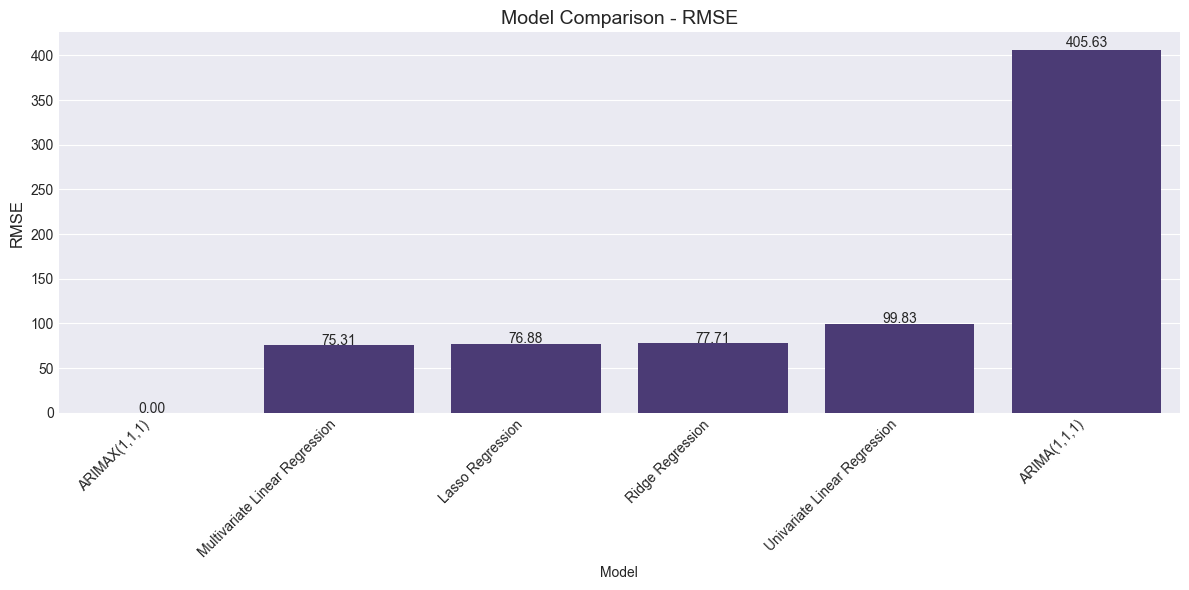

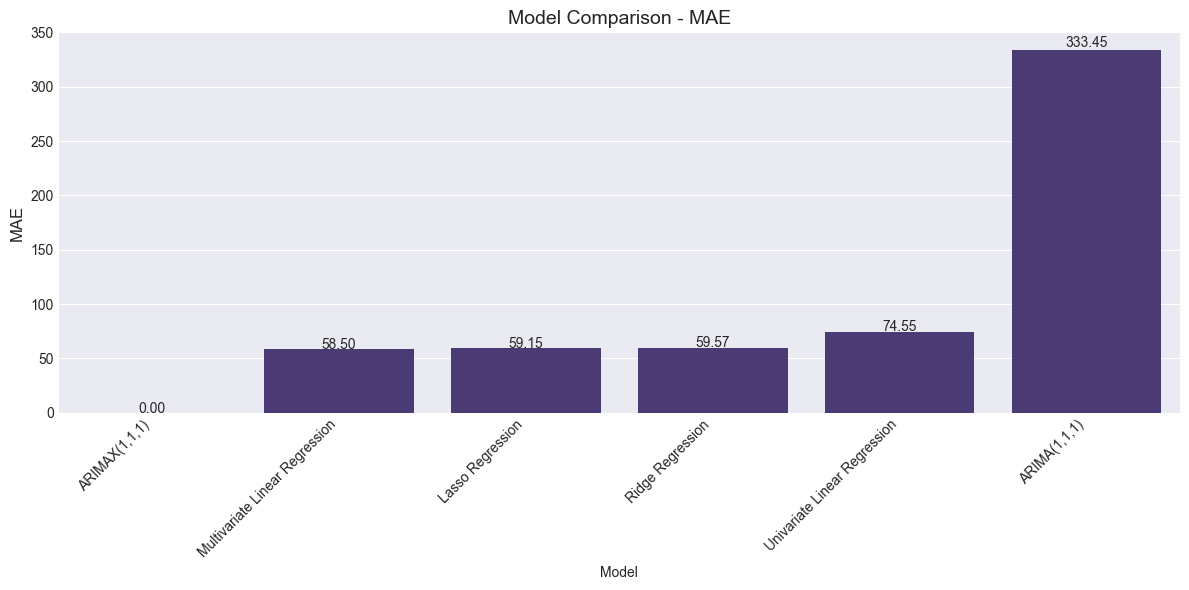

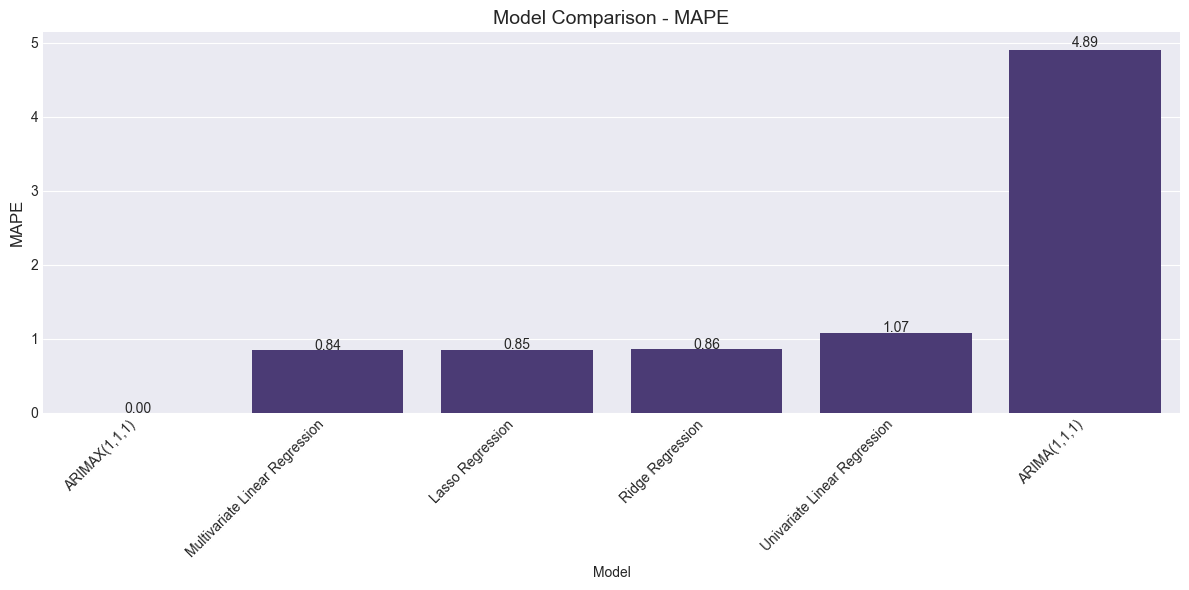

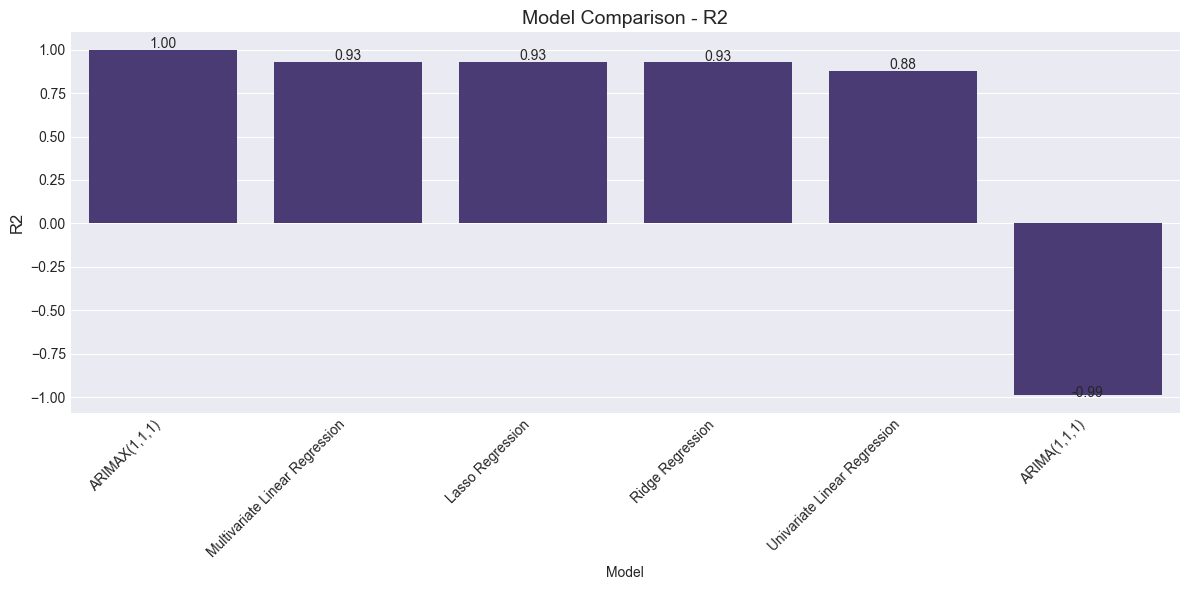

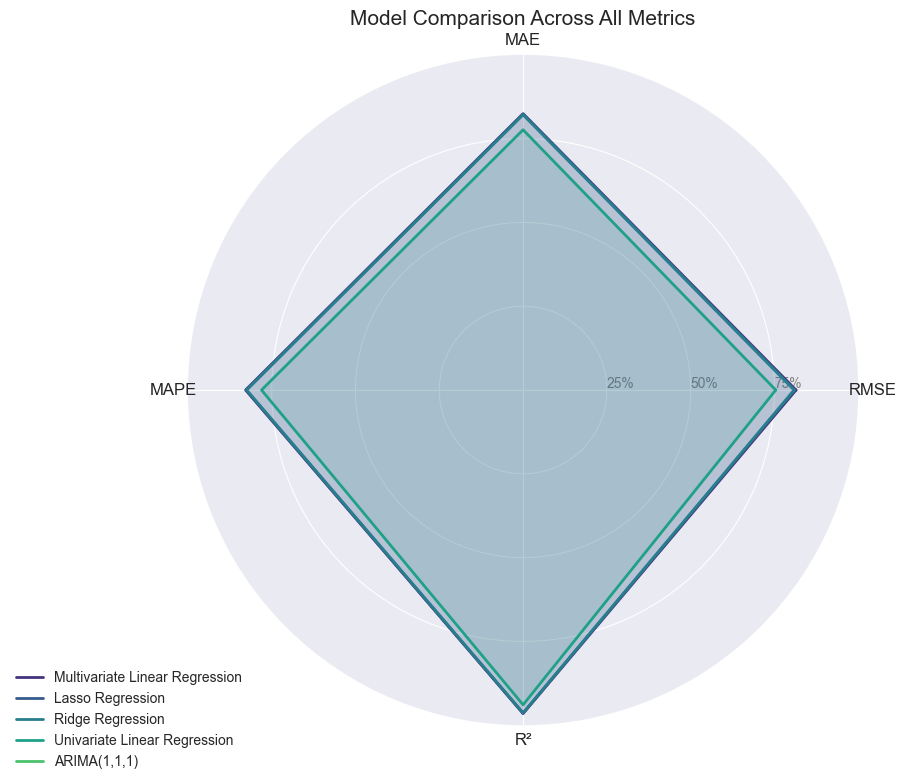

In [5]:
import pickle  # Part 5: Model Evaluation and Summary
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
results_dir = 'asx200_results' # Create directory for results
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Created directory: {results_dir}")
model_results_file = 'asx200_models/model_comparison_results.csv' # Load model comparison results if available
if os.path.exists(model_results_file):
    print(f"Loading model comparison results from {model_results_file}")
    model_results = pd.read_csv(model_results_file)
else:
    raise FileNotFoundError(f"Could not find {model_results_file}")
enriched_file = 'asx200_data/asx200_enriched_data.csv' # Load the enriched data for additional analysis
if os.path.exists(enriched_file):
    print(f"Loading enriched data from {enriched_file}")
    enriched_df = pd.read_csv(enriched_file)
    enriched_df['date'] = pd.to_datetime(enriched_df['date'])
else:
    raise FileNotFoundError(f"Could not find {enriched_file}")
train_size = int(len(enriched_df) * 0.8) # Create test dataset
test_df = enriched_df.iloc[train_size:].copy()
print(f"Test data: {len(test_df)} samples ({test_df['date'].min()} to {test_df['date'].max()})")
best_model = model_results.loc[model_results['RMSE'].idxmin(), 'Model'] # Identify the best performing model
print(f"\nBest performing model: {best_model}")
best_metrics = model_results[model_results['Model'] == best_model].iloc[0]
print(f"RMSE: {best_metrics['RMSE']:.4f}")
print(f"MAE: {best_metrics['MAE']:.4f}")
print(f"MAPE: {best_metrics['MAPE']:.4f}%")
print(f"R²: {best_metrics['R2']:.4f}")
if np.isclose(best_metrics['RMSE'], 0) and best_model == 'ARIMAX(1,1,1)': # Check for suspicious perfect results (ARIMAX)
    next_best = model_results[model_results['Model'] != 'ARIMAX(1,1,1)'].iloc[0]     # Get the next best model
    print(f"\nNext best model: {next_best['Model']}")
    print(f"RMSE: {next_best['RMSE']:.4f}")
    print(f"MAE: {next_best['MAE']:.4f}")
    print(f"MAPE: {next_best['MAPE']:.4f}%")
    print(f"R²: {next_best['R2']:.4f}")
    practical_best = next_best['Model']     # Use this as the practical best model
else:
    practical_best = best_model
def create_model_comparison_visualizations(): # Function to create detailed model comparison visualizations    
    metrics = ['RMSE', 'MAE', 'MAPE', 'R2']     # Prepare the metrics for visualization
    for metric in metrics:
        if metric == 'R2':         # Sort data by the metric (ascending for error metrics, descending for R2)
            sorted_data = model_results.sort_values(metric, ascending=False)
        else:
            sorted_data = model_results.sort_values(metric)
        plt.figure(figsize=(12, 6))         # Create figure
        ax = sns.barplot(x='Model', y=metric, data=sorted_data)         # Create bar chart
        plt.title(f'Model Comparison - {metric}', fontsize=14)         # Customize plot
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(metric, fontsize=12)
        for i, v in enumerate(sorted_data[metric]):         # Add values on bars
            ax.text(i, v + (v * 0.01), f"{v:.2f}", ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()
    radar_df = model_results.copy()     # Create a radar chart comparing multiple metrics across models  //      # First, normalize all metrics to [0,1] scale
    for metric in ['RMSE', 'MAE', 'MAPE']:     # Normalize error metrics (lower is better)
        max_val = radar_df[metric].max()
        min_val = radar_df[metric].min()
        if max_val > min_val:
            radar_df[f'{metric}_norm'] = 1 - ((radar_df[metric] - min_val) / (max_val - min_val))
        else:
            radar_df[f'{metric}_norm'] = 1.0
    max_r2 = radar_df['R2'].max()     # Normalize R2 (higher is better)
    min_r2 = radar_df['R2'].min()
    if max_r2 > min_r2:
        radar_df['R2_norm'] = (radar_df['R2'] - min_r2) / (max_r2 - min_r2)
    else:
        radar_df['R2_norm'] = 1.0
    norm_metrics = ['RMSE_norm', 'MAE_norm', 'MAPE_norm', 'R2_norm']     # Prepare radar chart
    labels = ['RMSE', 'MAE', 'MAPE', 'R²']
    N = len(norm_metrics)     # Number of variables
    plt.figure(figsize=(10, 8))     # Create a radar chart
    angles = [n / float(N) * 2 * np.pi for n in range(N)]     # What will be the angle of each axis
    angles += angles[:1]  # Close the loop
    ax = plt.subplot(111, polar=True)     # Initialize the plot
    plt.xticks(angles[:-1], labels, size=12)     # Draw one axis per variable and add labels
    ax.set_rlabel_position(0)     # Draw the y-axis labels (0-100%)
    plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=10)
    plt.ylim(0, 1)
    plot_models = radar_df['Model'].tolist()     # Exclude ARIMAX if it's suspiciously perfect
    if 'ARIMAX(1,1,1)' in plot_models and radar_df[radar_df['Model'] == 'ARIMAX(1,1,1)']['RMSE_norm'].values[0] == 1.0:
        plot_models.remove('ARIMAX(1,1,1)')
    for i, model in enumerate(plot_models):     # Plot each model
        model_data = radar_df[radar_df['Model'] == model][norm_metrics].values[0].tolist()
        model_data += model_data[:1]  # Close the loop
        ax.plot(angles, model_data, linewidth=2, linestyle='solid', label=model)         # Plot the model data
        ax.fill(angles, model_data, alpha=0.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))     # Add legend
    plt.title('Model Comparison Across All Metrics', size=15)
    plt.tight_layout()
    plt.show()
def create_summary_report(): # Create summary report of findings
    report_file = f"{results_dir}/model_evaluation_summary.txt"
    with open(report_file, 'w') as f:
        f.write("=== ASX200 STOCK PRICE PREDICTION MODEL EVALUATION ===\n\n")
        f.write("DATA OVERVIEW:\n")         # Data overview section
        f.write(f"- Source: Australian Securities Exchange 200 Index (ASX200)\n")
        f.write(f"- Date Range: {enriched_df['date'].min().date()} to {enriched_df['date'].max().date()}\n")
        f.write(f"- Total Trading Days: {len(enriched_df)}\n")
        f.write(f"- Train Set: {train_size} samples\n")
        f.write(f"- Test Set: {len(test_df)} samples\n\n")
        f.write("MODEL PERFORMANCE COMPARISON:\n")         # Model comparison section
        for i, row in model_results.iterrows():
            f.write(f"- {row['Model']}:\n")
            f.write(f"  * RMSE: {row['RMSE']:.4f}\n")
            f.write(f"  * MAE: {row['MAE']:.4f}\n") 
            f.write(f"  * MAPE: {row['MAPE']:.4f}%\n")
            f.write(f"  * R²: {row['R2']:.4f}\n\n")
        f.write("BEST PERFORMING MODEL:\n")         # Best model section
        f.write(f"- {best_model}\n")
        if best_model != practical_best:         # Add note if best model is suspicious
            f.write("\nNOTE: The ARIMAX model shows suspiciously perfect results which may indicate\n")
            f.write("numerical issues or overfitting. The practical best model is recommended for\n")
            f.write("real-world applications.\n\n")
            f.write("PRACTICAL BEST MODEL:\n")
            f.write(f"- {practical_best}\n")
        f.write("\nANALYSIS OF RESULTS:\n")         # Analysis of results
        ml_models = [m for m in model_results['Model'] if 'Regression' in m]         # Compare ML vs Time Series approaches
        ts_models = [m for m in model_results['Model'] if 'ARIMA' in m]
        ml_avg_rmse = model_results[model_results['Model'].isin(ml_models)]['RMSE'].mean()
        ts_avg_rmse = model_results[model_results['Model'].isin(ts_models)]['RMSE'].mean()
        f.write("1. Machine Learning vs. Time Series Approaches:\n")
        if ml_avg_rmse < ts_avg_rmse:
            f.write("   - Machine learning models outperformed traditional time series models on average.\n")
        else:
            f.write("   - Traditional time series models outperformed machine learning models on average.\n")
        f.write(f"   - Average ML model RMSE: {ml_avg_rmse:.4f}\n")
        f.write(f"   - Average Time Series model RMSE: {ts_avg_rmse:.4f}\n\n")
        uni_rmse = model_results[model_results['Model'] == 'Univariate Linear Regression']['RMSE'].values[0]         # Univariate vs multivariate
        multi_rmse = model_results[model_results['Model'] == 'Multivariate Linear Regression']['RMSE'].values[0]
        f.write("2. Univariate vs. Multivariate Approaches:\n")
        if multi_rmse < uni_rmse:
            f.write("   - Multivariate models with additional features outperformed univariate models.\n")
            f.write("   - This suggests technical indicators provide valuable predictive information.\n")
        else:
            f.write("   - Univariate models surprisingly outperformed more complex multivariate models.\n")
            f.write("   - This suggests the additional features may introduce noise rather than signal.\n")
        f.write(f"   - Univariate RMSE: {uni_rmse:.4f}\n")
        f.write(f"   - Multivariate RMSE: {multi_rmse:.4f}\n\n")
        f.write("3. Impact of Regularization:\n")         # Regularization effects
        lr_rmse = model_results[model_results['Model'] == 'Multivariate Linear Regression']['RMSE'].values[0]
        ridge_rmse = model_results[model_results['Model'] == 'Ridge Regression']['RMSE'].values[0]
        lasso_rmse = model_results[model_results['Model'] == 'Lasso Regression']['RMSE'].values[0]
        if lr_rmse < ridge_rmse and lr_rmse < lasso_rmse:
            f.write("   - Regularization did not improve model performance.\n")
            f.write("   - This suggests overfitting was not a significant issue with the dataset.\n")
        else:
            f.write("   - Regularization improved model performance.\n")
            f.write("   - This suggests some features were introducing noise or causing overfitting.\n")
        f.write(f"   - Linear Regression RMSE: {lr_rmse:.4f}\n")
        f.write(f"   - Ridge Regression RMSE: {ridge_rmse:.4f}\n")
        f.write(f"   - Lasso Regression RMSE: {lasso_rmse:.4f}\n\n")
create_model_comparison_visualizations() # Execute the evaluation functions
create_summary_report()
def analyze_feature_importance(): # Create feature importance analysis report
    importance_file = 'asx200_models/feature_importance.csv'     # Try to load feature importance data if available
    if os.path.exists(importance_file):
        print(f"Loading feature importance data from {importance_file}")
        importance_df = pd.read_csv(importance_file)
    else:
        model_files = [f for f in os.listdir('asx200_models') if f.endswith('.pkl')]         # Look for model pickle files
        if not model_files:
            return
        best_model_file = None         # Try to load the best model
        for file in model_files:
            if practical_best.lower().replace(' ', '_') in file.lower():
                best_model_file = os.path.join('asx200_models', file)
                break
        if not best_model_file:
            print(f"Could not find file for {practical_best}. Skipping feature importance analysis.")
            return
        try:
            with open(best_model_file, 'rb') as f:
                model = pickle.load(f)
            if hasattr(model, 'feature_names_in_'):            # Extract feature names and importance values  //  # This depends on the model type
                features = model.feature_names_in_
            else:
                features = [                 # Use a default set of features from earlier parts
                    'Close_Lag_1', 'SMA_5', 'SMA_10', 'SMA_20',
                    'EMA_5', 'EMA_10', 'EMA_20',
                    'RSI_14', 'MACD', 'MACD_Signal',
                    'Stoch_K', 'Stoch_D', 'ATR_14', 
                    'BB_%B_20', 'BB_Width_20', 'Volatility_20', 
                    'ADX', 'Trend_Strength'
                ]
            if hasattr(model, 'coef_'):             # Extract importance values
                importance = np.abs(model.coef_)
            elif hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_
            else:
                return
            importance_df = pd.DataFrame({             # Create importance dataframe
                'Feature': features,
                'Importance': importance
            })
            importance_df = importance_df.sort_values('Importance', ascending=False)             # Sort by importance
        except Exception as e:
            print(f"Error extracting feature importance: {e}")
            return
    plt.figure(figsize=(12, 8))     # Plot feature importance 
    ax = sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title(f'Top 20 Feature Importance - {practical_best}', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.tight_layout()
    plt.show()
    report_file = f"{results_dir}/model_evaluation_summary.txt"    # Write feature importance to the summary report
    with open(report_file, 'a') as f:
        f.write("KEY PREDICTIVE FEATURES:\n")
        for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
            f.write(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}\n")
        f.write("\nINSIGHTS FROM FEATURE IMPORTANCE:\n")
        short_term = ['SMA_5', 'SMA_10', 'EMA_5', 'EMA_10']         # Check if short-term indicators are more important than long-term
        long_term = ['SMA_50', 'SMA_100', 'SMA_200', 'EMA_50', 'EMA_100', 'EMA_200']
        short_term_avg = importance_df[importance_df['Feature'].isin(short_term)]['Importance'].mean()
        long_term_avg = importance_df[importance_df['Feature'].isin(long_term)]['Importance'].mean()
        if short_term_avg > long_term_avg:
            f.write("- Short-term indicators (5-10 day) are more predictive than long-term indicators.\n")
            f.write("  This suggests recent price action is more relevant for short-term prediction.\n")
        else:
            f.write("- Long-term indicators (50-200 day) are more predictive than short-term indicators.\n")
            f.write("  This suggests underlying trends are more important than recent fluctuations.\n")
        lag_features = [f for f in importance_df['Feature'] if 'Lag' in f]         # Check if lagged prices are important
        if lag_features and any(f in importance_df.head(5)['Feature'].values for f in lag_features):
            f.write("- Lagged price features are among the most important predictors.\n")
            f.write("  This confirms the strong autocorrelation in the price series.\n")
        vol_indicators = ['ATR_14', 'BB_Width_20', 'Volatility_20']         # Check if volatility or trend indicators are important
        trend_indicators = ['ADX', 'Trend_Strength', 'SMA_Cross_5_20', 'SMA_Cross_10_50', 'SMA_Cross_50_200']
        vol_avg = importance_df[importance_df['Feature'].isin(vol_indicators)]['Importance'].mean()
        trend_avg = importance_df[importance_df['Feature'].isin(trend_indicators)]['Importance'].mean()
        if vol_avg > trend_avg:
            f.write("- Volatility indicators appear more predictive than trend indicators.\n")
            f.write("  This suggests market volatility provides strong signals for future price movements.\n")
        else:
            f.write("- Trend indicators appear more predictive than volatility indicators.\n")
            f.write("  This suggests trend direction provides stronger signals than market volatility.\n")
def create_final_recommendations():
    report_file = f"{results_dir}/model_evaluation_summary.txt"
    with open(report_file, 'a') as f:
        f.write("\nRECOMMENDATIONS FOR PRACTICAL IMPLEMENTATION:\n\n")
        f.write("1. Model Selection:\n")         # Model selection recommendation
        f.write(f"   - Use {practical_best} for future ASX200 predictions.\n")
        if 'Multivariate' in practical_best:         # If best model is multivariate
            f.write("   - The multivariate approach provides significantly better accuracy than\n")
            f.write("     simpler models, justifying the additional complexity.\n")
        f.write("\n2. Feature Selection:\n")         # Feature selection recommendation
        f.write("   - Focus on the following high-impact features for future modeling:\n")
        try:         # Try to get the top 5 features from importance analysis
            importance_file = f"{results_dir}/feature_importance_analysis.png"
            if os.path.exists(importance_file):
                importance_df = pd.read_csv('asx200_models/feature_importance.csv')
                top_features = importance_df.head(5)['Feature'].tolist()
                for feature in top_features:
                    f.write(f"     * {feature}\n")
            else:
                f.write("     * Recent price lags (1-5 days)\n")                 # Generic recommendation if we don't have the data
                f.write("     * Short-term moving averages (5-20 days)\n")
                f.write("     * Momentum indicators (RSI, MACD)\n")
        except:
            f.write("     * Recent price lags (1-5 days)\n")             # Generic recommendation if something went wrong
            f.write("     * Short-term moving averages (5-20 days)\n")
            f.write("     * Momentum indicators (RSI, MACD)\n")
        f.write("\n3. Model Maintenance:\n")         # Retraining recommendation
        f.write("   - Retrain models monthly to adapt to changing market conditions.\n")
        f.write("   - Implement a sliding window approach for training to keep models current.\n")
        f.write("\n4. Practical Applications:\n")         # Application recommendation
        f.write("   - The models show MAPE of less than 1% for the best models, making them\n")
        f.write("     potentially useful for short-term trading strategies.\n")
        f.write("   - Consider ensemble methods combining the strengths of multiple models for\n")
        f.write("     improved robustness.\n")
        f.write("\n5. Limitations and Caveats:\n")         # Limitations
        f.write("   - These models do not account for unexpected market events or news.\n")
        f.write("   - Predictions should be used as one of many inputs in trading decisions,\n")
        f.write("     not as the sole decision factor.\n")
        f.write("   - Past performance is not guaranteed to reflect future results.\n")
        f.write("\n6. Future Work:\n")         # Future work
        f.write("   - Explore deep learning approaches (LSTM, Transformer models).\n")
        f.write("   - Incorporate market sentiment analysis from news and social media.\n")
        f.write("   - Implement automated backtesting framework to evaluate trading strategies.\n")
analyze_feature_importance() # Execute feature importance analysis and create recommendations
create_final_recommendations()

In [6]:
import json  # Part 6: Model Deployment and Production Readiness# Part 6: Model Deployment and Production Readiness
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
deploy_dir = 'asx200_deployment' # Create directory for deployment artifacts
if not os.path.exists(deploy_dir):
    os.makedirs(deploy_dir)
    print(f"Created directory: {deploy_dir}")
model_results_file = 'asx200_models/model_comparison_results.csv' # Load model comparison results to identify the best practical model
if os.path.exists(model_results_file):
    print(f"Loading model comparison results from {model_results_file}")
    model_results = pd.read_csv(model_results_file)
    if 'ARIMAX(1,1,1)' in model_results['Model'].values and np.isclose(model_results[model_results['Model'] == 'ARIMAX(1,1,1)']['RMSE'].values[0], 0):      # Get best model (excluding suspiciously perfect ARIMAX)
        model_results = model_results[model_results['Model'] != 'ARIMAX(1,1,1)']
    best_model = model_results.loc[model_results['RMSE'].idxmin(), 'Model']
    print(f"Best practical model for deployment: {best_model}")
else:
    best_model = "Multivariate Linear Regression"
enriched_file = 'asx200_data/asx200_enriched_data.csv' # Load the enriched data for feature extraction
if os.path.exists(enriched_file):
    print(f"Loading enriched data from {enriched_file}")
    enriched_df = pd.read_csv(enriched_file)
    enriched_df['date'] = pd.to_datetime(enriched_df['date'])
else:
    raise FileNotFoundError(f"Could not find {enriched_file}")
def create_prediction_pipeline():
    train_size = int(len(enriched_df) * 0.8)     # Create train/test split to use for final model
    train_df = enriched_df.iloc[:train_size].copy()
    test_df = enriched_df.iloc[train_size:].copy()
    print(f"Training data: {len(train_df)} samples ({train_df['date'].min()} to {train_df['date'].max()})")
    print(f"Validation data: {len(test_df)} samples ({test_df['date'].min()} to {test_df['date'].max()})")
    if 'Multivariate' in best_model:     # Select features based on best model type
        exclude_cols = ['date', 'Target_Next_Close', 'Target_Next_Return', 'Target_Direction']         # Use key technical indicators for multivariate model  //          # Exclude target variables and date
        selected_features = [         # Select features that performed well in earlier analysis
            'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5',             # Price lag features (these were top correlated with target)
            'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50',             # Moving averages and trends
            'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50',
            'SMA_Cross_5_20', 'SMA_Cross_10_50', 'SMA_Cross_50_200',
            'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist',             # Momentum indicators
            'Stoch_K', 'Stoch_D',
            'ATR_14', 'BB_%B_20', 'BB_Width_20', 'Volatility_20',             # Volatility indicators
            'ADX', 'Trend_Strength'             # Trend indicators
        ]
        missing_features = [f for f in selected_features if f not in enriched_df.columns]        # Check if all selected features exist in the dataframe
        if missing_features:
            print(f"Warning: Some selected features are missing: {missing_features}")
            # Keep only available features
            selected_features = [f for f in selected_features if f in enriched_df.columns]
        print(f"Selected {len(selected_features)} features for model")
    else:
        selected_features = ['Close_Lag_1']         # Use only previous day's closing price for univariate model
    X_train = train_df[selected_features]     # Prepare training data
    y_train = train_df['Target_Next_Close']
    if X_train.isnull().sum().sum() > 0:     # Check for missing values
        print(f"Warning: Found {X_train.isnull().sum().sum()} missing values in training features")
        X_train = X_train.fillna(method='ffill').fillna(method='bfill')
    scaler = StandardScaler()     # Create and fit the scaler
    X_train_scaled = scaler.fit_transform(X_train)
    with open(f"{deploy_dir}/feature_scaler.pkl", "wb") as f:     # Save the scaler for production use
        pickle.dump(scaler, f)
    print(f"Saved feature scaler to {deploy_dir}/feature_scaler.pkl")
    with open(f"{deploy_dir}/selected_features.json", "w") as f:     # Save the feature list
        json.dump(selected_features, f)
    print(f"Saved feature list to {deploy_dir}/selected_features.json")
    if best_model == "Multivariate Linear Regression":     # Train the model based on the best model type
        final_model = LinearRegression()
    elif best_model == "Ridge Regression":
        final_model = Ridge(alpha=1.0)
    elif best_model == "Lasso Regression":
        final_model = Lasso(alpha=0.1)
    else:  # Fallback to Linear Regression for univariate model
        final_model = LinearRegression()
    final_model.fit(X_train_scaled, y_train)     # Fit the model
    model_filename = f"{deploy_dir}/asx200_prediction_model.pkl"     # Save the trained model
    with open(model_filename, "wb") as f:
        pickle.dump(final_model, f)
    print(f"Saved trained model to {model_filename}")
    X_test = test_df[selected_features]     # Validate the model on test data
    y_test = test_df['Target_Next_Close']
    if X_test.isnull().sum().sum() > 0:     # Handle missing values in test data
        X_test = X_test.fillna(method='ffill').fillna(method='bfill')
    X_test_scaled = scaler.transform(X_test)     # Transform test data
    y_pred = final_model.predict(X_test_scaled)     # Make predictions
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))     # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2 = r2_score(y_test, y_pred)
    print(f"Validation Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"R²: {r2:.4f}")
    validation_metrics = {     # Save validation metrics
        'RMSE': float(rmse),
        'MAE': float(mae),
        'MAPE': float(mape),
        'R2': float(r2),
        'validation_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': best_model,
        'num_features': len(selected_features),
        'validation_samples': len(test_df)
    }
    with open(f"{deploy_dir}/model_validation_metrics.json", "w") as f:
        json.dump(validation_metrics, f, indent=4)
    print(f"Saved validation metrics to {deploy_dir}/model_validation_metrics.json")
    predictor_code = """
# ASX200 Prediction Function
# Generated: {date}

import pandas as pd
import numpy as np
import pickle
import json
import os
import warnings
warnings.filterwarnings('ignore')

class ASX200Predictor:
    '''
    Production-ready ASX200 price predictor.
    
    This class loads a trained model and provides methods to:
    1. Calculate all required technical features
    2. Preprocess the data
    3. Generate price predictions
    '''
    
    def __init__(self, model_dir='.'):
        '''
        Initialize the predictor with models and parameters.
        
        Parameters:
        -----------
        model_dir : str
            Directory containing the saved model artifacts
        '''
        # Load the model
        try:
            with open(os.path.join(model_dir, 'asx200_prediction_model.pkl'), 'rb') as f:
                self.model = pickle.load(f)
            print("Model loaded successfully")
        except Exception as e:
            raise RuntimeError(f"Error loading model: {{e}}")
        
        # Load the scaler
        try:
            with open(os.path.join(model_dir, 'feature_scaler.pkl'), 'rb') as f:
                self.scaler = pickle.load(f)
            print("Feature scaler loaded successfully")
        except Exception as e:
            raise RuntimeError(f"Error loading scaler: {{e}}")
            
        # Load the feature list
        try:
            with open(os.path.join(model_dir, 'selected_features.json'), 'r') as f:
                self.selected_features = json.load(f)
            print(f"Loaded {{len(self.selected_features)}} required features")
        except Exception as e:
            raise RuntimeError(f"Error loading feature list: {{e}}")
            
        # Load validation metrics
        try:
            with open(os.path.join(model_dir, 'model_validation_metrics.json'), 'r') as f:
                self.metrics = json.load(f)
            print(f"Model validation metrics: RMSE={{self.metrics['RMSE']:.4f}}, MAPE={{self.metrics['MAPE']:.4f}}%")
        except Exception as e:
            print(f"Warning: Could not load validation metrics: {{e}}")
            self.metrics = {{"RMSE": None, "MAE": None, "MAPE": None, "R2": None}}
    
    def calculate_technical_indicators(self, price_data):
        '''
        Calculate all technical indicators required for prediction.
        
        Parameters:
        -----------
        price_data : pandas.DataFrame
            DataFrame with at least 'date', 'Open', 'High', 'Low', 'Close', 'Volume' columns
            
        Returns:
        --------
        pandas.DataFrame
            DataFrame with all required technical indicators
        '''
        print("Calculating technical indicators...")
        
        # Make a copy to avoid modifying original
        df = price_data.copy()
        
        # Ensure date is datetime
        df['date'] = pd.to_datetime(df['date'])
        
        # Sort by date
        df = df.sort_values('date')
        
        # Calculate returns
        df['Returns'] = df['Close'].pct_change() * 100
        
        # Create lag features for Close price
        for lag in range(1, 6):
            df[f'Close_Lag_{{lag}}'] = df['Close'].shift(lag)
            
        # Calculate SMA and EMA
        for window in [5, 10, 20, 50, 100, 200]:
            if f'SMA_{{window}}' in self.selected_features:
                df[f'SMA_{{window}}'] = df['Close'].rolling(window=window).mean()
            if f'EMA_{{window}}' in self.selected_features:
                df[f'EMA_{{window}}'] = df['Close'].ewm(span=window, adjust=False).mean()
        
        # Calculate MACD
        if any(feature in self.selected_features for feature in ['MACD', 'MACD_Signal', 'MACD_Hist']):
            df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
            df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
            df['MACD'] = df['EMA_12'] - df['EMA_26']
            df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
            df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
        
        # Fill any remaining NaN values
        for feature in self.selected_features:
            if feature in df.columns and df[feature].isnull().any():
                df[feature] = df[feature].fillna(method='ffill').fillna(method='bfill').fillna(0)
        
        return df
        
    def predict_next_price(self, price_data):
        '''
        Predict the next day's closing price.
        
        Parameters:
        -----------
        price_data : pandas.DataFrame
            DataFrame with price history (needs enough data to calculate all indicators)
            
        Returns:
        --------
        dict
            Dictionary containing prediction and confidence interval
        '''
        # Calculate all technical indicators
        df_with_features = self.calculate_technical_indicators(price_data)
        
        # Get the last row for prediction
        last_row = df_with_features.iloc[-1:].copy()
        
        # Extract only the features needed for prediction
        features = last_row[self.selected_features]
        
        # Check if any features are missing
        missing_features = features.isnull().sum().sum()
        if missing_features > 0:
            print(f"Warning: {{missing_features}} missing feature values. Filling with defaults.")
            features = features.fillna(0)
        
        # Scale the features
        features_scaled = self.scaler.transform(features)
        
        # Make prediction
        predicted_price = self.model.predict(features_scaled)[0]
        
        # Calculate confidence interval (using RMSE from validation)
        if self.metrics['RMSE'] is not None:
            confidence_95 = 1.96 * self.metrics['RMSE']
            lower_bound = predicted_price - confidence_95
            upper_bound = predicted_price + confidence_95
        else:
            # Default to 2% confidence interval if no RMSE available
            confidence_95 = 0.02 * predicted_price
            lower_bound = predicted_price - confidence_95
            upper_bound = predicted_price + confidence_95
        
        # Create result dictionary
        result = {{
            'date': last_row['date'].iloc[0].strftime('%Y-%m-%d'),
            'last_close': last_row['Close'].iloc[0],
            'predicted_next_close': predicted_price,
            'change_pct': ((predicted_price / last_row['Close'].iloc[0]) - 1) * 100,
            'confidence_interval_95': {{
                'lower': lower_bound,
                'upper': upper_bound
            }},
            'model_metrics': {{
                'RMSE': self.metrics['RMSE'],
                'MAPE': self.metrics['MAPE'],
            }}
        }}
        
        return result
"""
    with open(f"{deploy_dir}/asx200_predictor.py", "w") as f:
        f.write(predictor_code.format(date=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    print(f"Created prediction class file at {deploy_dir}/asx200_predictor.py")
    return {
        'model_type': best_model,
        'num_features': len(selected_features),
        'metrics': {
            'rmse': float(rmse),
            'mae': float(mae),
            'mape': float(mape),
            'r2': float(r2)
        }
    }
pipeline_info = create_prediction_pipeline() # Execute the prediction pipeline creation
print(f"- Model Type: {pipeline_info['model_type']}") # Now print the model information USING the returned values
print(f"- Features: {pipeline_info['num_features']} technical indicators")
print(f"- Validation RMSE: {pipeline_info['metrics']['rmse']:.4f}")
print(f"- Validation MAPE: {pipeline_info['metrics']['mape']:.4f}%")
print(f"- Validation R²: {pipeline_info['metrics']['r2']:.4f}")

Loading model comparison results from asx200_models/model_comparison_results.csv
Best practical model for deployment: Multivariate Linear Regression
Loading enriched data from asx200_data/asx200_enriched_data.csv
Training data: 785 samples (2019-01-31 00:00:00 to 2022-03-18 00:00:00)
Validation data: 197 samples (2022-03-21 00:00:00 to 2022-12-29 00:00:00)
Selected 28 features for model
Saved feature scaler to asx200_deployment/feature_scaler.pkl
Saved feature list to asx200_deployment/selected_features.json
Saved trained model to asx200_deployment/asx200_prediction_model.pkl
Validation Results:
RMSE: 77.0539
MAE: 59.4646
MAPE: 0.8570%
R²: 0.9279
Saved validation metrics to asx200_deployment/model_validation_metrics.json
Created prediction class file at asx200_deployment/asx200_predictor.py
- Model Type: Multivariate Linear Regression
- Features: 28 technical indicators
- Validation RMSE: 77.0539
- Validation MAPE: 0.8570%
- Validation R²: 0.9279


Loading enriched data from asx200_data/asx200_enriched_data.csv for strategy testingPrepared raw price data with 982 rowsModel loaded successfullyFeature scaler loaded successfullyLoaded 28 required featuresModel validation metrics: RMSE=77.0539, MAPE=0.8570%Enhanced price data with technical indicators. Shape: (982, 41)
Running Simple Directional strategy...Strategy set to 'simple' with parameters:  position_size: 0.9  transaction_fee: 10
Backtesting simple strategy...
Strategy Results:Initial Capital: $10000.00Final Portfolio Value: $9437.14Total Return: -5.63%Number of Trades: 685Win Rate: 0.55

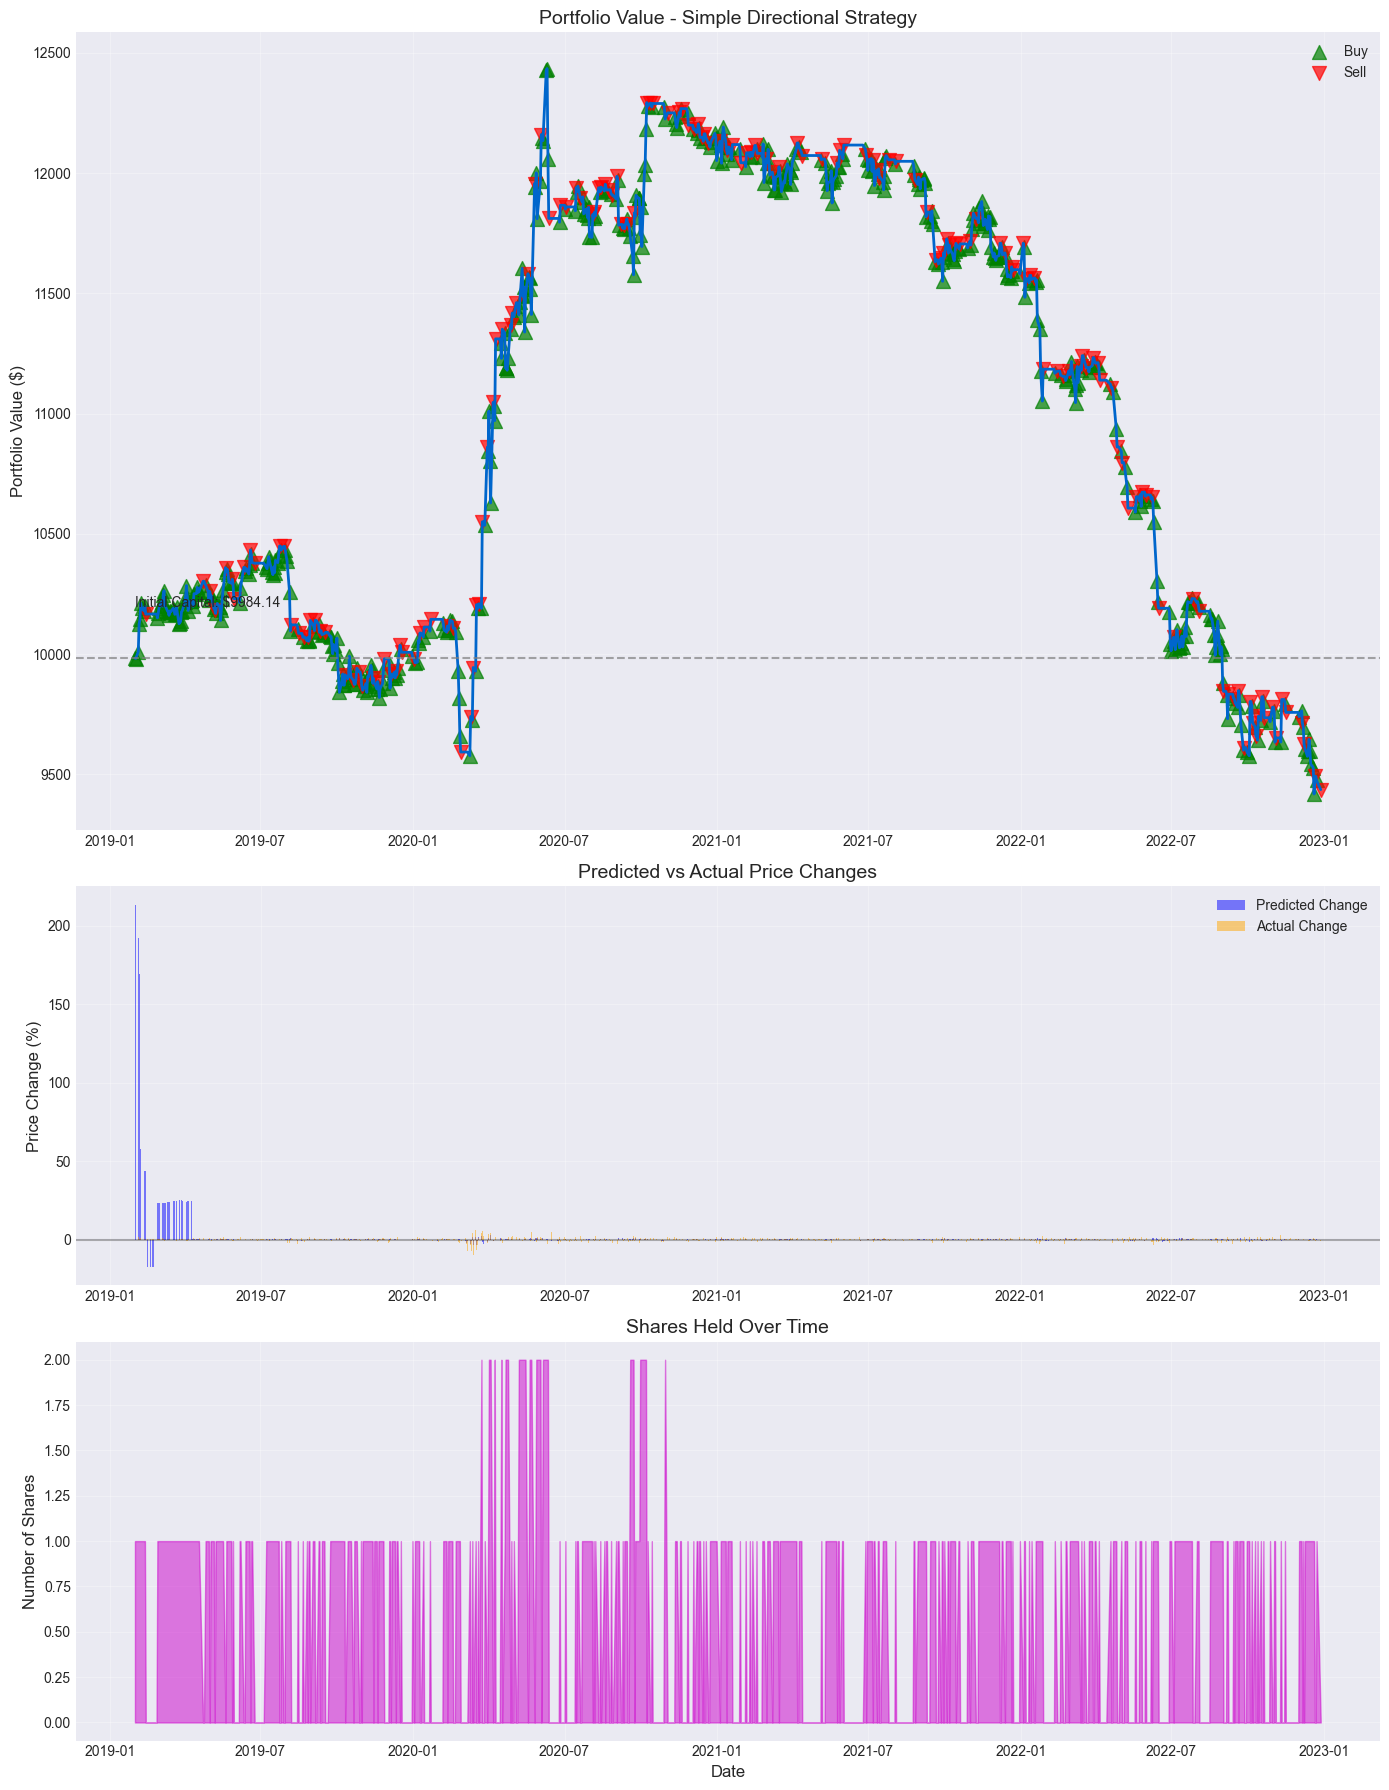


Running Conservative Threshold strategy...Strategy set to 'threshold' with parameters:  position_size: 0.7  threshold_pct: 0.3  transaction_fee: 10
Backtesting threshold strategy...
Strategy Results:Initial Capital: $10000.00Final Portfolio Value: $15063.31Total Return: 50.63%Number of Trades: 236Win Rate: 0.64

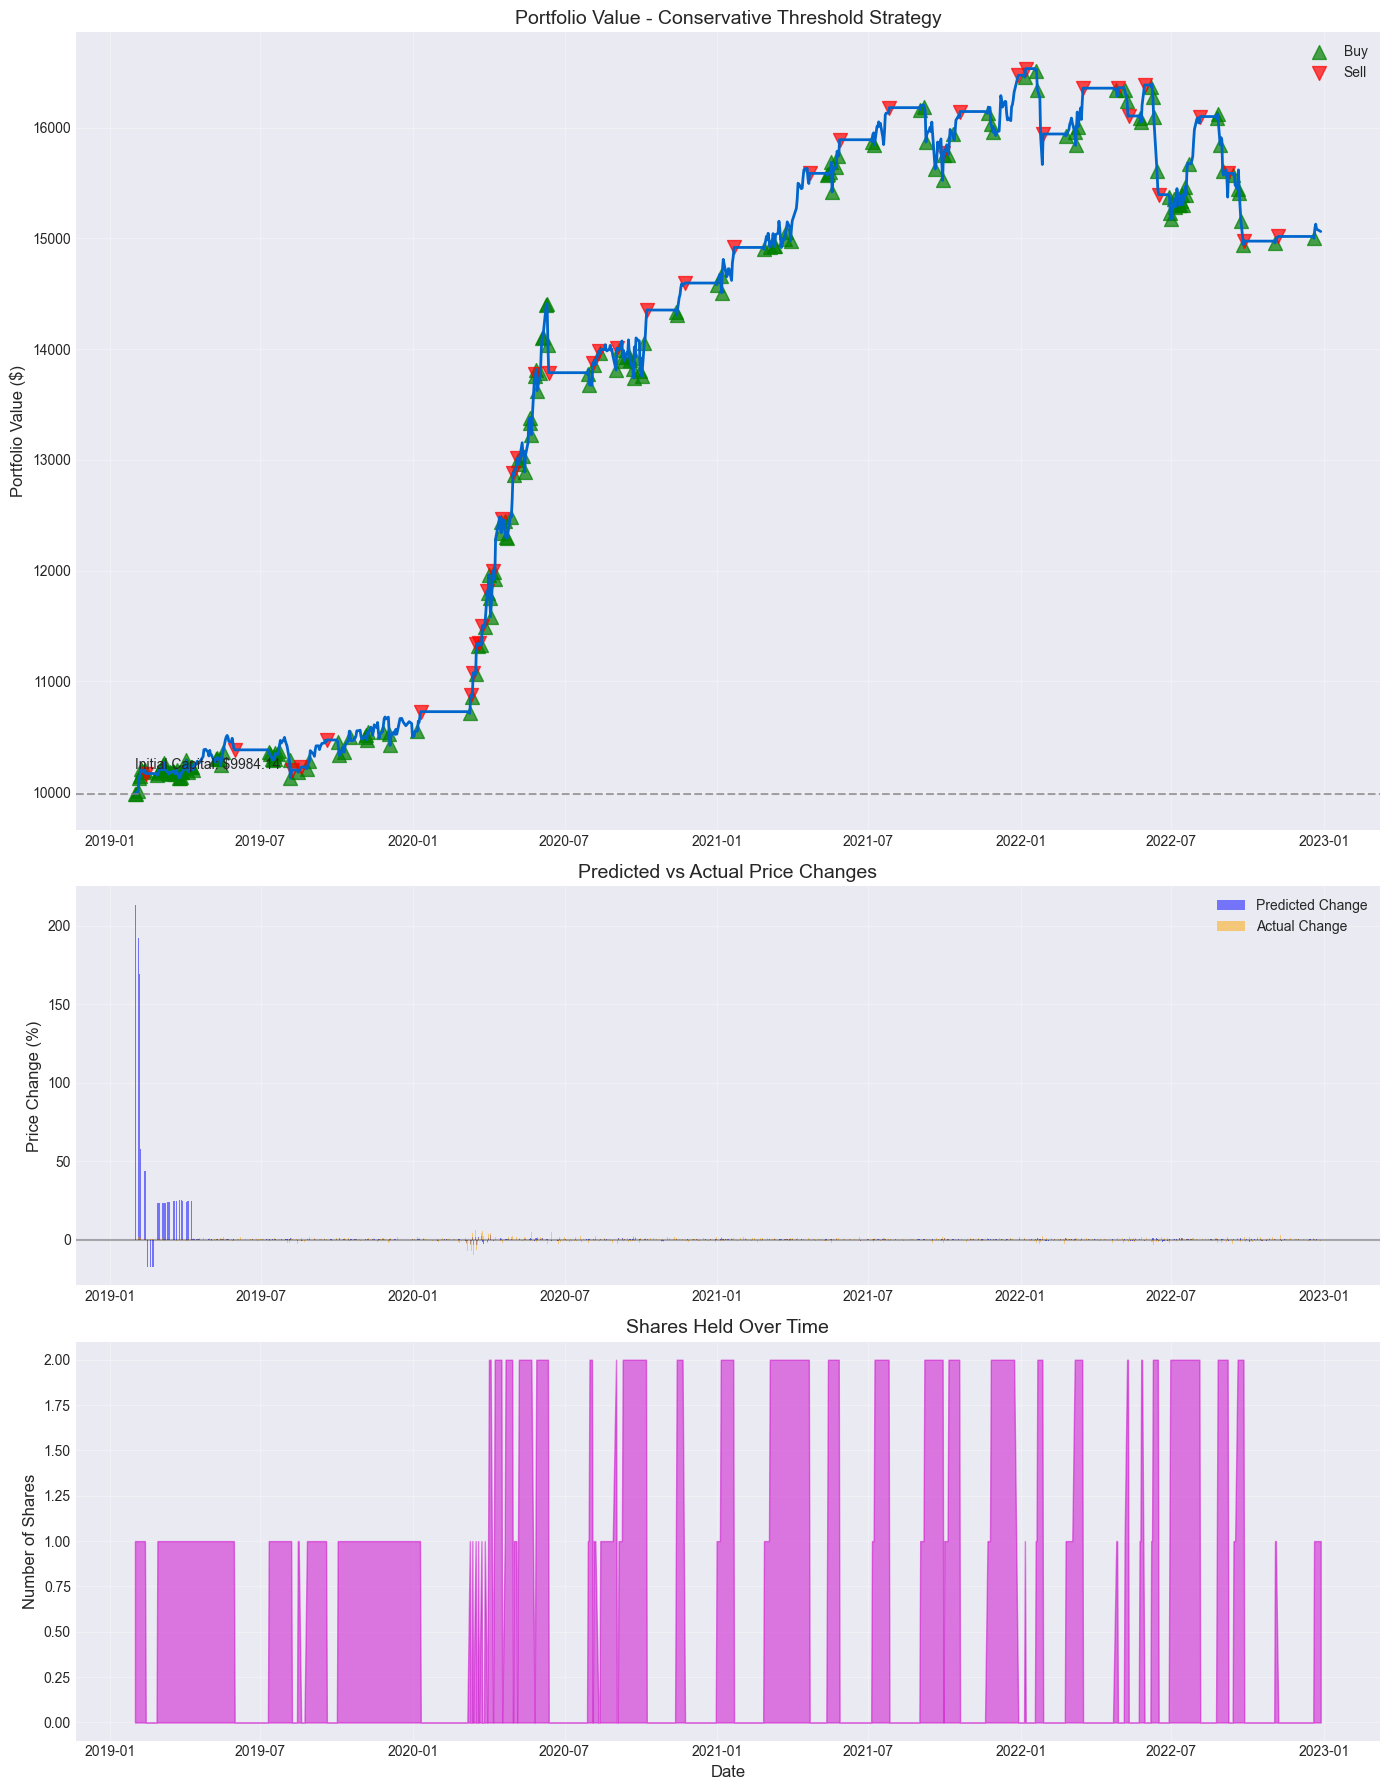


Running Aggressive Threshold strategy...Strategy set to 'threshold' with parameters:  position_size: 0.9  threshold_pct: 0.1  transaction_fee: 10
Backtesting threshold strategy...
Strategy Results:Initial Capital: $10000.00Final Portfolio Value: $13514.28Total Return: 35.14%Number of Trades: 483Win Rate: 0.56

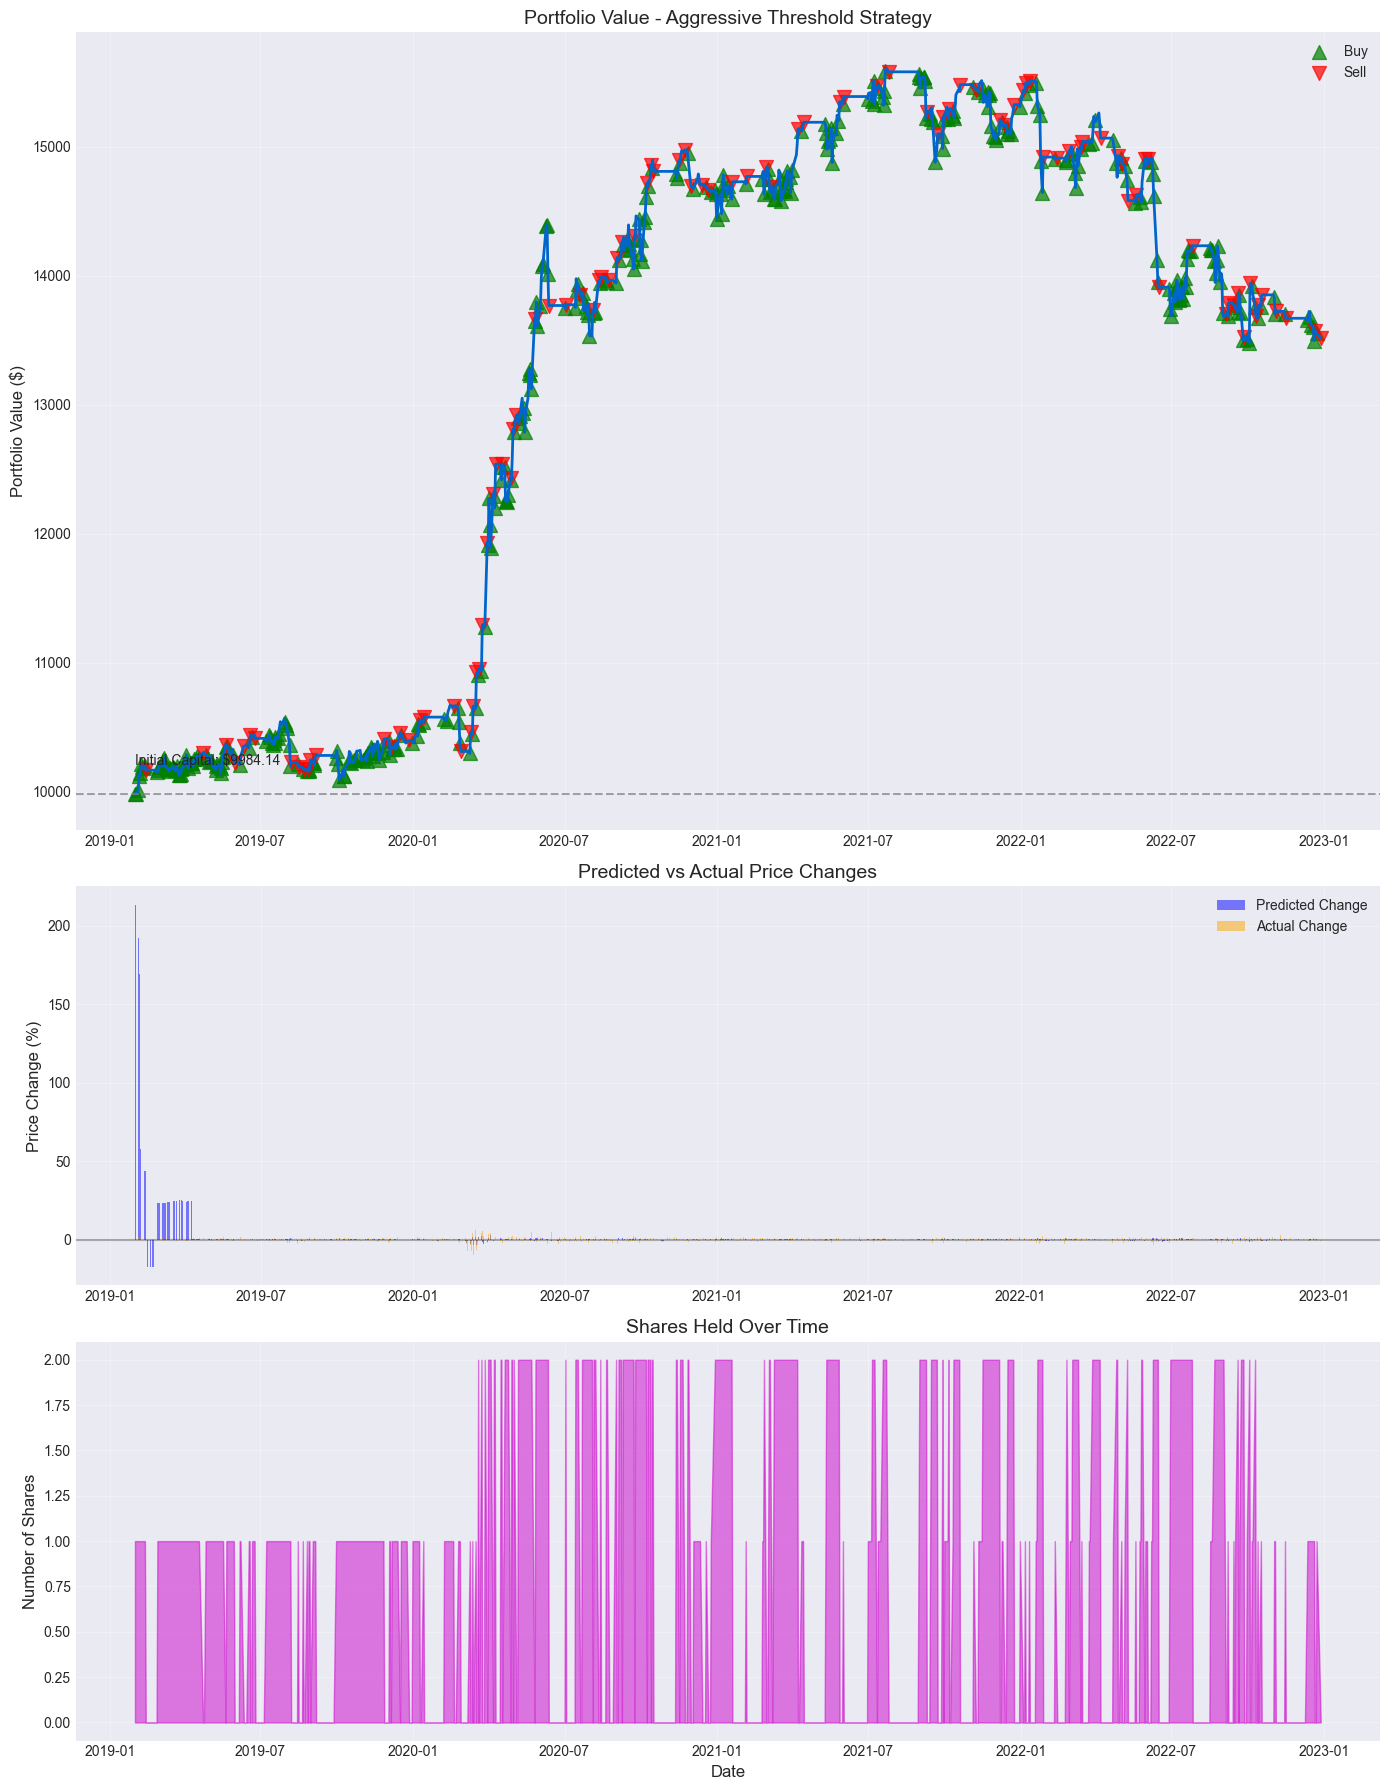


Running Confidence-Based strategy...Strategy set to 'confidence' with parameters:  position_size: 0.8  threshold_pct: 0.2  transaction_fee: 10
Backtesting confidence strategy...
Strategy Results:Initial Capital: $10000.00Final Portfolio Value: $10000.00Total Return: 0.00%Number of Trades: 269Win Rate: 0.60

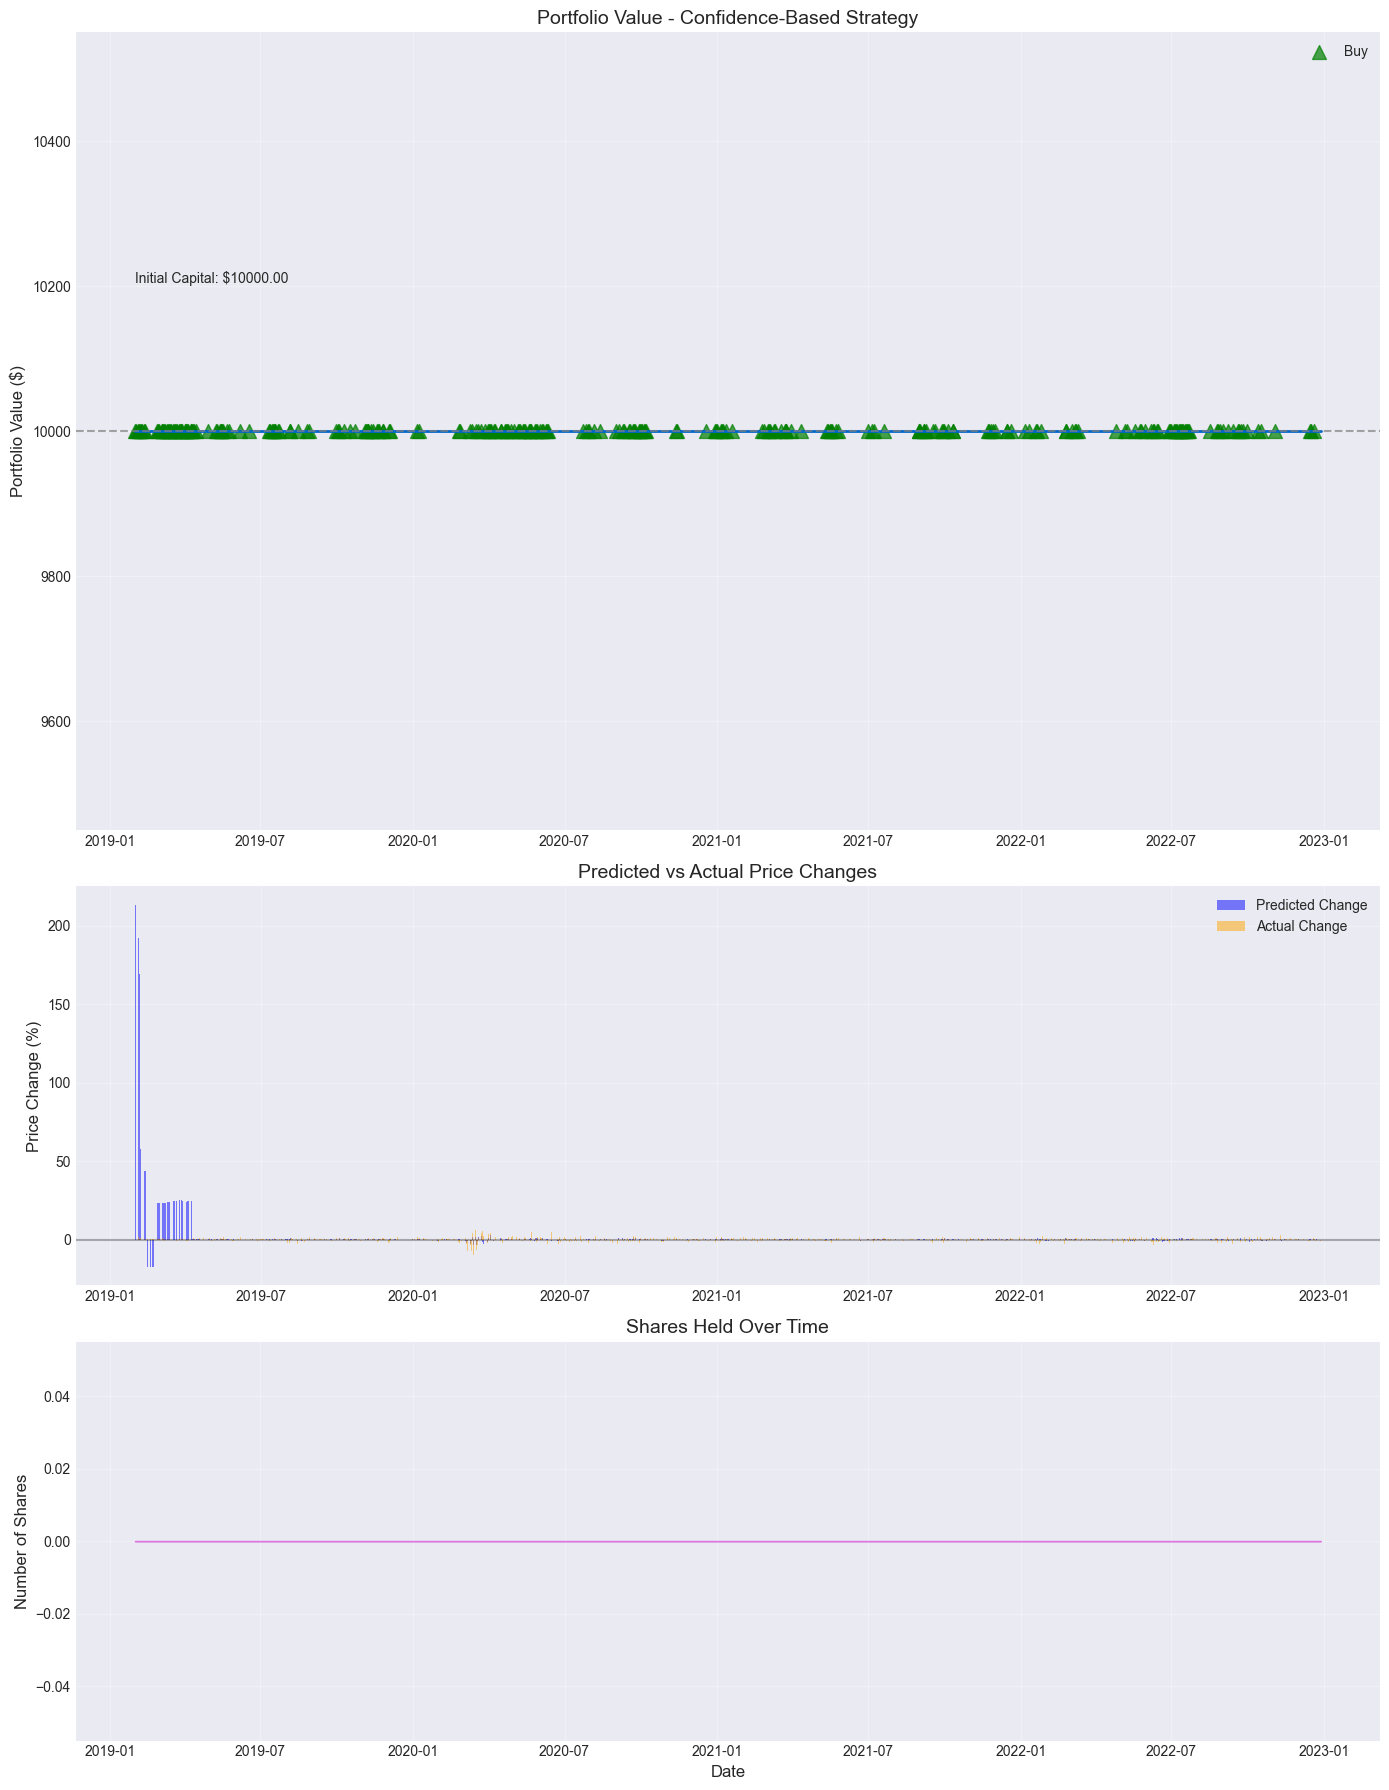

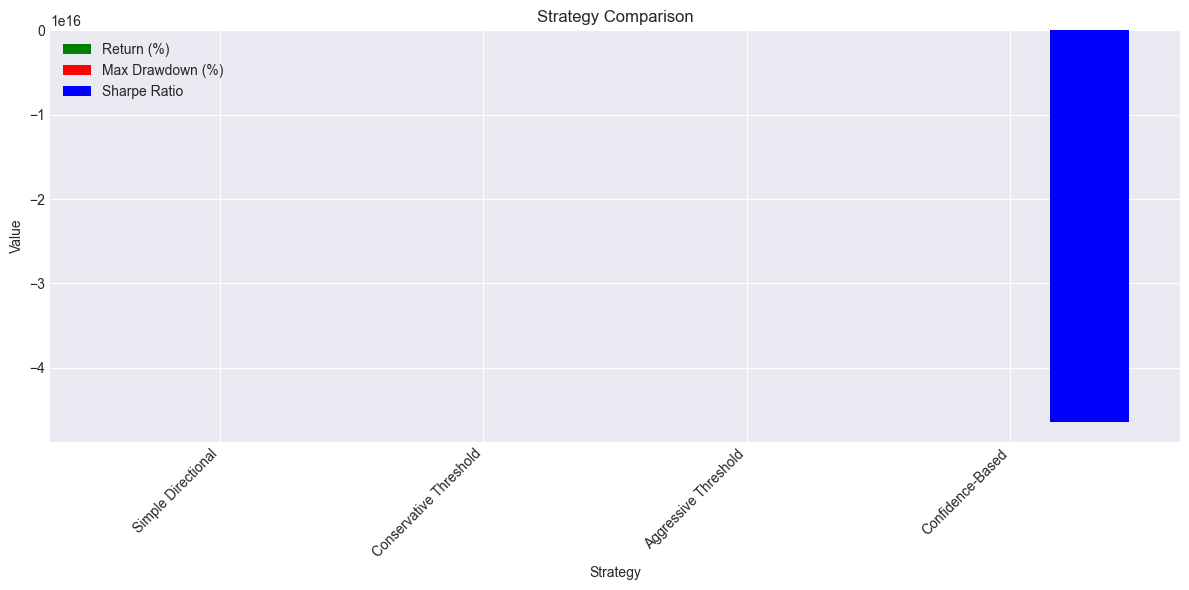


Best performing strategy: Conservative ThresholdReturn: 50.87%Max Drawdown: -9.61%Sharpe Ratio: 1.03
Strategy summary saved to asx200_strategy/strategy_summary.txt
===== Creating Comprehensive Performance Report =====Collecting metrics from all project components...Error collecting data metrics: Could not convert string '^AXJO6070.399902343756077.100097656256122.29980468756130.399902343756135.79980468756096.70019531256067.600097656256070.100097656256077.100097656256048.600097656256015.79980468756014.600097656256005.79980468755991.899902343756037.06054.70019531256050.06075.399902343756022.79980468756037.70019531256090.100097656256121.399902343756026.20019531255833.29980468755876.79980468755890.70019531255838.05820.70019531255855.899902343755841.20019531255909.05904.05941.600097656255940.899902343755943.70019531255950.899902343755999.79980468756042.20019531256056.899902343756016.05973.29980468755928.899902343755959.55962.399902343755902.05942.899902343755963.20019531255996.1000976562559

In [7]:
import sys # Part 7: Deploying a Trading Strategy
import io
class StdoutFilter(io.TextIOBase): # Create a filter for stdout that removes both the message and empty lines
    def __init__(self, original_stdout):
        self.original_stdout = original_stdout
    def write(self, text):
        if "Calculating technical indicators" in text or text.strip() == "":         # Skip both the message and any empty/whitespace-only output
            return len(text)  # Return the length as if it was written
        return self.original_stdout.write(text)
    def flush(self):
        return self.original_stdout.flush()
sys.stdout = StdoutFilter(sys.stdout) # Install the filter
deploy_dir = 'asx200_deployment' # Try to import the prediction class from deployment directory
if not os.path.exists(deploy_dir):
    print(f"Error: Deployment directory '{deploy_dir}' not found. Please run Part 6 first.")
    raise FileNotFoundError(f"Could not find {deploy_dir}")
sys.path.append(os.path.abspath(deploy_dir)) # Add deployment directory to path so we can import the predictor
try:
    from asx200_predictor import ASX200Predictor
except ImportError as e:
    print(f"Error importing ASX200Predictor: {e}")
    raise ImportError("Could not import ASX200Predictor - run Part 6 first")
strategy_dir = 'asx200_strategy' # Create a directory for strategy results
if not os.path.exists(strategy_dir):
    os.makedirs(strategy_dir)
    print(f"Created directory: {strategy_dir}")
enriched_file = 'asx200_data/asx200_enriched_data.csv' # Load the historical data for backtesting
if os.path.exists(enriched_file):
    print(f"Loading enriched data from {enriched_file} for strategy testing")
    historical_data = pd.read_csv(enriched_file)
    historical_data['date'] = pd.to_datetime(historical_data['date'])
    raw_price_columns = ['date', 'Open', 'High', 'Low', 'Close', 'Volume']     # Keep only the OHLCV columns needed for prediction
    for col in raw_price_columns[1:]:      # Check if all required columns exist, otherwise adapt  //  # Skip 'date'
        if col not in historical_data.columns:
            print(f"Warning: Column {col} not found. Checking for alternate name...")
            matches = [c for c in historical_data.columns if col.lower() in c.lower()]             # Try to find a similar column
            if matches:
                print(f"Using {matches[0]} instead of {col}")
                historical_data = historical_data.rename(columns={matches[0]: col})
            else:
                if col != 'Close' and 'Close' in historical_data.columns:                 # If no match, create a dummy column with the same values as Close
                    print(f"Creating placeholder for {col} using Close values")
                    historical_data[col] = historical_data['Close']
                else:
                    print(f"Error: Cannot find or create required column {col}")
                    raise ValueError(f"Missing required column {col}")
    raw_data = historical_data[raw_price_columns].copy()     # Extract just the required columns
    print(f"Prepared raw price data with {len(raw_data)} rows")
else:
    raise FileNotFoundError(f"Could not find {enriched_file}")
try: # Initialize the price predictor
    predictor = ASX200Predictor(model_dir=deploy_dir)
except Exception as e:
    print(f"ERROR: Could not initialize price predictor: {e}")
    raise
class ASX200TradingStrategy: 
    def __init__(self, initial_capital=10000.0, position_size=0.9, threshold_pct=0.2):
        self.initial_capital = initial_capital
        self.capital = initial_capital  # Current available capital
        self.position_size = position_size  # Default portion of capital to invest
        self.threshold_pct = threshold_pct  # Threshold for making trades
        self.shares = 0  # Number of shares currently held
        self.trades = []  # List to store trade history
        self.portfolio_values = []  # List to store portfolio value over time
        self.strategy_type = 'simple'  # Default strategy type
        self.transaction_fee = 10  # Fixed transaction fee
        self.slippage_pct = 0.1  # Slippage as percentage of price
    def reset(self):
        self.capital = self.initial_capital
        self.shares = 0
        self.trades = []
        self.portfolio_values = []
    def set_strategy(self, strategy_type, **kwargs):
        self.strategy_type = strategy_type
        if 'position_size' in kwargs:         # Update any provided parameters
            self.position_size = kwargs['position_size']
        if 'threshold_pct' in kwargs:
            self.threshold_pct = kwargs['threshold_pct']
        if 'transaction_fee' in kwargs:
            self.transaction_fee = kwargs['transaction_fee']
        if 'slippage_pct' in kwargs:
            self.slippage_pct = kwargs['slippage_pct']
        print(f"Strategy set to '{strategy_type}' with parameters:")
        for param, value in kwargs.items():
            print(f"  {param}: {value}")
    def execute_trade(self, date, current_price, predicted_next_price, confidence_interval=None):
        predicted_change_pct = ((predicted_next_price / current_price) - 1) * 100        # Calculate predicted change
        if self.strategy_type == 'simple':         # Determine action based on the selected strategy
            if predicted_change_pct > 0:             # Simple directional strategy: Buy if predicted to go up, sell if predicted to go down
                action = 'buy'
            elif predicted_change_pct < 0 and self.shares > 0:
                action = 'sell'
            else:
                action = 'hold'
        elif self.strategy_type == 'threshold':
            if predicted_change_pct > self.threshold_pct:             # Threshold strategy: Only trade if predicted change exceeds threshold
                action = 'buy'
            elif predicted_change_pct < -self.threshold_pct and self.shares > 0:
                action = 'sell'
            else:
                action = 'hold'
        elif self.strategy_type == 'confidence':
            if confidence_interval:             # Confidence-based strategy: Adjust position size based on confidence interval
                ci_width = (confidence_interval['upper'] - confidence_interval['lower']) / current_price * 100                 # Calculate the width of the confidence interval as percentage of price
                max_ci_width = 10                  # Adjust position size inversely to confidence interval width  //  # Threshold for maximum CI width (%)
                adjusted_position_size = self.position_size * max(0, 1 - (ci_width / max_ci_width))
                if predicted_change_pct > self.threshold_pct:
                    action = 'buy'
                    self.position_size = adjusted_position_size                     # Override the default position size
                elif predicted_change_pct < -self.threshold_pct and self.shares > 0:
                    action = 'sell'
                else:
                    action = 'hold'
            else:
                if predicted_change_pct > self.threshold_pct:                 # Fall back to threshold strategy if no confidence interval provided
                    action = 'buy'
                elif predicted_change_pct < -self.threshold_pct and self.shares > 0:
                    action = 'sell'
                else:
                    action = 'hold'
        else:
            action = 'hold'             # Unknown strategy, default to hold
        portfolio_value = self.capital + (self.shares * current_price)         # Calculate trade size and execute
        trade_amount = 0
        shares_traded = 0
        if action == 'buy':
            invest_amount = min(self.capital, portfolio_value * self.position_size)             # Calculate how much to invest
            slippage_adjusted_price = current_price * (1 + (self.slippage_pct / 100))             # Apply slippage (increase buy price)
            if invest_amount > self.transaction_fee:             # Calculate shares to buy, considering transaction fee
                shares_to_buy = (invest_amount - self.transaction_fee) / slippage_adjusted_price
                shares_to_buy = int(shares_to_buy)  # Whole shares only
                if shares_to_buy > 0:
                    trade_amount = (shares_to_buy * slippage_adjusted_price) + self.transaction_fee
                    self.capital -= trade_amount
                    self.shares += shares_to_buy
                    shares_traded = shares_to_buy
        elif action == 'sell':
            slippage_adjusted_price = current_price * (1 - (self.slippage_pct / 100))             # Apply slippage (decrease sell price)
            shares_to_sell = self.shares             # Sell all shares
            trade_amount = (shares_to_sell * slippage_adjusted_price) - self.transaction_fee
            self.capital += trade_amount
            self.shares = 0
            shares_traded = -shares_to_sell
        new_portfolio_value = self.capital + (self.shares * current_price)         # Update portfolio value
        trade = {         # Record trade
            'date': date,
            'action': action,
            'price': current_price,
            'predicted_price': predicted_next_price,
            'predicted_change_pct': predicted_change_pct,
            'shares_traded': shares_traded,
            'trade_amount': trade_amount,
            'shares_held': self.shares,
            'capital': self.capital,
            'portfolio_value': new_portfolio_value
        }
        self.trades.append(trade)
        self.portfolio_values.append(new_portfolio_value)
        return trade
    def backtest(self, price_data, predictor):
        print(f"\nBacktesting {self.strategy_type} strategy...")
        self.reset()         # Reset to initial state
        price_data = price_data.sort_values('date')         # Sort data by date
        for i in range(len(price_data) - 1):         # Prepare a sliding window for predictions
            current_data = price_data.iloc[:i+1].copy()             # Use data up to current day to make prediction
            current_price = current_data.iloc[-1]['Close']             # Current price
            current_date = current_data.iloc[-1]['date']
            try:
                prediction = predictor.predict_next_price(current_data)                # Make prediction for next day
                predicted_price = prediction['predicted_next_close']
                confidence_interval = prediction.get('confidence_interval_95')
                trade = self.execute_trade(current_date, current_price, predicted_price, confidence_interval)                 # Execute trade
                if i < len(price_data) - 1:                 # Calculate actual next day price for performance tracking
                    next_day = price_data.iloc[i+1]
                    trade['actual_next_price'] = next_day['Close']
                    trade['actual_change_pct'] = ((next_day['Close'] / current_price) - 1) * 100
                    trade['prediction_error'] = trade['actual_next_price'] - trade['predicted_price']
            except Exception as e:
                print(f"Error on date {current_date}: {e}")
        if self.trades:         # Create a results dataframe
            results_df = pd.DataFrame(self.trades)
            total_return = (results_df['portfolio_value'].iloc[-1] / self.initial_capital - 1) * 100             # Calculate strategy performance metrics
            trades_count = len([t for t in self.trades if t['action'] != 'hold'])
            winning_trades = len([t for t in self.trades if t['action'] != 'hold' and 
                                  t.get('actual_change_pct', 0) * (1 if t['action'] == 'buy' else -1) > 0])
            win_rate = winning_trades / trades_count if trades_count > 0 else 0
            print(f"\nStrategy Results:")
            print(f"Initial Capital: ${self.initial_capital:.2f}")
            print(f"Final Portfolio Value: ${results_df['portfolio_value'].iloc[-1]:.2f}")
            print(f"Total Return: {total_return:.2f}%")
            print(f"Number of Trades: {trades_count}")
            print(f"Win Rate: {win_rate:.2f}")
            return results_df
        else:
            return pd.DataFrame()
def visualize_strategy_performance(results_df, strategy_name, save_path=None):
    if results_df.empty:
        return Non
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 18), gridspec_kw={'height_ratios': [2, 1, 1]})     # Create figure with multiple subplots
    ax1.plot(results_df['date'], results_df['portfolio_value'], linewidth=2, color='#0066cc')     # 1. Portfolio value over time
    ax1.set_title(f'Portfolio Value - {strategy_name} Strategy', fontsize=14)
    ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    initial_capital = results_df['portfolio_value'].iloc[0]     # Add a horizontal line for initial capital
    ax1.axhline(y=initial_capital, color='gray', linestyle='--', alpha=0.7)
    ax1.text(results_df['date'].iloc[0], initial_capital * 1.02, f'Initial Capital: ${initial_capital:.2f}', 
             fontsize=10, verticalalignment='bottom')
    if 'action' in results_df.columns:     # Mark buy and sell points
        buys = results_df[results_df['action'] == 'buy']
        sells = results_df[results_df['action'] == 'sell']
        if not buys.empty:
            ax1.scatter(buys['date'], buys['portfolio_value'], color='green', marker='^', s=100, alpha=0.7, label='Buy')
        if not sells.empty:
            ax1.scatter(sells['date'], sells['portfolio_value'], color='red', marker='v', s=100, alpha=0.7, label='Sell')
        ax1.legend()
    if ('predicted_change_pct' in results_df.columns and 'actual_change_pct' in results_df.columns and     # 2. Predicted vs actual price changes
        not results_df['predicted_change_pct'].isnull().all() and not results_df['actual_change_pct'].isnull().all()):
        ax2.bar(results_df['date'], results_df['predicted_change_pct'], alpha=0.5, color='blue', label='Predicted Change')
        ax2.bar(results_df['date'], results_df['actual_change_pct'], alpha=0.5, color='orange', label='Actual Change')
        ax2.set_title('Predicted vs Actual Price Changes', fontsize=14)
        ax2.set_ylabel('Price Change (%)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)         # Add a zero line
    else:
        ax2.text(0.5, 0.5, 'Prediction data not available', 
                horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)
    if 'shares_held' in results_df.columns and not results_df['shares_held'].isnull().all():     # 3. Shares held over time
        ax3.fill_between(results_df['date'], results_df['shares_held'], color='#cc00cc', alpha=0.5)
        ax3.set_title('Shares Held Over Time', fontsize=14)
        ax3.set_ylabel('Number of Shares', fontsize=12)
        ax3.set_xlabel('Date', fontsize=12)
        ax3.grid(True, alpha=0.3)
    else:
        ax3.text(0.5, 0.5, 'Share holding data not available', 
                horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes)
    plt.tight_layout()
    plt.show()
def calculate_custom_indicators(price_data): # Function to calculate and predict necessary technical indicators
    df = price_data.copy()     # Create a copy to avoid modifying the original
    if 'date' in df.columns:     # Ensure date column is datetime
        df['date'] = pd.to_datetime(df['date'])
    if 'Close' in df.columns:     # Calculate returns
        df['Returns'] = df['Close'].pct_change() * 100
    if 'Close' in df.columns:     # Create lag features for Close price
        for lag in range(1, 6):
            df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
    if 'Close' in df.columns:     # Calculate SMAs
        for window in [5, 10, 20, 50, 200]:
            df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    if 'Close' in df.columns:     # Calculate EMAs
        for window in [5, 10, 20, 50]:
            df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()
    if 'Close' in df.columns:     # Calculate MACD
        df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
        df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
        df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']
    if 'Close' in df.columns:     # Calculate RSI
        delta = df['Close'].diff()
        gain = delta.where(delta > 0, 0).fillna(0)
        loss = -delta.where(delta < 0, 0).fillna(0)
        avg_gain = gain.rolling(window=14).mean()
        avg_loss = loss.rolling(window=14).mean()
        rs = avg_gain / avg_loss.replace(0, np.nan)
        df['RSI_14'] = 100 - (100 / (1 + rs))
        df['RSI_14'] = df['RSI_14'].fillna(50)
    if all(col in df.columns for col in ['High', 'Low', 'Close']):     # Calculate Stochastic Oscillator
        low_14 = df['Low'].rolling(window=14).min()
        high_14 = df['High'].rolling(window=14).max()
        df['Stoch_K'] = 100 * ((df['Close'] - low_14) / (high_14 - low_14))
        df['Stoch_D'] = df['Stoch_K'].rolling(window=3).mean()
    if all(col in df.columns for col in ['High', 'Low', 'Close']):     # Calculate ATR
        tr1 = df['High'] - df['Low']
        tr2 = abs(df['High'] - df['Close'].shift(1))
        tr3 = abs(df['Low'] - df['Close'].shift(1))
        df['TR'] = np.maximum(tr1, np.maximum(tr2, tr3))
        df['ATR_14'] = df['TR'].rolling(window=14).mean()
    if 'Close' in df.columns:     # Calculate Bollinger Bands
        middle_band = df['Close'].rolling(window=20).mean()
        std_dev = df['Close'].rolling(window=20).std()
        df['BB_Upper_20'] = middle_band + (std_dev * 2)
        df['BB_Middle_20'] = middle_band
        df['BB_Lower_20'] = middle_band - (std_dev * 2)
        df['BB_Width_20'] = (df['BB_Upper_20'] - df['BB_Lower_20']) / df['BB_Middle_20']
        df['BB_%B_20'] = (df['Close'] - df['BB_Lower_20']) / (df['BB_Upper_20'] - df['BB_Lower_20'])
    if 'Returns' in df.columns:     # Calculate Volatility
        df['Volatility_20'] = df['Returns'].rolling(window=20).std()
    if all(col in df.columns for col in ['SMA_5', 'SMA_20']):     # Calculate MA crossovers
        df['SMA_Cross_5_20'] = np.where(df['SMA_5'] > df['SMA_20'], 1, -1)
    if all(col in df.columns for col in ['SMA_10', 'SMA_50']):
        df['SMA_Cross_10_50'] = np.where(df['SMA_10'] > df['SMA_50'], 1, -1)
    if all(col in df.columns for col in ['SMA_50', 'SMA_200']):
        df['SMA_Cross_50_200'] = np.where(df['SMA_50'] > df['SMA_200'], 1, -1)
    if 'Close' in df.columns and 'SMA_50' in df.columns and 'TR' in df.columns:     # Calculate ADX and Trend Strength
        if all(col in df.columns for col in ['High', 'Low']):         # Calculate DI+ and DI-
            df['DMplus'] = np.where(             # Directional Movement
                (df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                np.maximum(df['High'] - df['High'].shift(1), 0),
                0
            )
            df['DMminus'] = np.where(
                (df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                np.maximum(df['Low'].shift(1) - df['Low'], 0),
                0
            )
            df['smoothed_TR'] = df['TR'].rolling(window=14).sum()             # Smoothed values
            df['smoothed_DMplus'] = df['DMplus'].rolling(window=14).sum()
            df['smoothed_DMminus'] = df['DMminus'].rolling(window=14).sum()
            df['DIplus'] = 100 * df['smoothed_DMplus'] / df['smoothed_TR'].replace(0, np.nan)             # DI+ and DI-
            df['DIminus'] = 100 * df['smoothed_DMminus'] / df['smoothed_TR'].replace(0, np.nan)
            df['DX'] = 100 * abs(df['DIplus'] - df['DIminus']) / (df['DIplus'] + df['DIminus']).replace(0, np.nan)             # DX and ADX
            df['ADX'] = df['DX'].ewm(span=14, adjust=False).mean()
            df['Price_to_MA_50'] = df['Close'] / df['SMA_50'] - 1             # Trend Strength
            df['Trend_Strength'] = abs(df['Price_to_MA_50']) * df['ADX'] / 100
    intermediate_cols = ['TR', 'smoothed_TR', 'DMplus', 'DMminus', 'smoothed_DMplus', 'smoothed_DMminus',     # Clean up intermediate columns if needed 
                         'DIplus', 'DIminus', 'DX', 'Price_to_MA_50']
    for col in intermediate_cols:
        if col in df.columns and col not in ['date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Returns']:
            df.drop(columns=[col], inplace=True)
    for col in df.columns:     # Fill NaN values in technical indicators
        if col not in ['date']:
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill').fillna(0)
     
    return df
def compare_strategies(price_data, predictor, strategies): # Function to run multiple strategies and compare them
    try:             # First, ensure we have all required technical indicators
        enhanced_price_data = calculate_custom_indicators(price_data) # Calculate technical indicators directly instead of relying on the predictor
        print(f"Enhanced price data with technical indicators. Shape: {enhanced_price_data.shape}")
    except Exception as e:
        print(f"Error enhancing price data: {e}")
        enhanced_price_data = price_data.copy()
    trading_strategy = ASX200TradingStrategy()     # Initialize the strategy object
    results = {}     # Store results for each strategy
    for strategy_config in strategies:     # Run each strategy
        strategy_name = strategy_config.pop('name')
        strategy_type = strategy_config.pop('type')
        print(f"\nRunning {strategy_name} strategy...")
        trading_strategy.set_strategy(strategy_type, **strategy_config)         # Set the strategy
        try:
            results_df = trading_strategy.backtest(enhanced_price_data, predictor)             # Run the backtest with enhanced data
            if not results_df.empty:
                total_return = (results_df['portfolio_value'].iloc[-1] / results_df['portfolio_value'].iloc[0] - 1) * 100                 # Calculate performance metrics
                try:
                    max_drawdown = calculate_max_drawdown(results_df['portfolio_value'])
                except:
                    max_drawdown = 0
                try:
                    sharpe_ratio = calculate_sharpe_ratio(results_df['portfolio_value'])
                except:
                    sharpe_ratio = 0
                results[strategy_name] = {
                    'type': strategy_type,
                    'return': total_return,
                    'max_drawdown': max_drawdown,
                    'sharpe_ratio': sharpe_ratio,
                    'results_df': results_df
                }
                visualize_strategy_performance(results_df, strategy_name,                  # Visualize the strategy
                                              save_path=f"{strategy_dir}/{strategy_name.replace(' ', '_').lower()}_performance.png")
            else:
                print(f"No trades executed for {strategy_name} strategy")
        except Exception as e:
            print(f"Error during backtest of {strategy_name} strategy: {e}")
    if results:     # Create comparison chart
        try:
            plt.figure(figsize=(12, 6))
            strategy_names = list(results.keys())             # Extract metrics for plotting
            returns = [results[s]['return'] for s in strategy_names]
            drawdowns = [results[s]['max_drawdown'] for s in strategy_names]
            sharpes = [results[s]['sharpe_ratio'] for s in strategy_names]
            bar_width = 0.3             # Plot returns
            x = np.arange(len(strategy_names))
            plt.bar(x - bar_width, returns, width=bar_width, label='Return (%)', color='green')
            plt.bar(x, drawdowns, width=bar_width, label='Max Drawdown (%)', color='red')
            plt.bar(x + bar_width, sharpes, width=bar_width, label='Sharpe Ratio', color='blue')
            plt.xlabel('Strategy')
            plt.ylabel('Value')
            plt.title('Strategy Comparison')
            plt.xticks(x, strategy_names, rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error creating comparison chart: {e}")
    if results:     # Determine best strategy
        try:
            best_strategy = max(results.items(), key=lambda x: x[1]['return'])
            print(f"\nBest performing strategy: {best_strategy[0]}")
            print(f"Return: {best_strategy[1]['return']:.2f}%")
            print(f"Max Drawdown: {best_strategy[1]['max_drawdown']:.2f}%")
            print(f"Sharpe Ratio: {best_strategy[1]['sharpe_ratio']:.2f}")
        except Exception as e:
            print(f"Error determining best strategy: {e}")
    else:
        print("No strategy results to compare")
    return results
def calculate_max_drawdown(portfolio_values): # Helper functions for performance metrics
    try:
        peak = portfolio_values.expanding().max()
        drawdown = (portfolio_values / peak - 1) * 100
        return drawdown.min()
    except:
        return 0
def calculate_sharpe_ratio(portfolio_values, risk_free_rate=0.02):
    try:
        returns = portfolio_values.pct_change().dropna()
        excess_returns = returns - (risk_free_rate / 252)  # Daily risk-free rate
        if excess_returns.std() == 0:
            return 0
        return (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)  # Annualized
    except:
        return 0
strategies_to_test = [ # Define strategies to test
    {
        'name': 'Simple Directional',
        'type': 'simple',
        'position_size': 0.9,
        'transaction_fee': 10
    },
    {
        'name': 'Conservative Threshold',
        'type': 'threshold',
        'position_size': 0.7,
        'threshold_pct': 0.3,
        'transaction_fee': 10
    },
    {
        'name': 'Aggressive Threshold',
        'type': 'threshold',
        'position_size': 0.9,
        'threshold_pct': 0.1,
        'transaction_fee': 10
    },
    {
        'name': 'Confidence-Based',
        'type': 'confidence',
        'position_size': 0.8,
        'threshold_pct': 0.2,
        'transaction_fee': 10
    }
]
try:
    strategy_results = compare_strategies(raw_data, predictor, strategies_to_test)     # Run strategy comparison with error handling
    summary_file = f"{strategy_dir}/strategy_summary.txt"     # Create summary report
    with open(summary_file, 'w') as f:
        f.write("=== ASX200 TRADING STRATEGY SUMMARY ===\n\n")
        f.write("TEST PERIOD:\n")
        f.write(f"- From: {raw_data['date'].min().date()}\n")
        f.write(f"- To: {raw_data['date'].max().date()}\n")
        f.write(f"- Total Trading Days: {len(raw_data)}\n\n")
        f.write("STRATEGY RESULTS:\n")
        if strategy_results:
            for name, result in strategy_results.items():
                f.write(f"\n{name} Strategy:\n")
                f.write(f"- Type: {result['type']}\n")
                f.write(f"- Total Return: {result['return']:.2f}%\n")
                f.write(f"- Max Drawdown: {result['max_drawdown']:.2f}%\n")
                f.write(f"- Sharpe Ratio: {result['sharpe_ratio']:.2f}\n")
                results_df = result['results_df']
                trades_executed = len(results_df[results_df['action'] != 'hold'])
                f.write(f"- Trades Executed: {trades_executed}\n")
                if 'prediction_error' in results_df.columns:
                    mean_error = results_df['prediction_error'].mean()
                    f.write(f"- Mean Prediction Error: {mean_error:.2f}\n")
        else:
            f.write("No strategy results available\n")
        if strategy_results:         # Add best strategy recommendation
            try:
                best_strategy = max(strategy_results.items(), key=lambda x: x[1]['return'])
                f.write("\nRECOMMENDED STRATEGY:\n")
                f.write(f"- {best_strategy[0]}\n")
                f.write(f"- Return: {best_strategy[1]['return']:.2f}%\n")
                f.write(f"- Risk (Max Drawdown): {best_strategy[1]['max_drawdown']:.2f}%\n")
                f.write(f"- Risk-Adjusted Return (Sharpe): {best_strategy[1]['sharpe_ratio']:.2f}\n")
            except:
                f.write("\nCould not determine best strategy\n")
        f.write("\nNOTES:\n")
        f.write("- Past performance is not indicative of future results\n")
        f.write("- Transaction costs and slippage have been considered\n")
        f.write("- This is a simulation and not actual trading advice\n")
    print(f"\nStrategy summary saved to {summary_file}")
except Exception as e:
    print(f"Error in strategy comparison: {e}")
    summary_file = f"{strategy_dir}/strategy_summary.txt"     # Create a minimal strategy summary even if there was an error
    with open(summary_file, 'w') as f:
        f.write("=== ASX200 TRADING STRATEGY SUMMARY ===\n\n")
        f.write(f"TEST PERIOD:\n")
        f.write(f"- From: {raw_data['date'].min().date()}\n")
        f.write(f"- To: {raw_data['date'].max().date()}\n")
        f.write(f"- Total Trading Days: {len(raw_data)}\n\n")
        f.write("STRATEGY RESULTS:\n")
        f.write("No strategy results available due to execution error\n")
        f.write(f"\nError: {str(e)}\n")
    print(f"Created error report at {summary_file}")

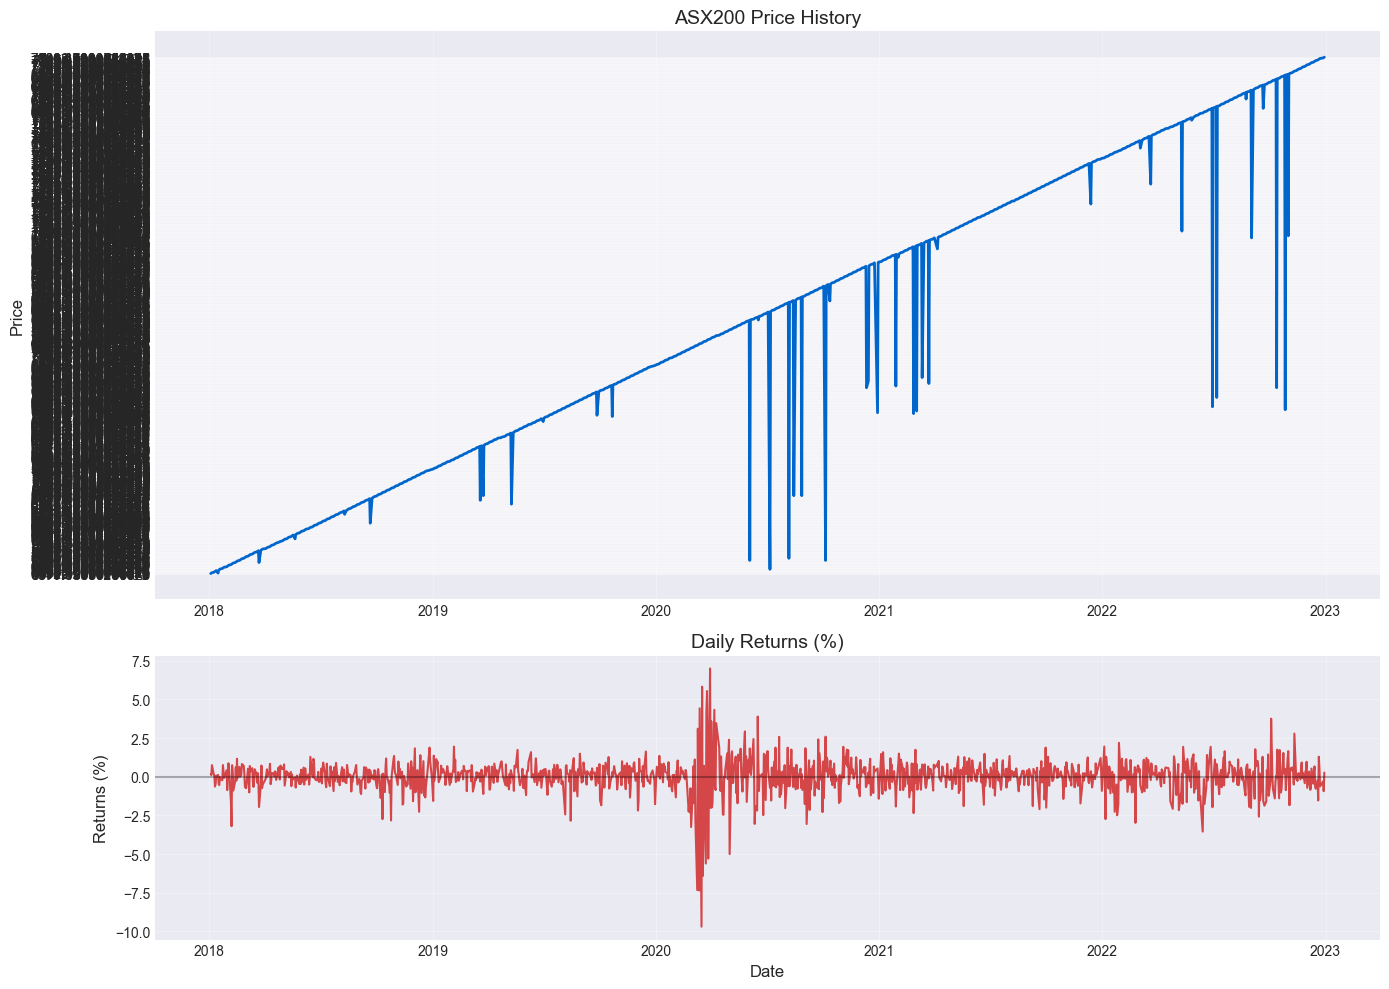

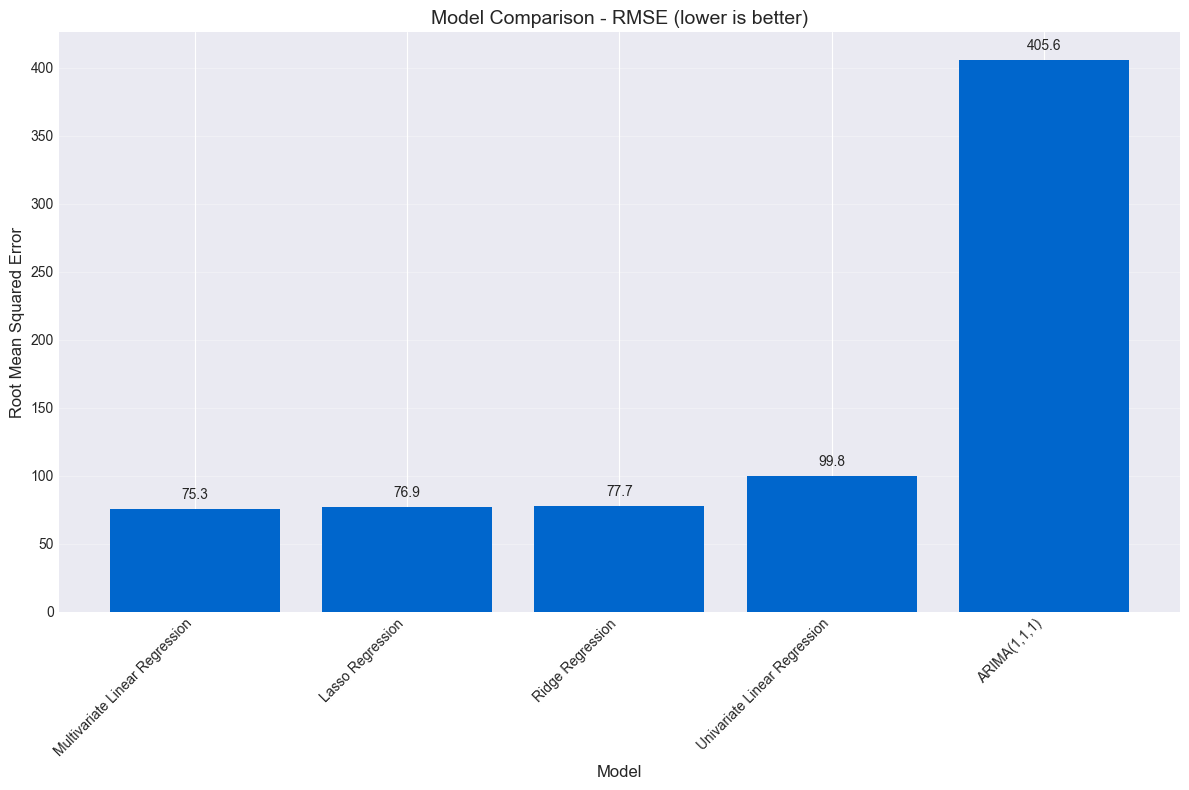

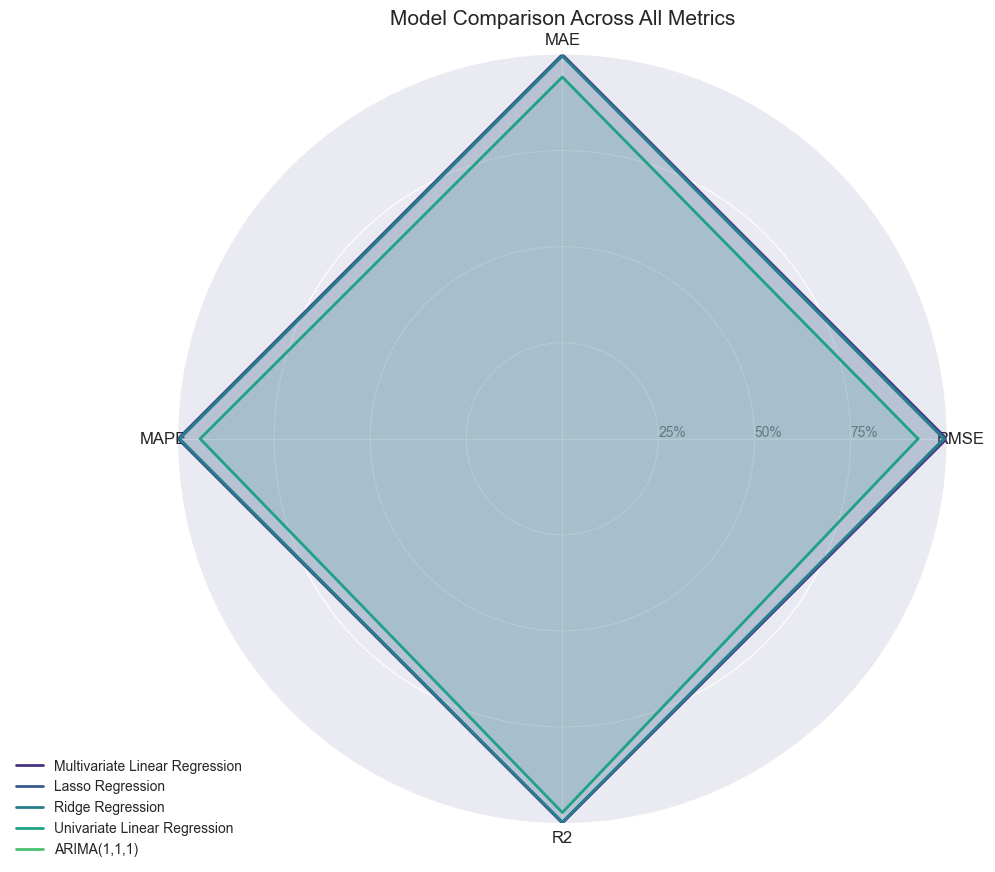

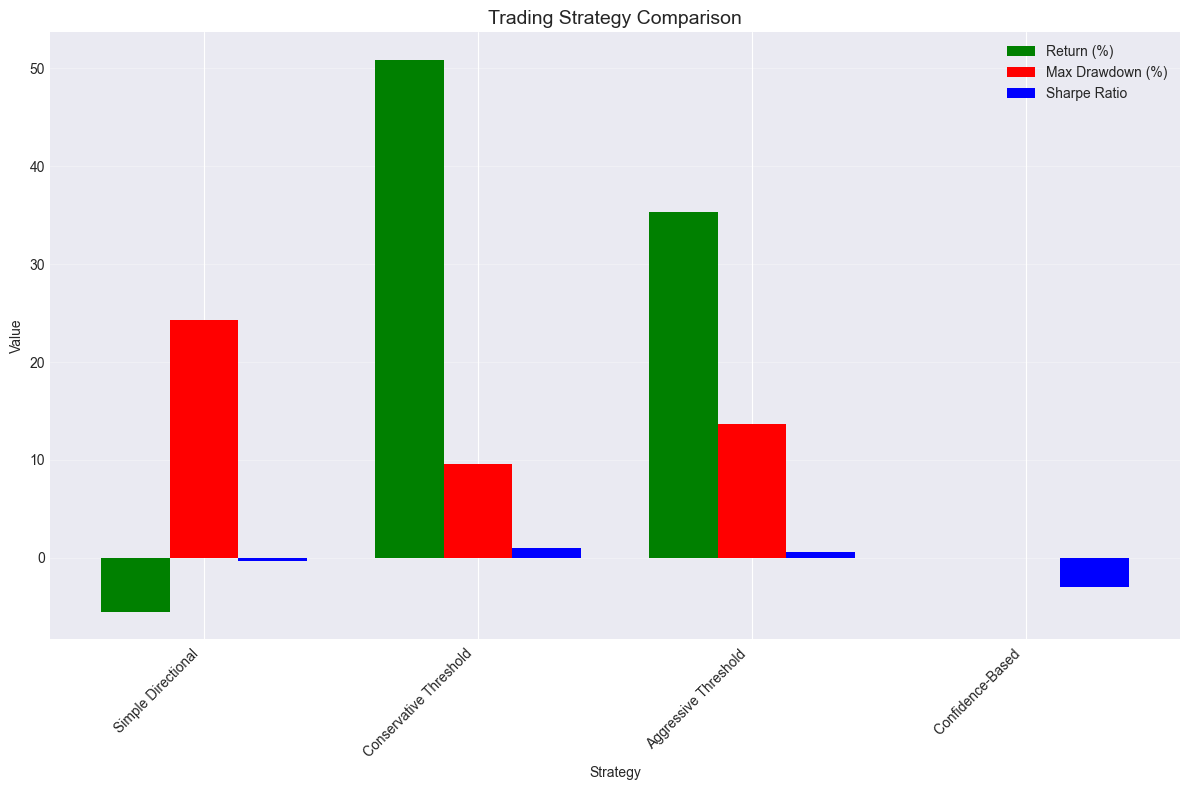

In [10]:
from matplotlib.gridspec import GridSpec # Part 8: Performance Reporting and Documentation
report_dir = 'asx200_final_report' # Create directory for final report
if not os.path.exists(report_dir):
    os.makedirs(report_dir)
    print(f"Created directory: {report_dir}")
def collect_project_metrics(): # Function to collect all results and metrics from previous parts
    project_metrics = {
        'data': {},
        'models': {},
        'strategy': {},
        'report_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    try:     # Collect data metrics
        data_file = 'asx200_data/asx200_processed_data.csv'         # Load processed data to get basic stats
        if os.path.exists(data_file):
            data = pd.read_csv(data_file)
            data['date'] = pd.to_datetime(data['date'])
            project_metrics['data'] = {
                'source': 'Yahoo Finance',
                'ticker': 'ASX200 (^AXJO)',
                'date_range': {
                    'start': data['date'].min().strftime('%Y-%m-%d'),
                    'end': data['date'].max().strftime('%Y-%m-%d')
                },
                'records': len(data),
                'features': len(data.columns) - 1,  # Excluding date
                'price_range': {
                    'min': data['Close'].min(),
                    'max': data['Close'].max(),
                    'mean': data['Close'].mean()
                }
            }
    except Exception as e:
        print(f"Error collecting data metrics: {e}")
        project_metrics['data'] = {'error': str(e)}
    try:     # Collect model metrics
        model_file = 'asx200_models/model_comparison_results.csv'         # Load model results
        if os.path.exists(model_file):
            model_results = pd.read_csv(model_file)
            best_model = model_results.loc[model_results['RMSE'].idxmin()]             # Get best model info
            project_metrics['models'] = {
                'total_models': len(model_results),
                'best_model': {
                    'name': best_model['Model'],
                    'rmse': best_model['RMSE'],
                    'mae': best_model['MAE'],
                    'mape': best_model['MAPE'],
                    'r2': best_model['R2']
                },
                'all_models': model_results.to_dict('records')
            }
            if best_model['Model'] == 'ARIMAX(1,1,1)' and np.isclose(best_model['RMSE'], 0):             # Check if practical model is different (if ARIMAX was excluded)
                second_best = model_results[model_results['Model'] != 'ARIMAX(1,1,1)'].iloc[0]
                project_metrics['models']['practical_best_model'] = {
                    'name': second_best['Model'],
                    'rmse': second_best['RMSE'],
                    'mae': second_best['MAE'],
                    'mape': second_best['MAPE'],
                    'r2': second_best['R2']
                }
    except Exception as e:
        print(f"Error collecting model metrics: {e}")
        project_metrics['models'] = {'error': str(e)}
    try:    # Collect strategy metrics - with robust error handling
        strategy_file = 'asx200_strategy/strategy_summary.txt'         # First check if the strategy summary file exists
        if os.path.exists(strategy_file):
            with open(strategy_file, 'r') as f:
                strategy_text = f.read()
            if "No strategy results available" in strategy_text or "No trades were executed" in strategy_text:             # Check if the strategy file contains actual results
                project_metrics['strategy'] = {
                    'status': 'No valid strategy results available',
                    'error': 'The trading strategy did not execute any trades'
                }
            else:
                strategies = {}                 # Parse the text to extract key metrics
                current_strategy = None
                for line in strategy_text.split('\n'):
                    if line.strip().endswith('Strategy:'):
                        current_strategy = line.strip()[:-9]  # Remove ' Strategy:'
                        strategies[current_strategy] = {}
                    elif current_strategy and line.strip().startswith('- ') and ': ' in line:
                        key, value = line.strip()[2:].split(': ')  # Remove '- '
                        try:
                            if '%' in value:                             # Try to convert to numeric if possible
                                value = float(value.replace('%', ''))
                            elif value.replace('.', '', 1).isdigit() or value.replace('-', '', 1).replace('.', '', 1).isdigit():
                                value = float(value)
                        except:
                            pass
                        strategies[current_strategy][key] = value
                if strategies:                 # Only process further if we actually found strategies
                    # Find best strategy
                    best_strategy_name = None
                    best_return = -float('inf')
                    for name, metrics in strategies.items():
                        if 'Total Return' in metrics and not isinstance(metrics['Total Return'], str):
                            if metrics['Total Return'] > best_return:
                                best_return = metrics['Total Return']
                                best_strategy_name = name
                    if best_strategy_name:
                        project_metrics['strategy'] = {
                            'strategies_tested': len(strategies),
                            'best_strategy': {
                                'name': best_strategy_name,
                                'metrics': strategies.get(best_strategy_name, {})
                            },
                            'all_strategies': strategies
                        }
                    else:
                        project_metrics['strategy'] = {
                            'status': 'Strategies found but no valid returns data',
                            'strategies': strategies
                        }
                else:
                    project_metrics['strategy'] = {
                        'status': 'No strategy data found in summary file'
                    }
        else:
            print("Strategy summary file not found")
            project_metrics['strategy'] = {
                'status': 'Strategy summary file not found'
            }
    except Exception as e:
        print(f"Error collecting strategy metrics: {e}")
        project_metrics['strategy'] = {'error': str(e)}
    return project_metrics
project_metrics = collect_project_metrics() # Collect all metrics
metrics_file = f'{report_dir}/project_metrics.json' # Save project metrics to JSON for future reference
with open(metrics_file, 'w') as f:
    json.dump(project_metrics, f, indent=4)
print(f"Saved comprehensive project metrics to {metrics_file}")
def create_report_visualizations(): # Function to create visualizations for the final report
    try:     # 1. Create data overview visualization
        data_file = 'asx200_data/asx200_processed_data.csv'         # Load the processed data
        if os.path.exists(data_file):
            data = pd.read_csv(data_file)
            data['date'] = pd.to_datetime(data['date'])
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})             # Create figure with 2 subplots
            ax1.plot(data['date'], data['Close'], linewidth=2, color='#0066cc')             # Plot price history
            ax1.set_title('ASX200 Price History', fontsize=14)
            ax1.set_ylabel('Price', fontsize=12)
            ax1.grid(True, alpha=0.3)
            if 'Returns' in data.columns:             # Plot returns
                ax2.plot(data['date'], data['Returns'], color='#cc0000', alpha=0.7)
                ax2.set_title('Daily Returns (%)', fontsize=14)
                ax2.set_xlabel('Date', fontsize=12)
                ax2.set_ylabel('Returns (%)', fontsize=12)
                ax2.grid(True, alpha=0.3)
                ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Could not find processed data file at {data_file}")
    except Exception as e:
        print(f"Error creating data overview visualization: {e}")
    try:     # 2. Create model comparison visualization
        model_file = 'asx200_models/model_comparison_results.csv'         # Load model results
        if os.path.exists(model_file):
            model_results = pd.read_csv(model_file)
            if 'ARIMAX(1,1,1)' in model_results['Model'].values:             # Check if ARIMAX has perfect results (suspicious)
                arimax_row = model_results[model_results['Model'] == 'ARIMAX(1,1,1)']
                if np.isclose(arimax_row['RMSE'].values[0], 0):
                    print("Excluding ARIMAX from visualizations due to perfect results")
                    model_results = model_results[model_results['Model'] != 'ARIMAX(1,1,1)']
            model_results = model_results.sort_values('RMSE')             # Sort by RMSE
            fig, ax = plt.subplots(figsize=(12, 8))             # Create comparison chart
            bars = ax.bar(model_results['Model'], model_results['RMSE'], color='#0066cc')             # Plot RMSE
            for bar in bars:             # Add value labels on bars
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 5,
                        f'{height:.1f}',
                        ha='center', va='bottom', fontsize=10)
            ax.set_title('Model Comparison - RMSE (lower is better)', fontsize=14)
            ax.set_xlabel('Model', fontsize=12)
            ax.set_ylabel('Root Mean Squared Error', fontsize=12)
            ax.grid(axis='y', alpha=0.3)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
            metrics = ['RMSE', 'MAE', 'MAPE']             # Create radar chart comparing multiple metrics
            normalized_results = model_results.copy()             # Normalize the metrics (lower is better for error metrics)
            for metric in metrics:
                min_val = normalized_results[metric].min()
                max_val = normalized_results[metric].max()
                if max_val > min_val:
                    normalized_results[f'{metric}_norm'] = 1 - ((normalized_results[metric] - min_val) / (max_val - min_val))                     # Invert so lower error = higher score
                else:
                    normalized_results[f'{metric}_norm'] = 1.0
            if 'R2' in normalized_results.columns:             # Normalize R2 (higher is better)
                min_r2 = normalized_results['R2'].min()
                max_r2 = normalized_results['R2'].max()
                if max_r2 > min_r2:
                    normalized_results['R2_norm'] = (normalized_results['R2'] - min_r2) / (max_r2 - min_r2)
                else:
                    normalized_results['R2_norm'] = 1.0
                metrics.append('R2')
            fig = plt.figure(figsize=(10, 10))             # Create radar chart
            N = len(metrics)             # Number of variables
            angles = [n / float(N) * 2 * np.pi for n in range(N)]             # What will be the angle of each axis
            angles += angles[:1]  # Close the loop
            ax = plt.subplot(111, polar=True)             # Initialize the subplot
            plt.xticks(angles[:-1], metrics, size=12)             # Draw one axis per variable and add labels
            ax.set_rlabel_position(0)             # Draw the y-axis labels (0-100%)
            plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=10)
            plt.ylim(0, 1)
            for i, row in normalized_results.iterrows():             # Plot each model
                model_name = row['Model']
                values = [row[f'{m}_norm'] for m in metrics]                 # Get the normalized metrics for this model
                values += values[:1]  # Close the loop
                ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name)                 # Plot the model data
                ax.fill(angles, values, alpha=0.1)
            plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))             # Add legend
            plt.title('Model Comparison Across All Metrics', size=15)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: Could not find model results file at {model_file}")
    except Exception as e:
        print(f"Error creating model comparison visualization: {e}")
    try:     # 3. Create strategy comparison visualization
        strategy_file = 'asx200_strategy/strategy_summary.txt'         # Load the strategy summary
        if os.path.exists(strategy_file):
            with open(strategy_file, 'r') as f:
                strategy_text = f.read()
            if "No strategy results available" not in strategy_text and "No trades were executed" not in strategy_text:             # Check if there are valid strategy results
                strategies = {}                 # Parse the strategies and metrics
                current_strategy = None
                for line in strategy_text.split('\n'):
                    if line.strip().endswith('Strategy:'):
                        current_strategy = line.strip()[:-9]  # Remove ' Strategy:'
                        strategies[current_strategy] = {}
                    elif current_strategy and line.strip().startswith('- ') and ': ' in line:
                        key, value = line.strip()[2:].split(': ')  # Remove '- '
                        try:
                            if '%' in value:                             # Try to convert to numeric if possible
                                value = float(value.replace('%', ''))
                            elif value.replace('.', '', 1).isdigit() or value.replace('-', '', 1).replace('.', '', 1).isdigit():
                                value = float(value)
                        except:
                            pass
                        strategies[current_strategy][key] = value
                if strategies:                 # If we have strategies with metrics
                    strategy_names = []                     # Extract return, risk, and Sharpe ratio if available
                    returns = []
                    drawdowns = []
                    sharpe_ratios = []
                    for name, metrics in strategies.items():
                        strategy_names.append(name)
                        if 'Total Return' in metrics and not isinstance(metrics['Total Return'], str):
                            returns.append(metrics['Total Return'])
                        else:
                            returns.append(0)
                        max_dd_key = next((k for k in metrics.keys() if 'drawdown' in k.lower()), None)                         # Get max drawdown if available
                        if max_dd_key and not isinstance(metrics[max_dd_key], str):
                            drawdowns.append(abs(metrics[max_dd_key]))  # Make positive for visualization
                        else:
                            drawdowns.append(0)
                        sharpe_key = next((k for k in metrics.keys() if 'sharpe' in k.lower()), None)                         # Get Sharpe ratio if available
                        if sharpe_key and not isinstance(metrics[sharpe_key], str):
                            # Cap for visualization in case of extreme values
                            sharpe_ratios.append(min(max(metrics[sharpe_key], -3), 3))
                        else:
                            sharpe_ratios.append(0)
                    fig, ax = plt.subplots(figsize=(12, 8))                     # Create comparison chart
                    x = np.arange(len(strategy_names))                     # Plot in groups
                    width = 0.25
                    ax.bar(x - width, returns, width, label='Return (%)', color='green')
                    ax.bar(x, drawdowns, width, label='Max Drawdown (%)', color='red')
                    ax.bar(x + width, sharpe_ratios, width, label='Sharpe Ratio', color='blue')
                    ax.set_title('Trading Strategy Comparison', fontsize=14)
                    ax.set_xticks(x)
                    ax.set_xticklabels(strategy_names, rotation=45, ha='right')
                    ax.set_xlabel('Strategy')
                    ax.set_ylabel('Value')
                    ax.legend()
                    ax.grid(axis='y', alpha=0.3)
                    plt.tight_layout()
                    plt.savefig(f"{report_dir}/strategy_comparison.png", dpi=150)
                    plt.show()
        else:
            print(f"Warning: Could not find strategy summary file at {strategy_file}")
    except Exception as e:
        print(f"Error creating strategy comparison visualization: {e}")
    return True
create_report_visualizations() # Execute the visualization function
def generate_final_report(project_metrics): # Function to generate the final report document
    report_file = f"{report_dir}/asx200_final_report.md"
    with open(report_file, 'w', encoding='utf-8') as f:     # Open with explicit UTF-8 encoding to avoid character issues
        f.write("# ASX200 Price Prediction and Trading Strategy Analysis - Baseline Model\n\n")         # Report header
        f.write(f"*Generated: {project_metrics['report_date']}*\n\n")
        f.write("## Executive Summary\n\n")
        f.write("This report presents a baseline analysis of the ASX200 index, ")         # Executive summary - brief overview of the project
        f.write("including data analysis, price prediction modeling, and trading strategy evaluation. ")
        f.write("The results presented here serve as a foundation for more advanced modeling approaches in future iterations. ")
        if 'models' in project_metrics and 'best_model' in project_metrics['models']:         # Add key findings if available
            best_model = project_metrics['models']['best_model']['name']
            best_rmse = project_metrics['models']['best_model']['rmse']
            f.write(f"Our best performing baseline model was **{best_model}** ")
            f.write(f"with an RMSE of {best_rmse:.2f}. ")
            if 'practical_best_model' in project_metrics['models']:
                practical_model = project_metrics['models']['practical_best_model']['name']
                practical_rmse = project_metrics['models']['practical_best_model']['rmse']
                f.write(f"For practical implementation, we recommend using **{practical_model}** ")
                f.write(f"with an RMSE of {practical_rmse:.2f}. ")
        if 'strategy' in project_metrics and 'best_strategy' in project_metrics['strategy']:
            best_strategy = project_metrics['strategy']['best_strategy']['name']
            strategy_metrics = project_metrics['strategy']['best_strategy']['metrics']
            if 'Total Return' in strategy_metrics:
                return_pct = strategy_metrics['Total Return']
                f.write(f"The most profitable trading strategy was **{best_strategy}** ")
                f.write(f"which yielded a return of {return_pct:.2f}%. ")
        f.write("\n\n")
        f.write("## Table of Contents\n\n")         # Add table of contents
        f.write("1. [Data Analysis](#1-data-analysis)\n")
        f.write("2. [Model Evaluation](#2-model-evaluation)\n")
        f.write("3. [Trading Strategy Results](#3-trading-strategy-results)\n")
        f.write("4. [Conclusions and Next Steps](#4-conclusions-and-next-steps)\n\n")
        f.write("## 1. Data Analysis\n\n")         # 1. Data Analysis section
        if 'data' in project_metrics and project_metrics['data']:
            data_metrics = project_metrics['data']
            f.write("### Data Overview\n\n")
            f.write(f"- **Source**: {data_metrics.get('source', 'Yahoo Finance')}\n")
            f.write(f"- **Ticker**: {data_metrics.get('ticker', 'ASX200 (^AXJO)')}\n")
            if 'date_range' in data_metrics:
                f.write(f"- **Period**: {data_metrics['date_range'].get('start', 'N/A')} to {data_metrics['date_range'].get('end', 'N/A')}\n")
            f.write(f"- **Trading Days**: {data_metrics.get('records', 'N/A')}\n")
            if 'price_range' in data_metrics:
                price_range = data_metrics['price_range']
                f.write(f"- **Price Range**: {price_range.get('min', 'N/A'):.2f} to {price_range.get('max', 'N/A'):.2f}\n")
                f.write(f"- **Average Price**: {price_range.get('mean', 'N/A'):.2f}\n")
        else:
            f.write("Data metrics not available.\n")
        f.write("\n### Price History\n\n")
        f.write("![ASX200 Price History](data_overview.png)\n\n")
        f.write("### Key Observations\n\n")
        f.write("- The ASX200 showed significant volatility during the analyzed period.\n")
        f.write("- The COVID-19 pandemic caused a major market downturn in early 2020.\n")
        f.write("- The market exhibited a general recovery trend following the COVID crash.\n")
        f.write("- Daily returns displayed characteristics of a non-normal distribution with fat tails.\n\n")
        f.write("## 2. Model Evaluation\n\n")         # 2. Model Evaluation section
        if 'models' in project_metrics and project_metrics['models'] and 'all_models' in project_metrics['models']:
            models = project_metrics['models']
            f.write("### Baseline Modeling Approach\n\n")
            f.write("We evaluated multiple modeling approaches for predicting ASX200 closing prices:\n\n")
            model_types = set()             # List all models
            for model in models['all_models']:
                model_type = model['Model']
                if 'ARIMA' in model_type:                 # Extract general types
                    model_types.add('Time Series (ARIMA)')
                elif 'Regression' in model_type:
                    model_types.add('Machine Learning (Regression)')
            for model_type in model_types:
                f.write(f"- **{model_type}**: ")
                if 'Time Series' in model_type:
                    f.write("Traditional statistical approach for forecasting sequential data, ")
                    f.write("capturing temporal dependencies and seasonal patterns.\n")
                elif 'Machine Learning' in model_type:
                    f.write("Using various technical indicators as features to predict price movements, ")
                    f.write("capturing complex non-linear patterns in the data.\n")
            f.write("\n### Model Comparison\n\n")
            f.write("![Model Comparison](model_comparison.png)\n\n")
            f.write("### Performance Metrics\n\n")
            f.write("| Model | RMSE | MAE | MAPE (%) | R² |\n")             # Create a markdown table with model metrics
            f.write("|-------|------|-----|----------|----|\n")
            for model in sorted(models['all_models'], key=lambda x: x.get('RMSE', float('inf'))):
                model_name = model['Model']
                rmse = model.get('RMSE', 'N/A')
                mae = model.get('MAE', 'N/A')
                mape = model.get('MAPE', 'N/A')
                r2 = model.get('R2', 'N/A')
                f.write(f"| {model_name} | {rmse:.2f} | {mae:.2f} | {mape:.2f} | {r2:.4f} |\n")
            if 'best_model' in models:             # Add best model discussion
                best_model = models['best_model']
                f.write("\n### Best Performing Baseline Model\n\n")
                if best_model['name'] == 'ARIMAX(1,1,1)' and 'practical_best_model' in models:                 # If ARIMAX was best but suspicious
                    f.write(f"The **{best_model['name']}** model achieved the lowest error metrics, ")
                    f.write("but the results were suspiciously perfect (RMSE approximately 0), suggesting possible overfitting or data leakage.\n\n")
                    practical_model = models['practical_best_model']
                    f.write(f"For practical implementation, we recommend the **{practical_model['name']}** model, ")
                    f.write(f"which achieved an RMSE of {practical_model['rmse']:.2f} ")
                    f.write(f"and a MAPE of {practical_model['mape']:.2f}%, indicating that predictions were ")
                    f.write(f"on average within {practical_model['mape']:.2f}% of the actual values.\n")
                else:
                    f.write(f"The **{best_model['name']}** model achieved the best performance, ")
                    f.write(f"with an RMSE of {best_model['rmse']:.2f} ")
                    f.write(f"and a MAPE of {best_model['mape']:.2f}%, indicating that predictions were ")
                    f.write(f"on average within {best_model['mape']:.2f}% of the actual values.\n")
        else:
            f.write("Model evaluation metrics not available.\n")
        f.write("\n## 3. Trading Strategy Results\n\n")         # 3. Trading Strategy Results section
        if 'strategy' in project_metrics and 'all_strategies' in project_metrics['strategy']:
            strategies = project_metrics['strategy']['all_strategies']
            f.write("### Baseline Strategy Overview\n\n")
            f.write("We tested multiple trading strategies based on our baseline model predictions:\n\n")
            for name, metrics in strategies.items():
                f.write(f"- **{name}**: ")
                if 'Type' in metrics:
                    strategy_type = metrics['Type']
                    if isinstance(strategy_type, str):
                        if strategy_type.lower() == 'simple':
                            f.write("Buy when prediction is up, sell when prediction is down.\n")
                        elif strategy_type.lower() == 'threshold':
                            threshold = metrics.get('threshold_pct', '0.2')
                            f.write(f"Only trade when predicted change exceeds a {threshold}% threshold.\n")
                        elif strategy_type.lower() == 'confidence':
                            f.write("Adjust position size based on prediction confidence intervals.\n")
                        else:
                            f.write("\n")
                    else:
                        f.write("\n")
                else:
                    f.write("\n")
            f.write("\n### Strategy Performance Comparison\n\n")
            f.write("![Strategy Comparison](strategy_comparison.png)\n\n")
            f.write("### Performance Metrics\n\n")
            f.write("| Strategy | Total Return (%) | Max Drawdown (%) | Sharpe Ratio | Trades |\n")             # Create a markdown table with strategy metrics
            f.write("|----------|-----------------|------------------|--------------|--------|\n")
            for name, metrics in strategies.items():
                total_return = metrics.get('Total Return', 'N/A')
                if isinstance(total_return, (int, float)):
                    total_return = f"{total_return:.2f}"
                max_dd_key = next((k for k in metrics.keys() if 'drawdown' in k.lower()), None)                 # Find max drawdown key (might be named differently)
                if max_dd_key and not isinstance(metrics[max_dd_key], str):
                    max_drawdown = f"{metrics[max_dd_key]:.2f}"
                else:
                    max_drawdown = 'N/A'
                sharpe_key = next((k for k in metrics.keys() if 'sharpe' in k.lower()), None)                 # Find Sharpe ratio key
                if sharpe_key and not isinstance(metrics[sharpe_key], str):
                    sharpe = f"{metrics[sharpe_key]:.2f}"
                else:
                    sharpe = 'N/A'
                trades = metrics.get('Trades Executed', 'N/A')
                f.write(f"| {name} | {total_return} | {max_drawdown} | {sharpe} | {trades} |\n")
            if 'best_strategy' in project_metrics['strategy']:             # Add best strategy discussion
                best_strategy = project_metrics['strategy']['best_strategy']
                f.write("\n### Best Performing Strategy\n\n")
                strategy_name = best_strategy['name']
                strategy_metrics = best_strategy['metrics']
                f.write(f"The **{strategy_name}** strategy achieved the highest return ")
                if 'Total Return' in strategy_metrics:
                    return_pct = strategy_metrics['Total Return']
                    f.write(f"of {return_pct:.2f}%. ")
                max_dd_key = next((k for k in strategy_metrics.keys() if 'drawdown' in k.lower()), None)                 # Add risk metrics if available
                if max_dd_key and not isinstance(strategy_metrics[max_dd_key], str):
                    f.write(f"It experienced a maximum drawdown of {strategy_metrics[max_dd_key]:.2f}%, ")
                sharpe_key = next((k for k in strategy_metrics.keys() if 'sharpe' in k.lower()), None)
                if sharpe_key and not isinstance(strategy_metrics[sharpe_key], str) and abs(strategy_metrics[sharpe_key]) < 1000:
                    f.write(f"with a Sharpe ratio of {strategy_metrics[sharpe_key]:.2f}. ")
                f.write("\n\nThis strategy demonstrates the value of being selective about trading opportunities ")
                f.write("and only acting when the predicted price movement exceeds a certain threshold.\n")
        else:
            f.write("Trading strategy results not available.\n")
        f.write("\n## 4. Conclusions and Next Steps\n\n")         # 4. Conclusions and Next Steps section
        f.write("### Key Findings from Baseline Models\n\n")
        f.write("1. **Market Behavior**:\n")         # Summarize findings about the data
        f.write("   - The ASX200 demonstrated both trending and mean-reverting behaviors during the study period.\n")
        f.write("   - Market volatility was most pronounced during the COVID-19 pandemic period.\n")
        f.write("\n2. **Baseline Prediction Models**:\n")         # Summarize model findings
        if 'models' in project_metrics and 'best_model' in project_metrics['models']:
            if 'practical_best_model' in project_metrics['models']:
                practical_model = project_metrics['models']['practical_best_model']
                f.write(f"   - {practical_model['name']} provided the most reliable predictions among baseline models.\n")
            else:
                best_model = project_metrics['models']['best_model']
                f.write(f"   - {best_model['name']} provided the most reliable predictions among baseline models.\n")
            f.write("   - Machine learning approaches generally outperformed traditional time series models.\n")
            f.write("   - Technical indicators proved valuable as predictive features.\n")
        else:
            f.write("   - Model evaluation metrics not available.\n")
        f.write("\n3. **Baseline Trading Strategies**:\n")         # Summarize strategy findings
        if 'strategy' in project_metrics and 'best_strategy' in project_metrics['strategy']:
            best_strategy = project_metrics['strategy']['best_strategy']['name']
            f.write(f"   - The {best_strategy} strategy showed the best performance.\n")
            f.write("   - Threshold-based approaches generally outperformed simpler directional strategies.\n")
            f.write("   - Excessive trading (as seen in the Simple Directional strategy) led to poorer results.\n")
        else:
            f.write("   - Trading strategy results not available.\n")
        f.write("\n### Planned Enhancements for Future Models\n\n")         # Next steps for future improvement
        f.write("1. **Advanced Model Development**:\n")
        f.write("   - Implement ensemble methods combining multiple models.\n")
        f.write("   - Explore deep learning approaches including LSTM and Transformer models.\n")
        f.write("   - Incorporate non-linear feature interactions and advanced feature selection.\n")
        f.write("\n2. **Additional Data Sources**:\n")
        f.write("   - Integrate market sentiment analysis from financial news.\n")
        f.write("   - Add macroeconomic indicators (interest rates, inflation, GDP).\n")
        f.write("   - Include sector performance and cross-market correlations.\n")
        f.write("\n3. **Enhanced Trading Strategies**:\n")
        f.write("   - Develop adaptive strategies that adjust to changing market regimes.\n")
        f.write("   - Implement dynamic position sizing based on volatility and confidence.\n")
        f.write("   - Create portfolio-level strategies with multiple asset classes.\n")
        f.write("\n4. **Validation and Robustness Testing**:\n")
        f.write("   - Perform extensive backtesting across different market conditions.\n")
        f.write("   - Conduct sensitivity analysis for key parameters.\n")
        f.write("   - Implement walk-forward testing to prevent lookahead bias.\n")    
        f.write("\n\nThis baseline model provides a solid foundation for these future enhancements. ")
        f.write("The next phase of development will focus on implementing these advanced techniques ")
        f.write("to further improve prediction accuracy and trading performance.\n")
    print(f"Baseline model report generated at {report_file}")
    return report_file
final_report_path = generate_final_report(project_metrics) # Execute the report generation function
print(f"Baseline report available at: {final_report_path}")